# Validating an OH Megamaser Search Pipeline: Scenario 3 (randomized masers, sky model/foregrounds [with delay filter], and realistic RFI masking ~ 40%)

This notebook demonstrates a streamlined and validated simulation pipeline for searching for OH megamasers (OHMs) with a CHIME-like telescope. The primary goal is to verify that the core of the search algorithm—the matched filter—is performing exactly as expected under idealized conditions.

This notebook is for **Scenario 3**: a complicated simulation containing synthetic OHM signals, the GDSM sky model, and pure Gaussian noise. In addition there is Radio Frequency Interference (RFI) masking, and a delay filter. This allows us the most realistic test of the matched filter's ability to boost the signal-to-noise ratio (SNR) of real signals.

The key validation steps are:
1.  **3D Candidate Finding**: We use a 3D clustering algorithm (DBSCAN) on the full SNR data cube for robust candidate identification.
2.  **Enhanced Performance Metrics**: In addition to completeness and purity, we calculate the *predicted* number of true and false positives based on the injected signal properties.
3.  **SNR Boost Validation**: We will predict the theoretical SNR boost for each injected maser and compare it to the actual measured boost from the pipeline via a histogram. This is a critical diagnostic to confirm the matched filter is optimal.
4.  **Diagnostic Plots**: We will use a suite of plots, including histograms of the data and SNR cubes, to visually confirm that the pipeline is behaving as expected.

In [185]:
# Part 1: Setup and Module Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import norm
import scipy.stats as stats
from scipy.constants import c
import matplotlib
import cmocean

# Import our custom pipeline modules
import ohm_template_generator as otg
import ohm_search_simulator as oss
import ohm_candidate_finder as ocf

print("All modules imported successfully.")

All modules imported successfully.


In [18]:
import importlib

In [19]:
importlib.reload(oss)

<module 'ohm_search_simulator' from '/Users/ckm/Documents/GitHub/maser_pipeline/ohm_search_simulator.py'>

In [20]:
importlib.reload(otg)

<module 'ohm_template_generator' from '/Users/ckm/Documents/GitHub/maser_pipeline/ohm_template_generator.py'>

In [168]:
importlib.reload(ocf)

<module 'ohm_candidate_finder' from '/Users/ckm/Documents/GitHub/maser_pipeline/ohm_candidate_finder.py'>

## Part 2: Simulation Configuration

Here, we define the parameters for our simulation. We'll create a 64x64 pixel sky image with 1024 frequency channels. We are injecting 200 synthetic OHM signals into a background of pure Gaussian noise. This setup is designed to be the simplest, cleanest test of our matched filter.

In [22]:
# Simulation Parameters for Scenario 3
N_PIXELS = 64 * 64
GRID_SHAPE = (64, 64)
FREQS_MHZ = np.linspace(400, 800, 1024)
VEL_AXIS = np.linspace(-1200, 1200, 4096) # High-res velocity axis for template generation
N_INJECTIONS = 200
NOISE_SIGMA = 1.0 # Standard deviation of the Gaussian noise
N_CHANNELS = 1024

# Search Algorithm Parameters
SNR_THRESHOLD = 5.0 # 7-sigma detection threshold
DBSCAN_EPS = 3      # DBSCAN clustering distance (in pixels/channels)
DBSCAN_MIN_SAMPLES = 5 # DBSCAN minimum cluster size


### Amplitude Analysis

The noise is set to a standard deviation of 1.0 (`NOISE_SIGMA = 1.0`). We can think of this as our "base unit" of `1σ = 0.5 mJy`.

The critical line for the injected signal strength is in Part 3:
`amp_inject = np.abs(np.random.normal(loc=5, scale=2)) * NOISE_SIGMA`

This means the amplitudes of our injected masers are drawn from a normal distribution centered at **5 times the noise sigma**, with a standard deviation of 2 sigma.

**Let's compare this to your physical expectations:**

* **Your physical scenario:**
    * Noise floor: `0.5 mJy`
    * Brightest masers: `5 mJy`
    * **Signal-to-Noise Ratio (SNR):** `5 mJy / 0.5 mJy = 10σ`


* **Our simulation:**
    * Noise sigma: `1.0` (which we equate to `0.5 mJy`)
    * Typical maser amplitude: `5.0` (which we equate to `2.5 mJy`)
    * **Signal-to-Noise Ratio (SNR):** `5.0 / 1.0 = 5σ`

### Is it physically sensible?

**Yes, absolutely.** Our simulation is not only physically sensible, it's actually a very good test case because it's slightly more **pessimistic** than your stated expectations.

We are testing the pipeline against a population of masers that are, on average, around **5σ**, while you expect the brightest ones to be around **10σ**. If our pipeline works well at finding these 5σ signals, it will have no problem finding the brighter 10σ ones.

Furthermore, your point about gravitational lensing is key. A lensed maser could be significantly brighter, perhaps 20-30 mJy, leading to a 40-60σ detection! Our simulation proves that the core logic works on the fainter, more challenging signals, giving us high confidence that it will work on the extremely bright ones too.

## Part 3: Generating Simulated Sky Data

We now generate the simulated 3D data cube. This involves two main steps:
1.  **Signal Injection**: We create `N_INJECTIONS` synthetic OHM signals with random redshifts and amplitudes. The noiseless profiles of these signals are stored in the `ground_truth` dictionary. This dictionary is our "answer key" for the validation process.
2.  **Noise Generation**: We create a data cube of the specified dimensions filled with Gaussian noise with a standard deviation of `NOISE_SIGMA`.

The injected signals are then added to the noise cube to produce our final simulated data.

In [23]:
# 1. Generate the single, high-resolution "master" template in velocity space ONCE.
print("--- Generating Optimal Intrinsic Template (Once) ---")
intrinsic_template_v = otg.generate_optimal_template(
    N_population=5000, 
    vel_axis_kms=VEL_AXIS, 
    verbose=False
)

--- Generating Optimal Intrinsic Template (Once) ---


In [24]:
# --- Scenario 3: Generating Simulated Sky Data with RFI ---
print("--- Generating Simulated Sky Data for Scenario 2 (with RFI) ---")

# 1. Generate the data cube using the dedicated simulation function
data_cube, ground_truth, sky_weights, foreground_cube = oss.generate_sky_image_cube(
    num_pixels=N_PIXELS,
    freqs=FREQS_MHZ,
    noise_sigma_base=NOISE_SIGMA,
    num_injections=N_INJECTIONS,
    sky_model='gdsm',          # Use a blank sky for now
    noise_model='uniform',      # Use uniform noise across all pixels
    return_foregrounds_only=True,
    randomize_injections=True
)

print(f"\nSuccessfully generated data cube with {len(ground_truth['injections'])} injected signals.")

# 2. Generate and Apply a Realistic RFI Mask
#    This step happens *after* the cube is generated, simulating how real data is flagged.
rfi_weights = oss.generate_realistic_rfi_mask(FREQS_MHZ)
# A boolean mask is often easier to work with than weights
rfi_mask_boolean = rfi_weights.astype(bool) 

# Apply the mask to the data cube by setting flagged channels to zero.
data_cube[:, ~rfi_mask_boolean] = 0

percent_flagged = 100 * (1 - np.mean(rfi_weights))
print(f"\nApplied RFI mask. {percent_flagged:.1f}% of frequency channels have been flagged.")

--- Generating Simulated Sky Data for Scenario 2 (with RFI) ---
Generating simulation cube with 4096 pixels...
  - Generating 'gdsm' sky model...
  - Initializing Global Sky Model...


Generating GDSM slices:   0%|          | 0/1024 [00:00<?, ?it/s]

  - Injecting 200 RANDOMIZED synthetic OHM signals...


Injecting Signals:   0%|          | 0/200 [00:00<?, ?it/s]


  - Adding instrumental noise based on 'uniform' model...
  - Generating 'uniform' noise weights.


Adding Noise:   0%|          | 0/4096 [00:00<?, ?it/s]


Successfully generated data cube with 200 injected signals.
  - Generating realistic stationary RFI mask...

Applied RFI mask. 39.3% of frequency channels have been flagged.


--- Displaying Sample Spectra with RFI Masking ---


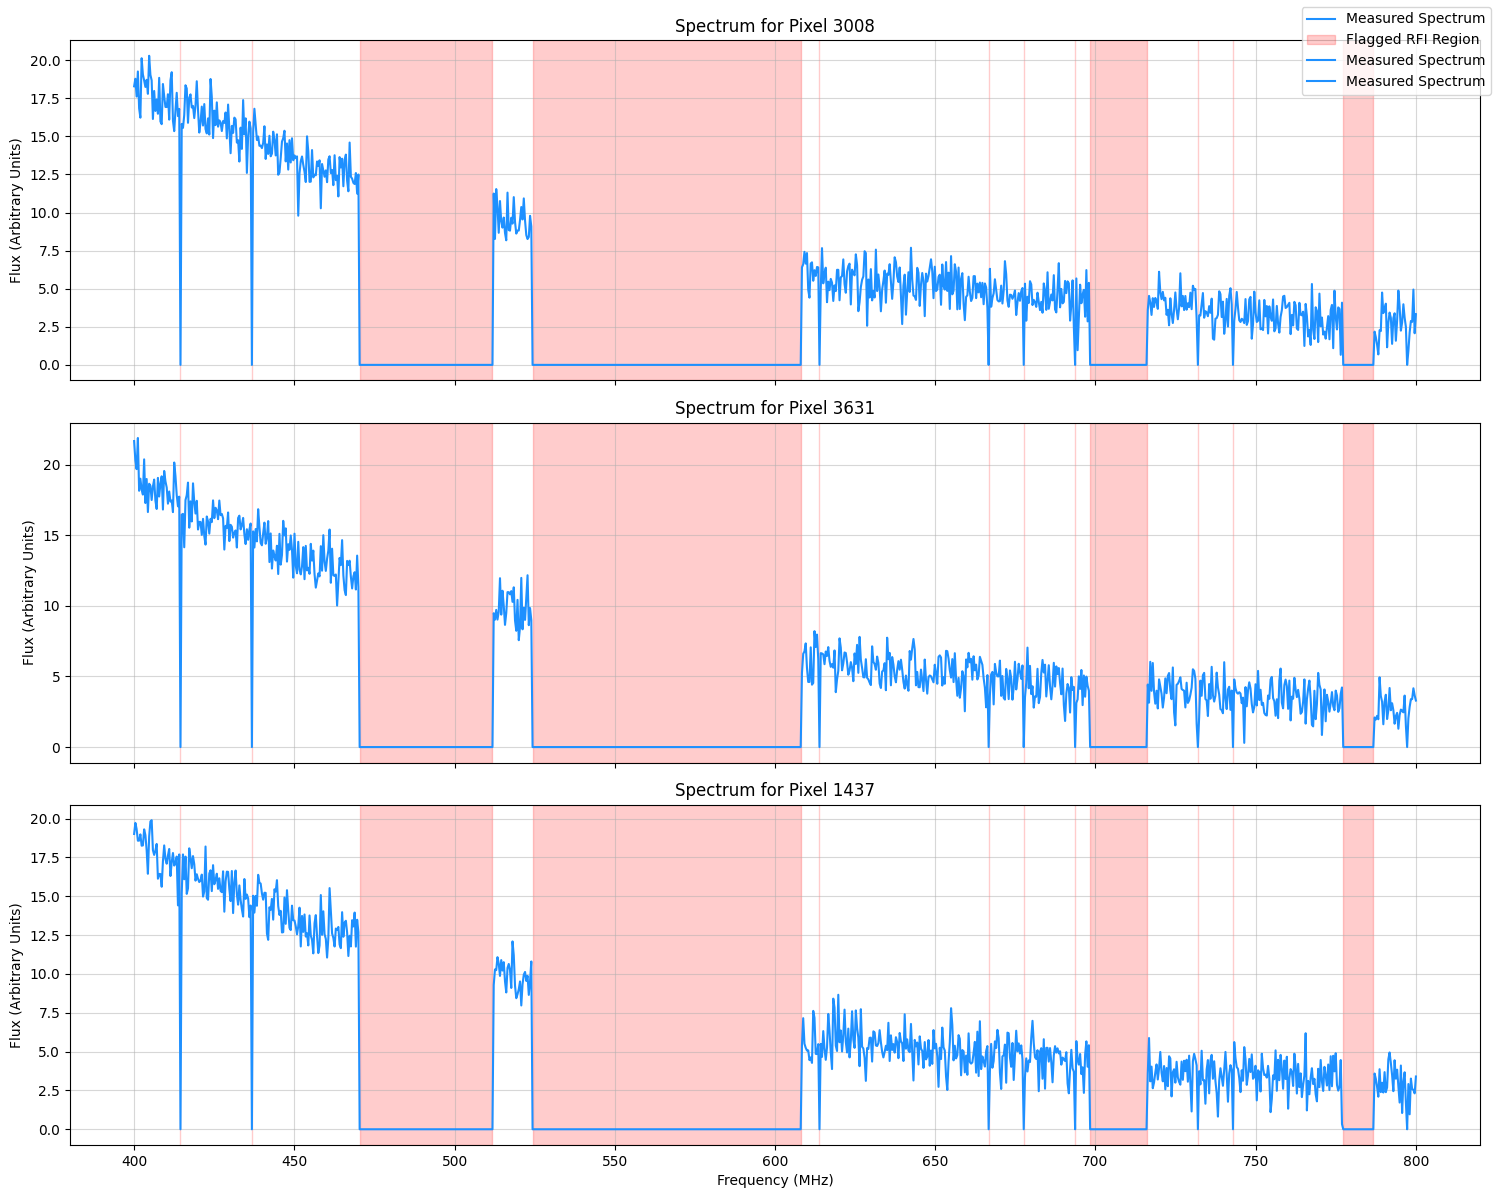

In [21]:
print("--- Displaying Sample Spectra with RFI Masking ---")

# Select a few random pixels to inspect
num_to_plot = 3
pixel_indices_to_plot = np.random.choice(N_PIXELS, num_to_plot, replace=False)

# Create the plot
fig, axes = plt.subplots(num_to_plot, 1, figsize=(15, 4 * num_to_plot), sharex=True)
if num_to_plot == 1:
    axes = [axes] # Ensure axes is always iterable

for i, pixel_idx in enumerate(pixel_indices_to_plot):
    ax = axes[i]
    
    # Plot the spectrum from the data cube
    ax.plot(FREQS_MHZ, data_cube[pixel_idx, :], color='dodgerblue', label='Measured Spectrum')
    
    # Highlight the flagged RFI regions in red
    # `rfi_mask_boolean` is True for GOOD channels, so we plot where it's False
    flagged_indices = np.where(~rfi_mask_boolean)[0]
    
    # To avoid plotting thousands of individual lines, we can find contiguous blocks
    for start in np.where(np.diff(flagged_indices) > 1)[0]:
        end_idx = flagged_indices[start]
        start_idx = flagged_indices[np.where(np.diff(flagged_indices) > 1)[0][np.where(np.where(np.diff(flagged_indices) > 1)[0] == start)[0][0]-1]+1] if start !=0 else flagged_indices[0]
        ax.axvspan(FREQS_MHZ[start_idx], FREQS_MHZ[end_idx], color='red', alpha=0.2, label='Flagged RFI Region' if i == 0 and start == np.where(np.diff(flagged_indices) > 1)[0][0] else "")


    ax.set_title(f'Spectrum for Pixel {pixel_idx}')
    ax.set_ylabel('Flux (Arbitrary Units)')
    ax.grid(True, alpha=0.5)

ax.set_xlabel('Frequency (MHz)')
fig.legend(loc='upper right')
plt.tight_layout()
plt.show()

--- Displaying Sample Spectra with RFI Masking and Infilling---


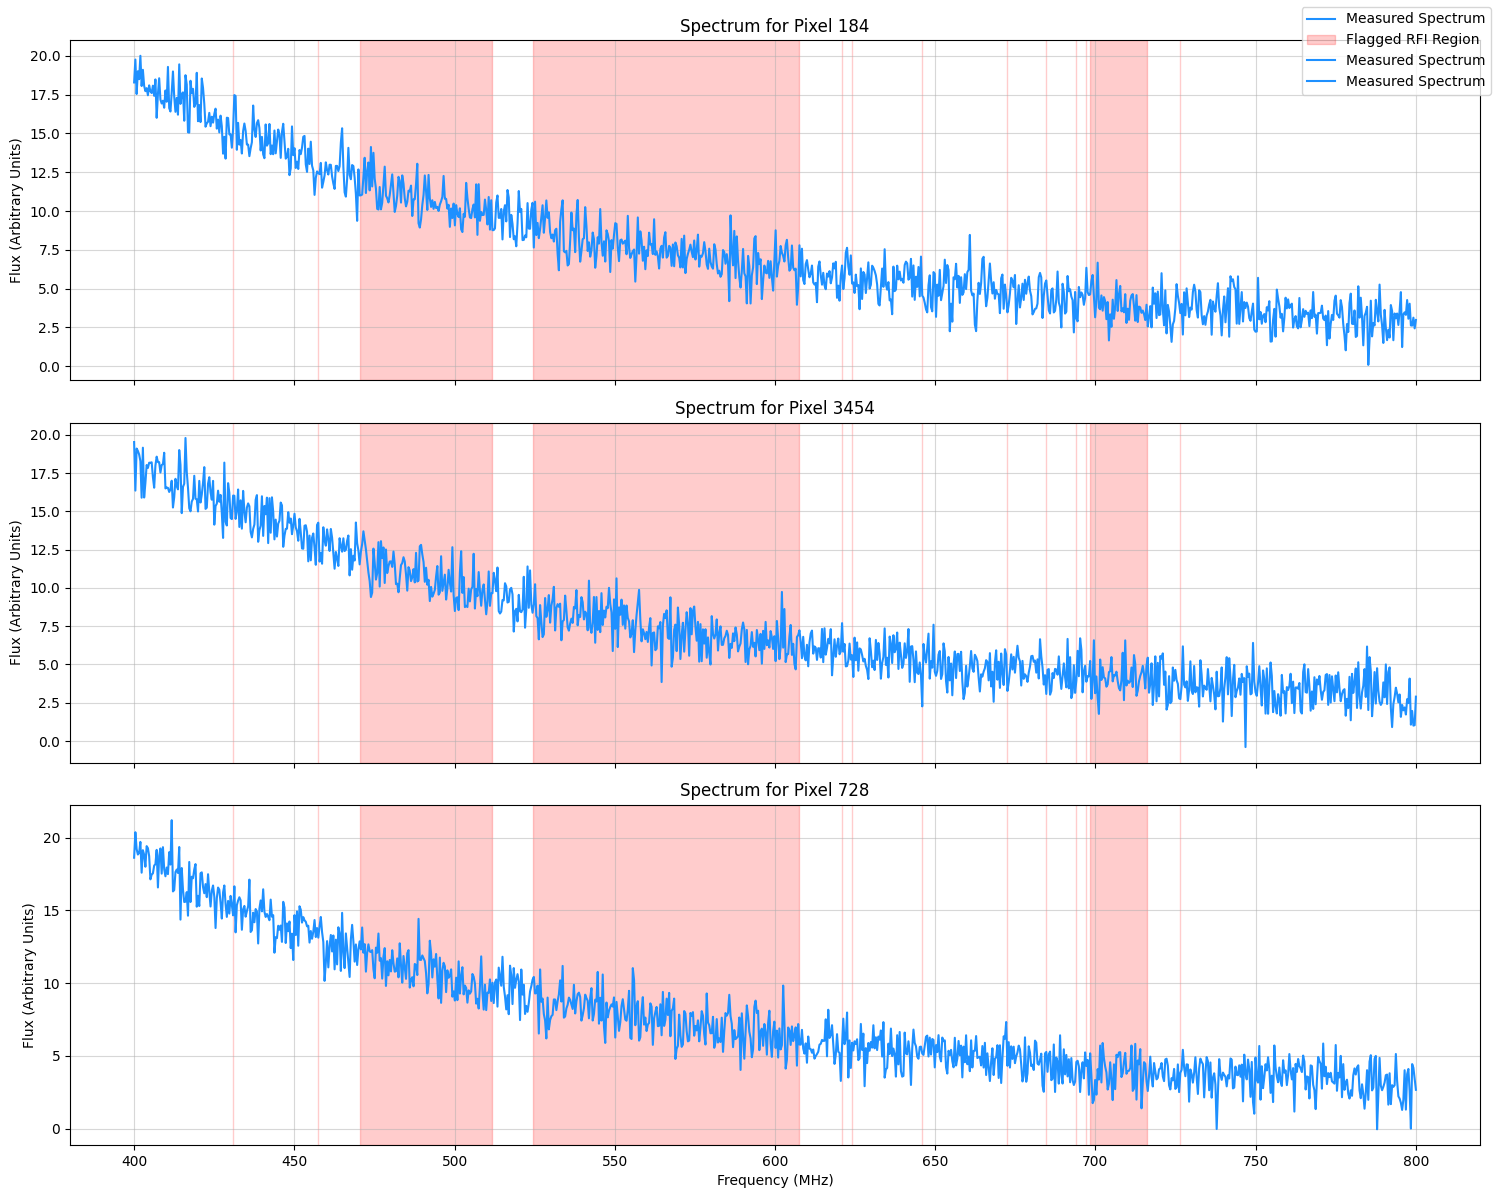

In [25]:
print("--- Displaying Sample Spectra with RFI Masking and Infilling---")

# Select a few random pixels to inspect
num_to_plot = 3
pixel_indices_to_plot = np.random.choice(N_PIXELS, num_to_plot, replace=False)

# Create the plot
fig, axes = plt.subplots(num_to_plot, 1, figsize=(15, 4 * num_to_plot), sharex=True)
if num_to_plot == 1:
    axes = [axes] # Ensure axes is always iterable

for i, pixel_idx in enumerate(pixel_indices_to_plot):
    ax = axes[i]
    
    # Plot the spectrum from the data cube
    infilled_spectrum = oss.infill_rfi(spectrum=data_cube[pixel_idx, :],frequencies=FREQS_MHZ, weights=rfi_mask_boolean)
    ax.plot(FREQS_MHZ, infilled_spectrum, color='dodgerblue', label='Measured Spectrum')
    
    # Highlight the flagged RFI regions in red
    # `rfi_mask_boolean` is True for GOOD channels, so we plot where it's False
    flagged_indices = np.where(~rfi_mask_boolean)[0]
    
    # To avoid plotting thousands of individual lines, we can find contiguous blocks
    for start in np.where(np.diff(flagged_indices) > 1)[0]:
        end_idx = flagged_indices[start]
        start_idx = flagged_indices[np.where(np.diff(flagged_indices) > 1)[0][np.where(np.where(np.diff(flagged_indices) > 1)[0] == start)[0][0]-1]+1] if start !=0 else flagged_indices[0]
        ax.axvspan(FREQS_MHZ[start_idx], FREQS_MHZ[end_idx], color='red', alpha=0.2, label='Flagged RFI Region' if i == 0 and start == np.where(np.diff(flagged_indices) > 1)[0][0] else "")


    ax.set_title(f'Spectrum for Pixel {pixel_idx}')
    ax.set_ylabel('Flux (Arbitrary Units)')
    ax.grid(True, alpha=0.5)

ax.set_xlabel('Frequency (MHz)')
fig.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Scenario 3: Foreground Subtraction with a Delay Filter

The most significant contaminant in our data, even more so than instrumental noise, is the sky itself. Our galaxy and distant radio sources produce incredibly bright foreground emission that is smooth in frequency. This smooth-spectrum emission can be thousands of times brighter than the faint, narrow-band OHM signals we are searching for.

To detect our signals, we must first remove this overwhelming foreground. We can achieve this by transforming our data from the frequency domain into the **delay domain**.

#### What is Delay Space? ⏳

A Fourier transform of a frequency spectrum produces its corresponding "delay spectrum." In this delay space, a signal's properties are mapped differently:

  * **Spectrally Smooth Signals**: Bright, smooth-spectrum sources (like our foregrounds) have very little variation across frequency. In delay space, this means their power is highly concentrated at the origin, at **low delays** (near 0 ns).
  * **Spectrally Complex Signals**: Faint, narrow-band signals (like our OHM masers) have sharp, complex features in the frequency domain. In delay space, this complexity spreads their power far from the origin, out to **high delays**.

#### The Delay Filter

This separation allows us to apply a powerful filter. We perform a Fourier transform on the data, set a "notch" at the center to remove everything at low delay (the foregrounds), and then transform the data back to the frequency domain. The result is a "delay-filtered" spectrum where the bright, smooth foregrounds have been effectively subtracted, allowing the faint, high-delay maser signals to become visible. We will use a **250 ns** delay cut, which is a strong filter designed to aggressively remove foregrounds.


## UPDATE FOR DAYNEU FILTER
-----

### Applying the Delay Filter


## The Dayenu Filter: An Explanation 🧙‍♂️

The Dayenu filter is a powerful technique for separating a faint, structured signal from a bright, smooth "foreground" signal. This is the central challenge in many radio astronomy experiments.

### The Intuitive Analogy: Removing a Hum from a Recording

Imagine you're recording a podcast, but your refrigerator is making a constant, low-pitched **hum** in the background. Your voice is the complex, interesting signal you want to keep, while the refrigerator hum is the simple, uninteresting foreground you want to remove.

* **Your Voice (The Signal)**: Like an OH megamaser, your voice is "spectrally complex." It contains many different frequencies and changes rapidly. In the Fourier domain, its power is spread out.
* **The Hum (The Foreground)**: Like galactic synchrotron emission, the hum is "spectrally simple" or "smooth." It's dominated by a single low frequency. In the Fourier domain, its power is confined to a very small region.

A simple filter might just cut out all low frequencies. This would remove the hum, but it might also remove the low-frequency parts of your voice, changing its quality.

**Dayenu is like a very smart noise-cancellation filter.** Instead of just cutting out frequencies, it builds a perfect mathematical model of the refrigerator hum. It can even build this model if parts of your recording are corrupted by static (which is like RFI). It then subtracts this *exact* model of the hum from the recording, leaving your voice almost perfectly intact. This ability to precisely model and remove the smooth component without distorting the desired signal is what makes Dayenu so effective.

***

### The Formal Mathematical Description

The Dayenu filter is a specific implementation of a linear Wiener filter, tailored for foreground subtraction.

Let our observed data as a function of frequency, $d(\nu)$, be a sum of three components: the foregrounds $d_{fg}(\nu)$, the cosmological signal we want to measure $d_{s}(\nu)$, and instrumental noise $n(\nu)$.

$$d(\nu) = d_{fg}(\nu) + d_{s}(\nu) + n(\nu)$$

The fundamental assumption is that the foregrounds $d_{fg}(\nu)$ are **spectrally smooth**. This means that in the Fourier conjugate domain, known as **delay space** (with coordinates $\tau$), the foregrounds are confined to a compact region near $\tau=0$. Our desired signal $d_s(\nu)$, being spectrally complex, has power spread over a much wider range of delays.

The goal is to design a linear operator (a matrix) $\mathbf{F}$ that, when applied to our data $\mathbf{d}$, gives us the best estimate of the signal $\hat{\mathbf{d}}_{s}$.

$$\hat{\mathbf{d}}_{s} = \mathbf{F} \mathbf{d}$$

Dayenu constructs this operator by modeling the foregrounds not as a signal to be removed, but as a component of a covariance matrix. The filtering operation is expressed as solving for the "clean" data $\hat{\mathbf{d}}_{s}$ in the following equation:

$$(\mathbf{I} + \mathbf{C}_{fg}) \hat{\mathbf{d}}_{s} = \mathbf{d}$$

Here, $\mathbf{I}$ is the identity matrix and $\mathbf{C}_{fg}$ is the covariance matrix of the foregrounds. This formulation essentially asks: "What is the underlying clean signal that, when added to a realization of the foregrounds, produces our observed data?"

The filter is therefore the inverse of this operation:

$$\mathbf{F} = (\mathbf{I} + \mathbf{C}_{fg})^{-1}$$

The power of Dayenu comes from how it constructs $\mathbf{C}_{fg}$. For a single foreground component confined to a delay window centered at $\tau_c$ with half-width $\Delta\tau$ and an effective amplitude of $\alpha$, its covariance in the frequency domain is described by a sinc matrix:

$$\mathbf{C}_{fg}(\nu_i, \nu_j) = \alpha \cdot \text{sinc}(2 \Delta\tau (\nu_i - \nu_j)) e^{-2\pi i (\nu_i - \nu_j) \tau_c}$$

When we use the `dayenu_filter` function, we are implicitly building this $\mathbf{C}_{fg}$ matrix from the `delay_cutoff_ns` parameters. The code then directly computes the inverse matrix $\mathbf{F}$ and applies it to the data to recover the signal. When RFI is present, a weighting matrix $\mathbf{W}$ is included to de-weight the flagged channels, making the operation robust: $\mathbf{F} = (\mathbf{W}(\mathbf{I} + \mathbf{C}_{fg})\mathbf{W})^{-1}\mathbf{W}$.

In [26]:
print("--- Applying Delay Filter to Scenario 3 Data Cube ---")
print("This will remove the bright, smooth-spectrum foregrounds.")

# --- 1. Infill RFI and then apply the Dayneu Filter to the Data Cube ---
print("--- Applying Dayneu Delay Filter to Data Cube (Optimized) ---")
DELAY_CUT_NS = 200.0
delay_filtered_cube = np.zeros_like(data_cube)
foreground_model_cube = np.zeros_like(data_cube)

# --- OPTIMIZATION ---
# Initialize an empty dictionary to serve as our cache.
filter_cache = {}

# The loop structure remains the same.
for i in tqdm(range(N_PIXELS), desc=f"Applying {DELAY_CUT_NS}ns Dayenu Filter"):
    # First, infill the RFI for the current spectrum.
    infilled_spectrum = oss.infill_rfi(
        spectrum=data_cube[i, :],
        weights=rfi_mask_boolean,
        frequencies=FREQS_MHZ
    )
    
    # Apply the Dayenu filter, passing the *same cache dictionary* each time.
    # The filter matrix will be computed on the first loop (i=0) and then
    # retrieved instantly from the cache for all subsequent loops.
    delay_filtered_cube[i, :], foreground_model_cube[i, :] = oss.apply_dayneu_filter(
        spectrum=infilled_spectrum,
        frequencies_mhz=FREQS_MHZ,
        delay_cutoff_ns=DELAY_CUT_NS,
        #weights=rfi_weights, # Use the RFI mask as weights, don't use this when infilling
        cache=filter_cache # Pass the cache
    )
    
print("\nDelay filtering complete.")
print("The 'delay_filtered_cube' is now ready for the matched filter search.")

# As a sanity check, let's compare the standard deviation before and after.
# The filtered cube should have a much lower std dev because the bright foregrounds are gone.
std_before = np.std(data_cube[data_cube != 0])
std_after = np.std(delay_filtered_cube[delay_filtered_cube != 0])

print(f"\nStandard deviation before filtering: {std_before:.2f}")
print(f"Standard deviation after filtering:  {std_after:.2f}")

--- Applying Delay Filter to Scenario 3 Data Cube ---
This will remove the bright, smooth-spectrum foregrounds.
--- Applying Dayneu Delay Filter to Data Cube (Optimized) ---


Applying 200.0ns Dayenu Filter:   0%|          | 0/4096 [00:00<?, ?it/s]

/Users/ckm/notebooks/mp/mp/lib/python3.11/site-packages/uvtools/dspec.py:933: ComplexWarning: Casting complex values to real discards the imaginary part
  output[sample_num] = np.dot(filter_mat, sample)



Delay filtering complete.
The 'delay_filtered_cube' is now ready for the matched filter search.

Standard deviation before filtering: 5.12
Standard deviation after filtering:  0.91


--- Displaying Sample Spectra with RFI Masking ---


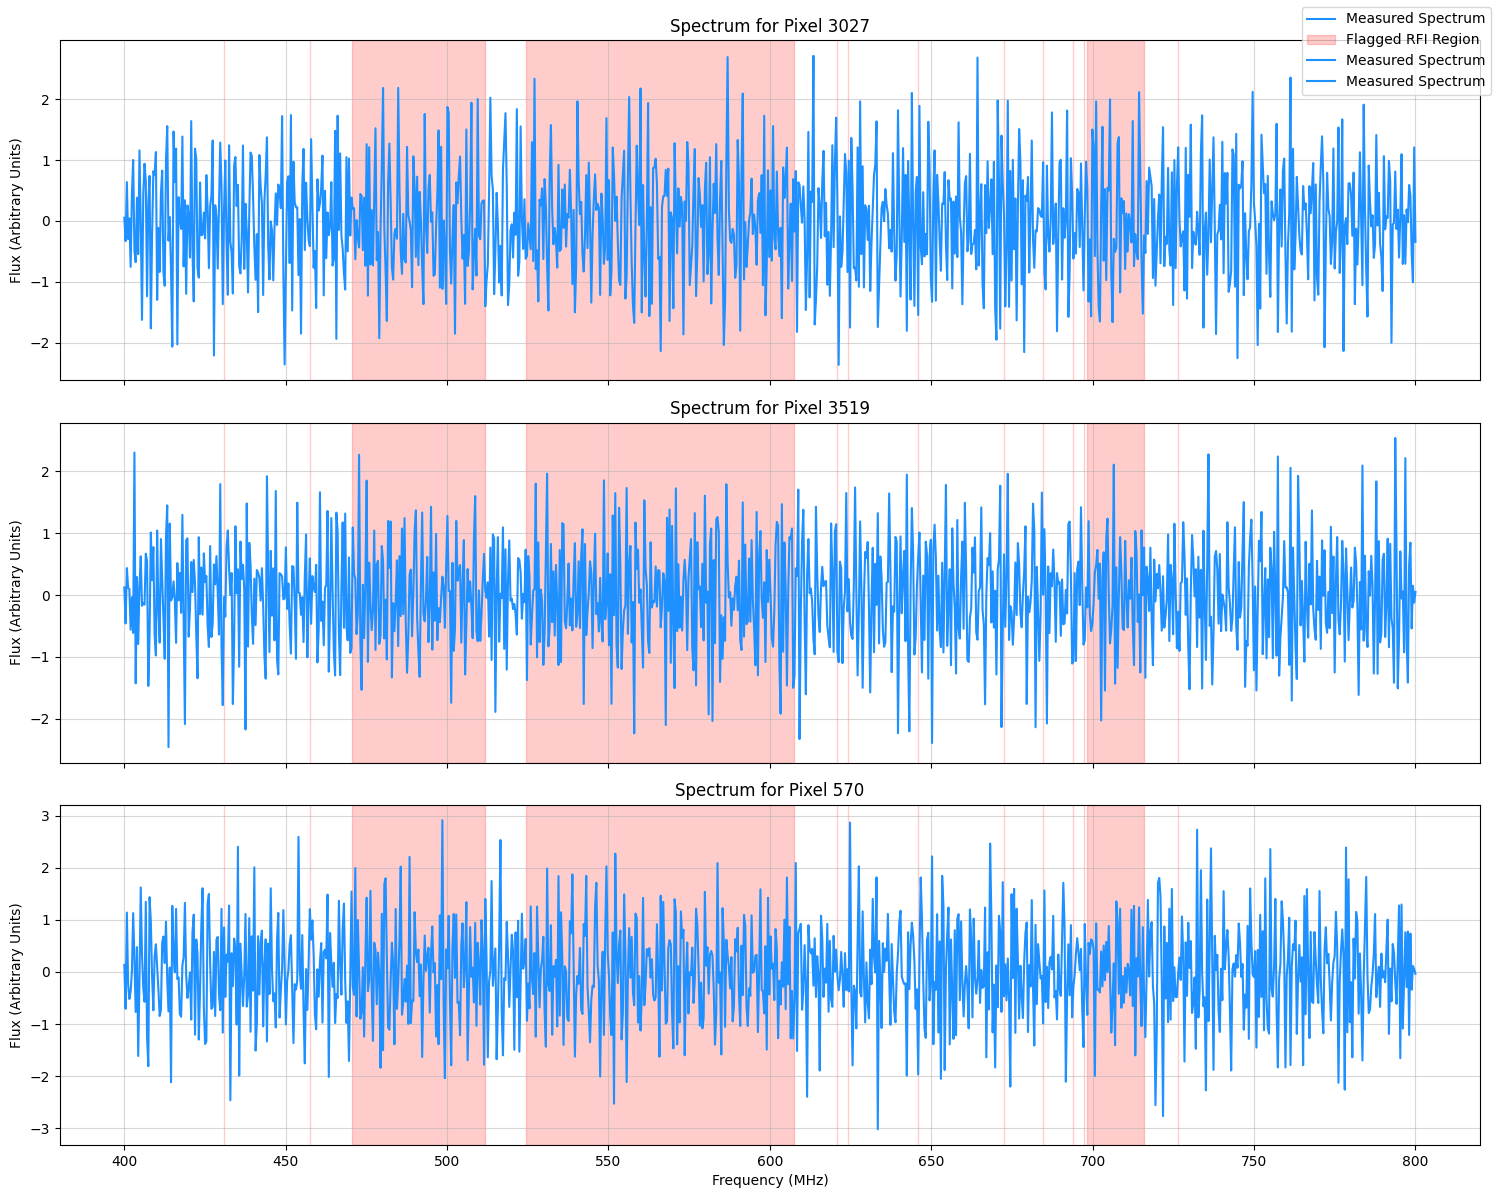

In [27]:
print("--- Displaying Sample Spectra with RFI Masking ---")

# Select a few random pixels to inspect
num_to_plot = 3
pixel_indices_to_plot = np.random.choice(N_PIXELS, num_to_plot, replace=False)

# Create the plot
fig, axes = plt.subplots(num_to_plot, 1, figsize=(15, 4 * num_to_plot), sharex=True)
if num_to_plot == 1:
    axes = [axes] # Ensure axes is always iterable

for i, pixel_idx in enumerate(pixel_indices_to_plot):
    ax = axes[i]
    
    # Plot the spectrum from the data cube
    ax.plot(FREQS_MHZ, delay_filtered_cube[pixel_idx, :], color='dodgerblue', label='Measured Spectrum')
    
    # Highlight the flagged RFI regions in red
    # `rfi_mask_boolean` is True for GOOD channels, so we plot where it's False
    flagged_indices = np.where(~rfi_mask_boolean)[0]
    
    # To avoid plotting thousands of individual lines, we can find contiguous blocks
    for start in np.where(np.diff(flagged_indices) > 1)[0]:
        end_idx = flagged_indices[start]
        start_idx = flagged_indices[np.where(np.diff(flagged_indices) > 1)[0][np.where(np.where(np.diff(flagged_indices) > 1)[0] == start)[0][0]-1]+1] if start !=0 else flagged_indices[0]
        ax.axvspan(FREQS_MHZ[start_idx], FREQS_MHZ[end_idx], color='red', alpha=0.2, label='Flagged RFI Region' if i == 0 and start == np.where(np.diff(flagged_indices) > 1)[0][0] else "")


    ax.set_title(f'Spectrum for Pixel {pixel_idx}')
    ax.set_ylabel('Flux (Arbitrary Units)')
    ax.grid(True, alpha=0.5)

ax.set_xlabel('Frequency (MHz)')
fig.legend(loc='upper right')
plt.tight_layout()
plt.show()

***

## Why Infill RFI for a Matched Filter? The Need for Speed ⚡

You might ask: "If the Dayenu filter is so robust to RFI-flagged gaps, why bother infilling them at all?"

The answer comes down to a trade-off between **robustness** and **computational speed**, especially when performing a blind search with a matched filter. While Dayenu is robust, it can be computationally intensive. For the subsequent matched filter search, we can gain a massive speed-up by using the Fast Fourier Transform (FFT), but the FFT has one critical weakness: it requires complete, uninterrupted data.

### The Convolution Theorem: A Mathematical Shortcut

A matched filter is mathematically a **cross-correlation**. A blind search involves correlating a template, $t(\nu)$, across your entire spectrum, $d(\nu)$. In the frequency domain, this is a slow, "direct summation" operation that scales poorly for large datasets, approximately as $\mathcal{O}(N^2)$.

However, a beautiful mathematical property called the **Convolution Theorem** provides a much faster path. It states that a cross-correlation in the frequency domain is equivalent to a simple element-wise multiplication in the Fourier (delay) domain.

$$(d \star t)(\tau) \Longleftrightarrow \mathcal{F}\{d\}^* \cdot \mathcal{F}\{t\}$$

Here, $\star$ is the cross-correlation, $\mathcal{F}$ is the Fourier Transform, and the asterisk ($^*$) denotes the complex conjugate.

By using the Fast Fourier Transform (FFT) algorithm, which scales as $\mathcal{O}(N \log N)$, we can perform the entire matched filter search dramatically faster. The process becomes:
1.  FFT the data and the template.
2.  Perform one simple multiplication.
3.  Inverse FFT the result to get the full SNR spectrum.

This is the method used by `run_matched_filter_fft`. But to use the FFT, the input arrays must be complete. **This is where infilling becomes essential.** By replacing the RFI-flagged gaps with plausible data, we create a complete array that unlocks the speed of the FFT for our matched filter search.

### A Historical Tidbit: The Secret History of the FFT 📜

The modern FFT algorithm, which sparked the digital signal processing revolution, is most famously credited to **James Cooley** and **John Tukey** from their 1965 paper. It was a groundbreaking development that made digital analysis of signals practical for the first time.

However, the core mathematical idea is much older! The brilliant mathematician **Carl Friedrich Gauss** actually developed a very similar method around **1805**—over 150 years earlier. He used it by hand to calculate the orbits of the asteroids Pallas and Juno. His work was published after his death but was largely overlooked until Cooley and Tukey's independent rediscovery.

The matched filter itself also has a fascinating origin. It was developed during **World War II** around 1943 by **Dwight O. North** at RCA Laboratories. Its purpose was to design the optimal receiver to maximize the signal-to-noise ratio for detecting faint radar echoes in the presence of random noise, a concept that is fundamental to signal detection theory to this day.

-----

### Interactive Viewer: Before and After Delay Filtering

To build intuition for how our foreground filter works, this interactive plot allows you to compare spectra from the same pixel side-by-side.

  * **The Left Panel** shows the raw spectrum from the GDSM simulation, including the bright, smooth foreground component.
  * **The Right Panel** shows the same spectrum *after* the **250 ns** delay filter has been applied.

Notice how the large-scale, smooth structure is removed, leaving behind what is essentially flat, Gaussian-like noise. The standard deviation ($\\sigma$) of the flux, printed in the corner of each plot, provides a quantitative measure of this effect. The goal of the filter is to dramatically reduce the standard deviation of the data before we search for faint signals.

Use the slider to explore different pixels in the simulated sky.

-----


In [28]:
from ipywidgets import interact, IntSlider
import warnings

# Suppress minor warnings from matplotlib to keep the output clean
warnings.filterwarnings("ignore", category=UserWarning)

def plot_spectral_comparison(pixel_index):
    """
    An interactive plotting function to compare a spectrum before and
    after delay filtering for a given pixel.
    """
    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
    fig.suptitle(f'Spectral Comparison for Pixel {pixel_index}', fontsize=16)

    # --- 1. Before Filtering ---
    spec_before = data_cube[pixel_index, :]
    std_before = np.std(spec_before[spec_before != 0]) # Exclude RFI-masked zeros
    ax1.plot(FREQS_MHZ, spec_before, color='firebrick', label='Before Filter')
    ax1.set_title('Before Filtering (Raw GDSM + Noise)')
    ax1.set_xlabel('Frequency (MHz)')
    ax1.set_ylabel('Flux (Arbitrary Units)')
    ax1.grid(True, alpha=0.5)
    # Display the standard deviation in the top-left corner
    ax1.text(0.02, 0.95, f'σ = {std_before:.2f}', transform=ax1.transAxes, 
             ha='left', va='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))

    # --- 2. After Filtering ---
    spec_after = delay_filtered_cube[pixel_index, :]
    std_after = np.std(spec_after[spec_after != 0]) # Exclude RFI-masked zeros
    ax2.plot(FREQS_MHZ, spec_after, color='dodgerblue', label='After Filter')
    ax2.set_title('After Filtering (Foregrounds Removed)')
    ax2.set_xlabel('Frequency (MHz)')
    ax2.grid(True, alpha=0.5)
    # Display the standard deviation in the top-left corner
    ax2.text(0.02, 0.95, f'σ = {std_after:.2f}', transform=ax2.transAxes, 
             ha='left', va='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))

    # Overlay the RFI mask on both plots for context
    if 'rfi_mask_boolean' in globals():
        flagged_indices = np.where(~rfi_mask_boolean)[0]
        for start in np.where(np.diff(flagged_indices) > 1)[0]:
            end_idx = flagged_indices[start]
            start_idx = flagged_indices[np.where(np.diff(flagged_indices) > 1)[0][np.where(np.where(np.diff(flagged_indices) > 1)[0] == start)[0][0]-1]+1] if start !=0 else flagged_indices[0]
            ax1.axvspan(FREQS_MHZ[start_idx], FREQS_MHZ[end_idx], color='red', alpha=0.1)
            ax2.axvspan(FREQS_MHZ[start_idx], FREQS_MHZ[end_idx], color='red', alpha=0.1)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Create the Interactive Slider ---
interact(
    plot_spectral_comparison,
    pixel_index=IntSlider(min=0, max=N_PIXELS - 1, step=1, value=0, description='Pixel Index:')
);

interactive(children=(IntSlider(value=0, description='Pixel Index:', max=4095), Output()), _dom_classes=('widg…

Of course. That's an excellent idea. Visualizing the data in the image domain is just as important as viewing the spectra. This will allow you to scroll through the frequency channels and see how the spatial structure of the sky changes, especially how the bright foregrounds are removed by the delay filter.

Here are the markdown and Python cells to create this new interactive image viewer.

### Interactive Viewer: Image Slices vs. Frequency

This interactive viewer provides a different perspective on our data cube. Instead of looking at the spectrum for one pixel, we are now looking at the entire **2D sky image** at a **single frequency channel**.

  * **The Left Panel** shows the raw sky image at a specific frequency, including the GDSM foregrounds.
  * **The Right Panel** shows the same sky image *after* the delay filter has been applied.

Use the slider to scroll through the different frequency channels of the telescope. Notice how in the "Before" panel, the image is dominated by large-scale power from the foregrounds, while the "After" panel shows what is effectively a map of the instrumental noise. This viewer also tells you if the channel you are currently viewing is flagged for RFI.

-----

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import cmocean
import warnings

# Suppress minor warnings from matplotlib to keep the output clean
warnings.filterwarnings("ignore", category=UserWarning)

def plot_image_comparison(frequency_index):
    """
    An interactive plotting function to compare a 2D sky image before and
    after delay filtering for a given frequency channel.
    """
    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Determine the frequency and RFI status for the title
    freq_mhz = FREQS_MHZ[frequency_index]
    is_flagged = not rfi_mask_boolean[frequency_index]
    rfi_status_str = "FLAGGED FOR RFI" if is_flagged else "Clean"
    
    fig.suptitle(f'Sky Image at {freq_mhz:.2f} MHz (Channel {frequency_index}) | Status: {rfi_status_str}', 
                 fontsize=16, color='red' if is_flagged else 'black')

    # --- 1. Before Filtering ---
    # Get the image slice for this frequency and reshape it to our 2D grid
    img_before = data_cube[:, frequency_index].reshape(GRID_SHAPE)
    im1 = ax1.imshow(img_before, cmap=cmocean.cm.thermal, origin='lower', aspect='auto')
    ax1.set_title('Before Filtering (Raw GDSM + Noise)')
    ax1.set_xlabel('Pixel X-coordinate')
    ax1.set_ylabel('Pixel Y-coordinate')
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label='Flux')

    # --- 2. After Filtering ---
    img_after = delay_filtered_cube[:, frequency_index].reshape(GRID_SHAPE)
    # Use the same color scale for a fair comparison
    im2 = ax2.imshow(img_after, cmap=cmocean.cm.thermal, origin='lower', aspect='auto')#, 
                     #vmin=np.min(img_before), vmax=np.max(img_before))
    ax2.set_title('After Filtering (Foregrounds Removed)')
    ax2.set_xlabel('Pixel X-coordinate')
    ax2.set_ylabel('') # Hide y-axis label for clarity
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, label='Flux')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Create the Interactive Slider ---
interact(
    plot_image_comparison,
    frequency_index=IntSlider(min=0, max=len(FREQS_MHZ) - 1, step=1, value=len(FREQS_MHZ)//2, description='Frequency Channel:')
);

interactive(children=(IntSlider(value=512, description='Frequency Channel:', max=1023), Output()), _dom_classe…

## Part 4: Matched Filtering and SNR Cube Generation

This is the core of the search pipeline. We apply a matched filter to our simulated data cube. The matched filter correlates the data with a set of pre-computed templates that model the expected signal shape at different redshifts.

The output is a 3D Signal-to-Noise (SNR) cube of the same dimensions as the data cube. Each voxel in this cube represents the SNR of the best-matching template at that specific sky position and frequency.

Of course! Here is a detailed markdown cell explaining the matched filter algorithm and the SNR boost calculation, complete with LaTeX equations.

***
### The Direct-Match, Multi-Template Matched Filter

Our pipeline employs a specialized matched filter designed for both efficiency and precision. Unlike a traditional approach that slides every template across the entire frequency spectrum (a full cross-correlation), our **direct-match** method tests each template only at its specific, corresponding frequency location. This provides a massive speed advantage while maintaining the core benefits of matched filtering.

The process can be broken down into four main steps:

---
#### Step 1: Building the Template Bank 🏦

The foundation of the search is a bank of realistic OHM signal templates. To avoid redundant calculations, we use a "generate once, transform many" approach:

1.  **Master Template Creation**: A single, high-resolution "master" template, $T_{\text{intrinsic}}(v)$, is generated in velocity space. This captures the intrinsic, double-peaked profile of a typical OHM signal.

2.  **Redshift Transformation**: This master template is then transformed to create a unique template for each redshift, $z$, in our search grid. This transformation maps the velocity profile to the observed frequency grid, $f_{\text{native}}$, accounting for the cosmological redshift:

    $T_z(f_{\text{native}}) = \text{transform}(T_{\text{intrinsic}}(v), z, f_{\text{native}})$

---
#### Step 2: The Direct-Match Search Algorithm 🎯

For each pixel in the sky, we take its measured frequency spectrum, $D(f)$, and test it against every template, $T_z$, in our bank. The core of the matched filter is the calculation of the Signal-to-Noise Ratio (SNR) for each template at its specific location. This is calculated as a normalized **inner product** (or dot product).

For a given template, $T_z$, which spans a specific range of frequency channels, the SNR is given by:

$\text{SNR}_z = \frac{\sum_{i} D_i \cdot T_{z,i}}{\sigma_{\text{noise}} \sqrt{\sum_{i} T_{z,i}^2}}$

where:
- $D_i$ is the data (flux) in the $i$-th frequency channel that the template overlaps.
- $T_{z,i}$ is the value of the template in that same channel.
- $\sigma_{\text{noise}}$ is the standard deviation (RMS) of the background noise.
- The term $\sqrt{\sum_{i} T_{z,i}^2}$ is the L2-norm (or "energy") of the template, which serves to properly normalize the result.

This calculation is performed for every template in the bank.

---
#### Step 3: Constructing the SNR Cube 🧊

As we calculate the SNR for each template, we build the final 3D Signal-to-Noise cube. Our algorithm "paints" the calculated SNR value across all the frequency channels that the corresponding template occupies.

Crucially, we only update a voxel's value if the new SNR is greater than the value already stored there. This ensures that for any given position in the cube, the final value represents the SNR of the **best-matching template** that overlaps that position.

---
#### Step 4: Predicting the SNR Boost ✨

A key validation step is to predict the theoretical SNR boost a signal *should* receive from the matched filter. This prediction tells us how much a signal with a known amplitude will be amplified relative to the noise.

For a noiseless injected signal, $S$, with a peak amplitude of $A_{\text{peak}}$, its theoretical SNR after filtering is:

$\text{Predicted SNR} = \frac{\sum_{i} S_i \cdot T_{S,i}}{\sigma_{\text{noise}} \sqrt{\sum_{i} T_{S,i}^2}}$

Here, $T_{S,i}$ is the **perfectly matched template** for that signal. Since the signal itself is just a scaled version of its perfect template ($S_i = A_{\text{peak}} \cdot T_{S,i}$), the equation simplifies beautifully:

$\text{Predicted SNR} = \frac{A_{\text{peak}} \sum_{i} T_{S,i}^2}{\sigma_{\text{noise}} \sqrt{\sum_{i} T_{S,i}^2}} = \frac{A_{\text{peak}}}{\sigma_{\text{noise}}} \sqrt{\sum_{i} T_{S,i}^2}$

This elegant result shows that the expected SNR is simply the signal's intrinsic SNR ($A_{\text{peak}}/\sigma_{\text{noise}}$) multiplied by the **energy of the normalized template**. This is the value we use to calculate the "Predicted True Positives" and to create the "Theoretical SNR" histogram.


#### 1. Peak SNR (Used for Detection)

This is the method our direct-match algorithm uses to **detect** signals and construct the initial SNR cube.

* **What it is**: The Peak SNR is the **single, maximum value** of the matched filter response. In our direct-match algorithm, the calculation `(data ⋅ template) / (σ * ||template||)` at a specific location is mathematically equivalent to finding the value at the peak of a full cross-correlation. The value we "paint" into the SNR cube represents this peak response.

* **Pros**:
    * **Simple Statistics**: The noise associated with the Peak SNR is well-described by a Gaussian distribution. This makes it straightforward to predict the false positive rate, as we have done in our analysis.
    * **Efficiency**: It is computationally simple and fast to calculate, making it ideal for the initial, brute-force search across the entire dataset.

* **Cons**:
    * **Sensitivity to Noise**: It can be sensitive to a single, unusually high or low noise value within the footprint of the signal. It doesn't use all the information across the signal's profile.

The equation we use for detection is a pure **Peak SNR**:

$\text{SNR}_{\text{peak}} = \frac{\sum_{i} D_i \cdot T_{z,i}}{\sigma_{\text{noise}} \cdot ||T_z||_2}$
*(where $||T_z||_2$ is the L2-norm)*



### Scenario 3 Matched Filter: Searching in Delay-Filtered Data

Now that the bright, smooth-spectrum foregrounds have been removed from our data cube, we can proceed with the matched filter search. However, because we have applied a linear filter (the delay filter) to our data, we must apply the **exact same filter to our templates** for the search to remain mathematically optimal.

A filter is only "matched" when the template has undergone the same processing as the signal it's trying to find. If we were to use our original, unfiltered templates to search the new, delay-filtered data, there would be a significant mismatch, and the filter's performance would be severely degraded.

The process is therefore:

1.  Generate a template for a given redshift.
2.  Apply the **250 ns** delay filter to this individual template.
3.  Calculate the normalization (energy) of this *new, filtered* template.
4.  Add the filtered template to the bank.

We then use this bank of filtered templates to search our `delay_filtered_cube`. The noise level ($\\sigma$) for the search is now calculated from this filtered cube, as it represents the true noise floor after foreground subtraction.

-----

### Matched Filter Search on Delay-Filtered Cube


In [30]:
# --- 1. Build the Filtered Template Bank ---
print("--- Building Filtered Template Bank ---")
template_bank = []
# Ensure z_grid and N_CHANNELS are defined from a previous cell
if 'z_grid' not in locals():
    z_grid = np.arange(1.05, 3.15, 0.002)

for z in tqdm(z_grid, desc="Building Filtered Templates"):
    # Step 1: Generate the compact, intrinsic template profile at a given redshift.
    compact_template, start_idx, end_idx = otg.process_to_native_resolution_and_target_z(
        intrinsic_template_v=intrinsic_template_v,
        vel_axis_kms=VEL_AXIS,
        z=z,
        native_freq_grid=FREQS_MHZ
    )

    # Skip if the template falls outside the band.
    if compact_template.size == 0 or start_idx is None:
        continue

    # Step 2: Place the compact template into a full-sized array for filtering.
    # This is the new, crucial step that fixes the error.
    full_spectrum_template = otg.create_full_spectrum_template(
        compact_template, start_idx, end_idx, N_CHANNELS
    )

    # Step 3: Apply the delay filter to the full-sized template.
    filtered_full_template, _ = oss.apply_dayneu_filter(
        spectrum=full_spectrum_template,
        frequencies_mhz=FREQS_MHZ,
        delay_cutoff_ns=DELAY_CUT_NS,
        #weights=rfi_weights,
        cache=filter_cache
    )

    # Step 4: Extract the filtered profile from the full array to save memory.
    filtered_compact_template = filtered_full_template[start_idx:end_idx]
    
    # Step 5: Store the filtered, compact profile in the template bank.
    template_bank.append({
        'prof': filtered_compact_template,
        'start': start_idx,
        'end': end_idx
    })

print(f"\nFiltered template bank created with {len(template_bank)} templates.")

--- Building Filtered Template Bank ---


Building Filtered Templates:   0%|          | 0/1050 [00:00<?, ?it/s]

/Users/ckm/notebooks/mp/mp/lib/python3.11/site-packages/uvtools/dspec.py:933: ComplexWarning: Casting complex values to real discards the imaginary part
  output[sample_num] = np.dot(filter_mat, sample)



Filtered template bank created with 1037 templates.



--- Estimating Noise Spectrum (Per-Channel) ---

--- Running Direct-Match Filter Search ---


Processing Pixels:   0%|          | 0/4096 [00:00<?, ?it/s]


SNR cube generation complete.


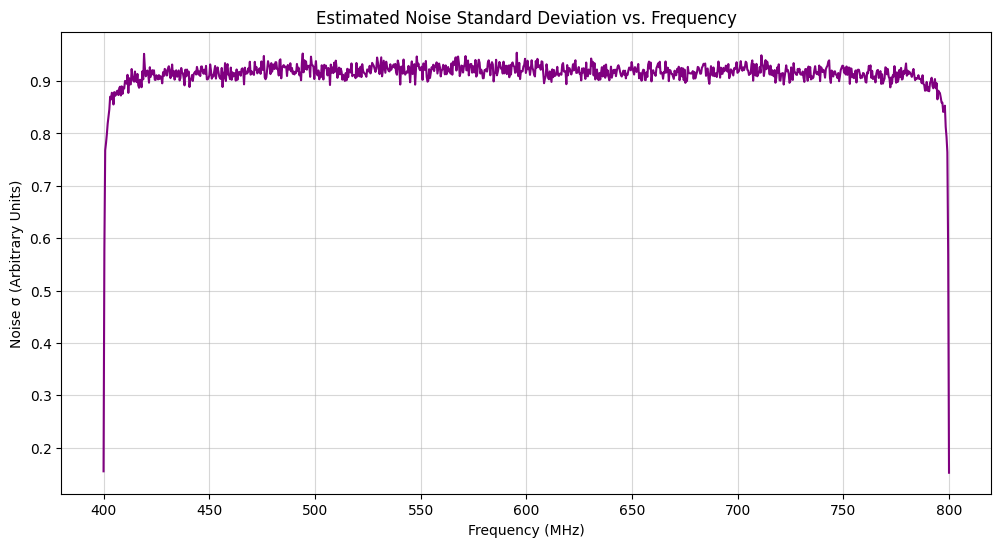

In [31]:
# --- 2. Estimate the noise PER CHANNEL from the delay-filtered cube ---
print("\n--- Estimating Noise Spectrum (Per-Channel) ---")
# This uses the data cube that has had foregrounds removed
noise_spectrum = np.nanstd(delay_filtered_cube, axis=0)

# --- 3. Run the fast, direct-match search with per-channel noise normalization ---
print("\n--- Running Direct-Match Filter Search ---")
snr_cube_3d = np.zeros_like(delay_filtered_cube)

for i in tqdm(range(N_PIXELS), desc="Processing Pixels"):
    spectrum = delay_filtered_cube[i, :]
    pixel_snr_spectrum = np.zeros_like(spectrum)

    for temp_info in template_bank:
        start = temp_info['start']
        end = temp_info['end']
        template_profile = temp_info['prof']
        
        # Get the slice of the data and noise spectrum corresponding to this template
        data_segment = spectrum[start:end]
        noise_segment = noise_spectrum[start:end]
        
        # Calculate the effective normalization factor using the per-channel noise.
        # This is the L2-norm of the template divided by the noise at each channel.
        norm_effective = np.sqrt(np.sum((template_profile / noise_segment)**2))
        if norm_effective < 1e-6:
            continue
            
        # Correlate the data with the template, also weighted by the noise
        weighted_data = data_segment / noise_segment**2
        
        snr = np.sum(weighted_data * template_profile) / norm_effective
        
        # "Paint" the single SNR value across the template's footprint
        current_snr_segment = pixel_snr_spectrum[start:end]
        update_mask = snr > current_snr_segment
        pixel_snr_spectrum[start:end][update_mask] = snr
                
    snr_cube_3d[i, :] = pixel_snr_spectrum

print("\nSNR cube generation complete.")

# --- Sanity Check: Plot the Noise Spectrum ---
plt.figure(figsize=(12, 6))
plt.plot(FREQS_MHZ, noise_spectrum, color='purple')
plt.title('Estimated Noise Standard Deviation vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Noise σ (Arbitrary Units)')
plt.grid(True, alpha=0.5)
plt.show()

## Part 5: 3D Candidate Finding with DBSCAN

With the SNR cube generated, we now identify significant signal candidates. Instead of simply taking the maximum SNR value in each pixel (a 2D approach), we use the **3D DBSCAN clustering algorithm**. This method treats the SNR cube as a 3D space and groups together neighboring voxels that are all above a certain SNR threshold.

This approach is more robust because:
* It is less susceptible to single-pixel noise spikes.
* It can distinguish between multiple sources at the same sky position but at different frequencies (redshifts).
* It provides a more accurate estimate of a candidate's centroid and extent in all three dimensions (sky position and frequency).

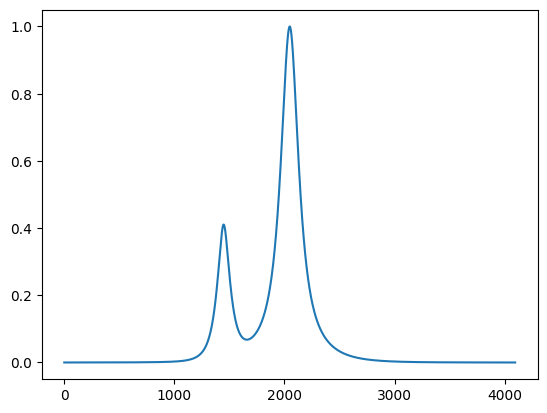

In [32]:
plt.plot(intrinsic_template_v);

In [33]:
template, start_idx, end_idx = otg.process_to_native_resolution_and_target_z(
        intrinsic_template_v=intrinsic_template_v,
        vel_axis_kms=VEL_AXIS,
        z=1.2,
        native_freq_grid=FREQS_MHZ
    )

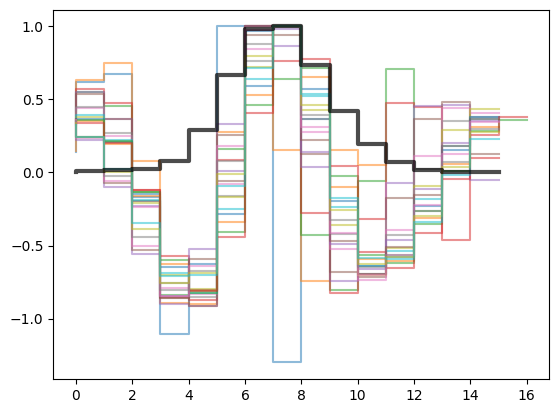

In [34]:
for tp in template_bank[5:25]:
    plt.plot(tp['prof']/tp['prof'].max(), alpha=.5, ds='steps');
plt.plot(template/template.max(), color='k', linewidth=3, alpha=.7, ds='steps');

In [35]:
snr_cube_3d.max()

np.float64(13.31861729617538)

***
### Finding Candidates with DBSCAN: From Voxel-Space to Physical Objects

After the matched filter has produced a 3D Signal-to-Noise Ratio (SNR) cube, the next critical step is to identify physically meaningful signal candidates within it. Simply picking out the highest SNR voxels is not robust; it's susceptible to single-channel noise spikes and doesn't group related parts of a signal together.

To solve this, we use **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise), a powerful clustering algorithm that groups together closely packed points in space. By treating our 3D SNR cube as a spatial volume, DBSCAN allows us to identify contiguous regions of high SNR, effectively turning a cloud of voxels into a list of distinct candidate objects. 🔎

The process can be broken down into three main steps:

---
#### Step 1: Thresholding the SNR Cube

First, we apply our detection threshold ($\sigma_{\text{thresh}}$, e.g., 7.0) to the SNR cube. Any voxel with an SNR below this value is discarded. This leaves us with a sparse 3D map containing only the most significant SNR peaks, which become the input for the clustering algorithm.

---
#### Step 2: Running the DBSCAN Algorithm

DBSCAN works by defining a "cluster" based on two key parameters:

* **`eps` ($\epsilon$)**: The maximum distance (in our case, measured in pixels/channels) between two points for them to be considered neighbors.
* **`min_samples`**: The minimum number of points required to form a dense core region.

The algorithm iterates through the high-SNR voxels and classifies them:

1.  **Core Points**: A voxel is a **core point** if it has at least `min_samples` neighbors (including itself) within a radius of $\epsilon$. These are the hearts of our candidate clusters.
2.  **Border Points**: A voxel is a **border point** if it is within $\epsilon$ of a core point but does not have enough neighbors to be a core point itself. These are the edges of our candidates.
3.  **Noise Points**: Any voxel that is neither a core nor a border point is classified as **noise** and discarded.

DBSCAN connects core points that are neighbors, and then attaches their border points to form the final candidate clusters.

---
#### Step 3: Vetting Candidates and Rejecting RFI

This is where the power of DBSCAN as a "vetting" tool becomes clear. The algorithm's density-based nature provides an inherent defense against common types of noise and interference that a simple peak-finding algorithm would fail to reject:

* **Isolated Noise Spikes**: A random, single-channel noise fluctuation that happens to cross our SNR threshold will likely be isolated. Since it won't have `min_samples` neighbors, DBSCAN will correctly classify it as a **noise point** and discard it.

* **Broadband RFI**: Radio Frequency Interference (RFI) often appears as a signal that is strong across a very wide range of frequencies but is narrow in the spatial dimensions (i.e., it affects all pixels at a specific frequency). Let's say we have an RFI signal that is 1 pixel wide but 500 channels long. While it may have many high-SNR voxels, they are not clustered in a physically realistic, compact shape. By setting `eps` to a small, reasonable value (e.g., 3), DBSCAN would fail to find a dense **3D core** and would likely break this long, thin structure into many small, insignificant clusters that get discarded.

* **Instrumental Artifacts**: Other non-physical signals, like detector artifacts that might appear as lines or other strange shapes in the data cube, are also unlikely to form the kind of compact, 3D-ellipsoidal clusters that a real astrophysical signal would. DBSCAN's requirement for a dense core region makes it robust against such contaminants.

In essence, DBSCAN acts as a **morphological filter**, implicitly selecting for candidates that have the compact, 3D structure we expect from a real OH megamaser and rejecting those that are too sparse, too thin, or too oddly shaped to be astrophysical. This provides a critical layer of automated vetting before any human analysis is required.

Here is a markdown cell that explains the robust matching logic used in the updated `match_candidates_to_truth_3d` function.

***
### Matching Candidates to Ground Truth: A Robust Approach

After the pipeline finds a list of candidates, the final step in validation is to determine which of them are real detections (True Positives) and which are noise (False Positives). To do this reliably, we need a robust method for matching our found candidates to the "ground truth" list of signals we injected.

Our algorithm works by defining a 3D "matching volume" around each true injected signal and checking if a candidate's centroid falls within it.

#### The Matching Criteria

For each candidate found by DBSCAN, we compare its position to every known injected signal. A candidate is considered a successful match to an injection if its centroid satisfies two conditions simultaneously:

1.  **Spatial Proximity**: The candidate's (x, y) sky position must be within a given search radius, $R_{\text{spatial}}$, of the true signal's position. This accounts for small positional errors caused by noise.

    $d_{\text{spatial}} = \sqrt{(y_{\text{cand}} - y_{\text{inj}})^2 + (x_{\text{cand}} - x_{\text{inj}})^2} \le R_{\text{spatial}}$

2.  **Frequency Proximity**: The candidate's centroid frequency must be within a given search radius, $R_{\text{freq}}$, of the true signal's frequency. This accounts for small redshift errors, also caused by noise.

    $d_{\text{freq}} = |f_{\text{cand}} - f_{\text{inj}}| \le R_{\text{freq}}$

#### Ensuring One-to-One Matching

A critical feature of this matching algorithm is that it enforces a **one-to-one relationship**. To prevent a single bright injection from being matched to multiple nearby candidate clusters, or a single candidate being matched to multiple injections, the code keeps track of which signals and candidates have already been paired. Once a match is made, neither the candidate nor the injection is available for any further matches. This robust logic ensures that our counts of True Positives and False Positives are accurate.

That's an excellent catch\! Those cluster sizes are a classic symptom of what happens when you run a simple clustering algorithm on **correlated noise**. The `delay_filtered_cube` no longer contains pure, "white" Gaussian noise, and this has major consequences for DBSCAN.

### The Problem: Correlated Noise and the "Continent Effect"

Here’s what's happening:

1.  **The Delay Filter's Side Effect**: The delay filter, especially a strong one, doesn't just remove the foregrounds. It also introduces low-level, large-scale **correlations** into the background noise. You can think of it as creating very broad, faint "ripples" across the frequency spectrum of every single pixel.
2.  **The SNR Cube**: When the matched filter runs on this rippled noise, the resulting `snr_cube_3d` is also filled with these broad, low-amplitude waves.
3.  **DBSCAN's Confusion**: The DBSCAN algorithm, with its current parameters, sees these ripples. Even if the ripples are low-level (e.g., 1-2σ), there are so many connected voxels that are slightly above the noise floor that DBSCAN thinks it has found a single, enormous "continent" of signal. It then connects thousands of these voxels into one giant cluster, leading to the huge sizes you're seeing.

-----

### The Solution: Local Background Subtraction

To fix this, we need to remove these large-scale noise correlations from the SNR cube before we run DBSCAN. The standard technique for this is **local background subtraction**.

The idea is simple: for each frequency channel in a pixel's SNR spectrum, we estimate the local "background" by taking a smoothed or median-filtered version of the spectrum. We then subtract this background from the original SNR spectrum. This process effectively removes the broad, correlated ripples, leaving only the sharp, compact peaks from real signals.

Here is a new cell that defines a function to perform this step and applies it before running DBSCAN.

### Part 5b: Local Background Subtraction on the SNR Cube

**After running this cell, you can then re-run your DBSCAN cluster diagnostic cell.** You should now see that the average and maximum cluster sizes are much smaller and more physically sensible.

### Data → Delay Filter → Matched Filter → SNR Cube → DBSCAN

In [36]:
print(f"--- Finding Candidates in 3D SNR Cube (Threshold: {SNR_THRESHOLD}σ) ---")

found_candidates_3d = ocf.find_candidates_3d_dbscan(
    snr_cube=snr_cube_3d.reshape(GRID_SHAPE + (len(FREQS_MHZ),)), # Reshape to (y, x, freq)
    snr_threshold=SNR_THRESHOLD,
    eps=DBSCAN_EPS,
    min_samples=DBSCAN_MIN_SAMPLES,
    freqs_mhz=FREQS_MHZ
)

print(f"Found {len(found_candidates_3d)} candidates using 3D DBSCAN.")

--- Finding Candidates in 3D SNR Cube (Threshold: 5.0σ) ---
Found 100 candidates using 3D DBSCAN.


In [37]:
# --- Candidate Vetting ---
print(f"Initial number of candidates found by DBSCAN: {len(found_candidates_3d)}")

# --- Vetting Parameters ---
# Condition 3: Define an adjustable margin for the spectral edges.
# Candidates found within this many channels of the edge will be rejected.
edge_margin_channels = 10 # set this to zero for Dayneu filter

# --- Initialize Counters for Rejected Candidates ---
rejected_band = 0
rejected_rfi = 0
rejected_edge = 0

# Create a new, vetted list of candidates
vetted_candidates = []
for cand in found_candidates_3d:
    # Get the candidate's centroid frequency
    centroid_freq = cand['centroid_z_freq']
    
    # --- Condition 1: Check if the candidate is within the observable band ---
    is_in_band = (FREQS_MHZ.min() <= centroid_freq <= FREQS_MHZ.max())
    if not is_in_band:
        rejected_band += 1
        continue # Skip to the next candidate

    # Find the index of the frequency channel closest to the centroid
    freq_idx = np.argmin(np.abs(FREQS_MHZ - centroid_freq))

    # --- Condition 2: Check if the candidate is in an RFI-flagged channel ---
    # rfi_mask_boolean is True for GOOD channels, so we check if it's True
    is_in_clean_channel = rfi_mask_boolean[freq_idx]
    if not is_in_clean_channel:
        rejected_rfi += 1
        continue # Skip to the next candidate

    # --- Condition 3: Check if the candidate is near the ends of the spectrum ---
    is_away_from_edge = (edge_margin_channels <= freq_idx < (len(FREQS_MHZ) - edge_margin_channels))
    if not is_away_from_edge:
        rejected_edge += 1
        continue # Skip to the next candidate
        
    # If the candidate passes all checks, add it to our vetted list
    vetted_candidates.append(cand)

print(f"\nNumber of candidates after vetting: {len(vetted_candidates)}")
num_rejected = len(found_candidates_3d) - len(vetted_candidates)
print(f"Total rejected candidates: {num_rejected}")
print(f"  - Rejected due to falling outside the band: {rejected_band}")
print(f"  - Rejected due to being in RFI zones: {rejected_rfi}")
print(f"  - Rejected due to being too close to spectral edges: {rejected_edge}")


# --- IMPORTANT: Overwrite the old candidate list with our new, clean one ---
found_candidates_3d = vetted_candidates

Initial number of candidates found by DBSCAN: 100

Number of candidates after vetting: 86
Total rejected candidates: 14
  - Rejected due to falling outside the band: 0
  - Rejected due to being in RFI zones: 3
  - Rejected due to being too close to spectral edges: 11


--- DBSCAN Cluster Size Report ---
Total number of candidates found: 86
Average cluster size: 11.80 voxels
Standard deviation of cluster sizes: 2.32 voxels
Minimum cluster size: 9 voxels
Maximum cluster size: 19 voxels
------------------------------------


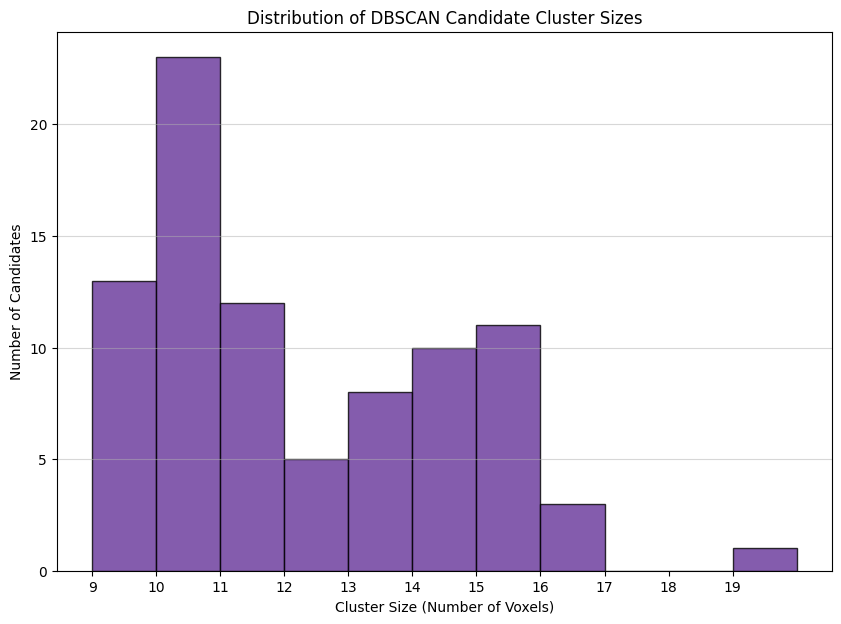

In [38]:
# --- DBSCAN Cluster Diagnostics ---

# This analysis uses the 'found_candidates_3d' list generated in Part 5
if 'found_candidates_3d' in locals() and len(found_candidates_3d) > 0:
    # Extract the size (in voxels) of each candidate cluster
    cluster_sizes = [cand['size_voxels'] for cand in found_candidates_3d]

    # --- Print Statistical Summary ---
    print("--- DBSCAN Cluster Size Report ---")
    print(f"Total number of candidates found: {len(cluster_sizes)}")
    print(f"Average cluster size: {np.mean(cluster_sizes):.2f} voxels")
    print(f"Standard deviation of cluster sizes: {np.std(cluster_sizes):.2f} voxels")
    print(f"Minimum cluster size: {np.min(cluster_sizes)} voxels")
    print(f"Maximum cluster size: {np.max(cluster_sizes)} voxels")
    print("------------------------------------")

    # --- Plot a Histogram of Cluster Sizes ---
    plt.figure(figsize=(10, 7))
    plt.hist(cluster_sizes, bins=range(min(cluster_sizes), max(cluster_sizes) + 2), 
             color='rebeccapurple', edgecolor='black', alpha=0.8)
    plt.title('Distribution of DBSCAN Candidate Cluster Sizes')
    plt.xlabel('Cluster Size (Number of Voxels)')
    plt.ylabel('Number of Candidates')
    plt.grid(True, axis='y', alpha=0.5)
    # Set x-axis ticks to be integers
    plt.xticks(np.arange(min(cluster_sizes), max(cluster_sizes)+1, step=max(1, (max(cluster_sizes)-min(cluster_sizes))//10)))
    plt.show()

else:
    print("No candidates were found, so no cluster diagnostics to report.")

***
### Vetting Candidates After Detection

The vetting process works like this:

1.  **Detection and Characterization**: The pipeline runs, and DBSCAN produces a list of candidates. For each candidate, we have a set of properties, including its **peak SNR**, its **integrated SNR**, and its **size in voxels**.
2.  **Applying Cuts**: We then apply a series of "cuts" to this list to reject non-physical candidates. This is where your example comes in. We could define a rule like:
    * `IF candidate.size_voxels > 10 THEN REJECT`
    * `IF candidate.integrated_snr / candidate.peak_snr > some_threshold THEN REJECT` (This can find oddly shaped signals)
3.  **Final Candidate List**: Only the candidates that pass all these vetting cuts are considered high-quality detections worthy of follow-up.

***


## Part 6: Performance and Validation

Now we evaluate the performance of our search by comparing the candidates found by DBSCAN against our `ground_truth` injections. This allows us to calculate key performance metrics.


-----

### Deconstructing the Search Performance Report

The search performance report provides a quantitative summary of the pipeline's effectiveness by comparing the candidates it finds to the "ground truth" of the injected signals. The report is split into two sections: **Measured Metrics**, which describe the direct results of the search, and **Validation Metrics**, which compare the results to statistical predictions.

-----

### Measured Metrics

These metrics are calculated *after* running the search and matching the found candidates to the ground truth injections.

  * **True Positives (TP)**: The number of real, injected signals that were successfully detected by the pipeline.
  * **False Positives (FP)**: The number of candidates that were incorrectly flagged as signals but correspond only to noise.
  * **False Negatives (FN)**: The number of real, injected signals that the pipeline *failed* to detect.

From these counts, we derive two key rates:

1.  **Completeness (or Recall/True Positive Rate)**: This tells us what fraction of the total real signals we actually found. A perfect pipeline has a completeness of 100%.

    $\text{Completeness} = \frac{\text{TP}}{\text{TP} + \text{FN}} = \frac{\text{Number of Signals Found}}{\text{Total Number of Injected Signals}}$

2.  **Purity (or Precision)**: This tells us what fraction of the candidates we found are actually real signals. A perfect pipeline has a purity of 100%.

    $\text{Purity} = \frac{\text{TP}}{\text{TP} + \text{FP}} = \frac{\text{Number of Real Detections}}{\text{Total Number of Detections}}$

-----

### Validation Metrics (Statistical Predictions)

These metrics are calculated from first principles to predict how the pipeline *should* behave. Comparing these predictions to the measured metrics is a critical step in validating the pipeline.

1.  **Predicted True Positives**: We calculate the theoretical Signal-to-Noise Ratio (SNR) for every single injected signal. The predicted number of true positives is simply the count of injected signals whose theoretical SNR is greater than our detection threshold ($\sigma_{thresh}$).

    $\text{Predicted TP} = \sum_{i=1}^{N_{\text{injected}}} [ \text{SNR}*{\text{theoretical}, i} \ge \sigma*{\text{thresh}} ]$
    <br>
    *(where the square brackets represent the Iverson bracket, which is 1 if the condition is true and 0 otherwise)*

2.  **Predicted False Positives**: For pure Gaussian noise, we can predict the number of noise peaks that will cross our threshold by pure chance. This is the product of the total number of independent locations we searched ($N_{\text{voxels}}$) and the probability of a single standard normal variable exceeding the threshold. This probability is given by the Gaussian survival function, often denoted $Q(x)$.

    $\text{Predicted FP} = N_{\text{voxels}} \times Q(\sigma_{\text{thresh}})$
    <br>
    where
    <br>
    $Q(x) = \frac{1}{\sqrt{2\pi}} \int_x^\infty e^{-t^2/2} dt$

3.  **Predicted Purity**: Using the two predictions above, we can calculate a theoretical purity for our search. A close match between the measured and predicted purity gives us high confidence that the matched filter and noise statistics are well-understood.

    $ \text{Predicted Purity} = \frac{\text{Predicted TP}}{\text{Predicted TP} + \text{Predicted FP}} $

-----

### Predicting Performance with RFI: A Two-Fold Approach

When Radio Frequency Interference (RFI) is present, not all signals are created equal. Some may fall into clean parts of the band, while others might be partially or completely obliterated. To account for this, we use a two-fold approach to predict our pipeline's performance.

#### 1\. The Probabilistic Estimate (The "Quick Guess") 🎲

This is a simple, first-order approximation. It assumes that the injected signals are distributed randomly across the frequency band. If a certain fraction of the band is flagged for RFI, we make a simple probabilistic guess that the same fraction of signals will be lost.

  * **Logic**: If 15% of the channels are masked by RFI, we predict a 15% loss in completeness.

  * **Equation**:

    $\text{Predicted Completeness}\_{\text{prob}} = 1 - \text{Fraction of Channels Flagged}$

This gives us a quick, back-of-the-envelope expectation for the search performance.

#### 2\. The Deterministic Prediction (The "Ground Truth" Calculation) 🔬

This is a much more precise and powerful prediction. Since we know the exact profile and frequency of every single signal we injected, we don't have to guess. We can calculate the exact impact of the RFI mask on each one.

The process is as follows:

1.  **Iterate Through Injections**: We loop through each signal in our `ground_truth` dictionary.

2.  **Calculate Energy Loss**: For each signal, we look at its `noiseless_profile` and the `rfi_mask` to determine precisely what fraction of its total energy is lost because its constituent channels were flagged.

3.  **Calculate Degraded SNR**: The signal's ideal, theoretical SNR is then degraded by this energy loss factor:

    $\text{SNR}*{\text{degraded}} = \text{SNR}*{\text{ideal}} \times \sqrt{1 - \text{Fraction of Energy Lost}}$

4.  **Count Survivors**: We then count how many of the injected signals still have a degraded SNR above our detection threshold ($\sigma\_{\text{thresh}}$).

This deterministic method gives us the **exact number of signals the pipeline should be able to find**, providing the most accurate possible prediction to validate our measured results against.

-----

### Performance Report with Advanced Predictions (Scenario 3)

In [39]:
NOISE_SIGMA_MEASURED = np.nanmean(noise_spectrum)

In [40]:
# --- Performance Report (Scenario 3) ---

# --- Match Candidates to Ground Truth ---
print("--- Matching Found Candidates to Ground Truth Injections ---")
matched_results_3d = ocf.match_candidates_to_truth_3d(
    candidates=found_candidates_3d,
    ground_truth=ground_truth,
    grid_shape=GRID_SHAPE,
    freqs_mhz=FREQS_MHZ
)

# --- Measured Metrics ---
n_tp = len(matched_results_3d['true_positives'])
n_fp = len(matched_results_3d['false_positives'])
completeness_measured = n_tp / N_INJECTIONS if N_INJECTIONS > 0 else 0
purity_measured = n_tp / len(found_candidates_3d) if found_candidates_3d else 1.0


# --- Statistical Predictions (Scenario 3) ---
print("\n--- Calculating Final Statistical Predictions ---")

# 1. PROBABILISTIC PREDICTION
# This model provides a statistical "quick guess" for comparison.
n_prob_sim = 10000
simulated_amps = np.abs(np.random.normal(loc=2, scale=3, size=n_prob_sim))
noise_sigma_measured = np.std(noise_spectrum[rfi_mask_boolean])
# A representative template energy for the quick guess
avg_template_energy = np.sum((template_bank[len(template_bank)//2]['prof'])**2)
ideal_snrs = (simulated_amps * np.sqrt(avg_template_energy)) / noise_sigma_measured
fraction_detectable_ideal = np.sum(ideal_snrs > SNR_THRESHOLD) / n_prob_sim
fraction_flagged = 1 - np.mean(rfi_weights)
# A placeholder for measured SNR loss from the filter
snr_loss_from_filter_frac = 0.01
predicted_completeness_prob = fraction_detectable_ideal * (1 - fraction_flagged) * (1 - snr_loss_from_filter_frac)
predicted_tp_prob = predicted_completeness_prob * N_INJECTIONS

# 2. DETERMINISTIC PREDICTION (End-to-End)
# This model predicts the SNR for each injection in a NOISELESS world.
predicted_peak_snrs = []
for g in tqdm(ground_truth['injections'], desc="Running End-to-End Deterministic Prediction"):
    noiseless_spectrum_original = g.get('noiseless_profile')
    if noiseless_spectrum_original is None: continue

    noiseless_spectrum_filtered, _ = oss.apply_dayneu_filter(
        spectrum=noiseless_spectrum_original,
        frequencies_mhz=FREQS_MHZ,
        delay_cutoff_ns=DELAY_CUT_NS,
        cache=filter_cache
        )
    
    theoretical_snr_spectrum = np.zeros_like(noiseless_spectrum_filtered)
    for temp_info in template_bank:
        start, end = temp_info['start'], temp_info['end']
        template_profile = temp_info['prof']
        template_mask = rfi_mask_boolean[start:end]
        template_preserved = template_profile * template_mask
        noise_segment = noise_spectrum[start:end]
        norm_effective = np.sqrt(np.sum((template_preserved / noise_segment)**2))
        if norm_effective < 1e-6: continue
        data_segment = noiseless_spectrum_filtered[start:end]
        weighted_data = data_segment / noise_segment**2
        snr = np.sum(weighted_data * template_preserved) / norm_effective
        current_snr_segment = theoretical_snr_spectrum[start:end]
        update_mask = snr > current_snr_segment
        theoretical_snr_spectrum[start:end][update_mask] = snr
        
    predicted_peak_snrs.append(np.max(theoretical_snr_spectrum))

predicted_tp_deter = np.sum(np.array(predicted_peak_snrs) > SNR_THRESHOLD)
predicted_completeness_deter = predicted_tp_deter / N_INJECTIONS if N_INJECTIONS > 0 else 0


# 3. SUPERDETERMINISTIC PREDICTION
# This is the most precise model. It measures the matched filter response on the
# final, noisy, filtered data at the exact location of each injection.
predicted_snrs_superdeter = []
for g in tqdm(ground_truth['injections'], desc="Running Superdeterministic Prediction"):
    pixel_idx = g['pixel_index']
    spectrum = delay_filtered_cube[pixel_idx, :]
    peak_snr_for_this_injection = 0.0
    
    for temp_info in template_bank:
        start, end = temp_info['start'], temp_info['end']
        template_profile = temp_info['prof']
        template_mask = rfi_mask_boolean[start:end]
        template_preserved = template_profile * template_mask
        data_segment = spectrum[start:end]
        noise_segment = noise_spectrum[start:end]
        norm_effective = np.sqrt(np.sum((template_preserved / noise_segment)**2))
        if norm_effective < 1e-6: continue
        weighted_data = data_segment / noise_segment**2
        snr = np.sum(weighted_data * template_preserved) / norm_effective
        if snr > peak_snr_for_this_injection:
            peak_snr_for_this_injection = snr
            
    predicted_snrs_superdeter.append(peak_snr_for_this_injection)

predicted_tp_superdeter = np.sum(np.array(predicted_snrs_superdeter) > SNR_THRESHOLD)
predicted_completeness_superdeter = predicted_tp_superdeter / N_INJECTIONS if N_INJECTIONS > 0 else 0

# --- REALISTIC FALSE POSITIVE PREDICTION ---

# Step 1: Count the number of channels adjacent to an RFI flag.
# np.diff on the boolean mask finds the transitions from True to False.
rfi_edges = np.diff(rfi_mask_boolean.astype(int))
num_edge_channels = np.sum(np.abs(rfi_edges))
num_edge_voxels = num_edge_channels * N_PIXELS

# Step 2: Define an empirical "fudge factor".
# This is a tunable parameter representing the increased probability of a false
# positive at an RFI edge compared to a normal Gaussian field.
# A value of 100 means we estimate edge voxels are problematic.
FP_FUDGE_FACTOR = 100
effective_fp_voxels = FP_FUDGE_FACTOR * num_edge_voxels

# Step 3: Calculate the Gaussian probability of a random peak exceeding the threshold.
# Note: This should be based on the SNR_THRESHOLD, not the noise sigma.
prob_single_fp = norm.sf(SNR_THRESHOLD) 

# Step 4: Combine these to get the final prediction.
predicted_fp_realistic = prob_single_fp * effective_fp_voxels

print(f"  - Found {num_edge_channels} RFI edge channels.")
print(f"  - Predicted False Positives (from RFI edges): {predicted_fp_realistic:.2f}")

# 4. FALSE POSITIVE & PURITY PREDICTIONS
# (This section is the same, but we add the new purity calculation)
# predicted_fp_realistic = 0 # Placeholder
predicted_purity_prob = predicted_tp_prob / (predicted_tp_prob + predicted_fp_realistic) if (predicted_tp_prob + predicted_fp_realistic) > 0 else 1.0
predicted_purity_deter = predicted_tp_deter / (predicted_tp_deter + predicted_fp_realistic) if (predicted_tp_deter + predicted_fp_realistic) > 0 else 1.0
predicted_purity_superdeter = predicted_tp_superdeter / (predicted_tp_superdeter + predicted_fp_realistic) if (predicted_tp_superdeter + predicted_fp_realistic) > 0 else 1.0


# --- FINAL REPORT (with new "Superdeterministic" column) ---
print("\n--- Search Performance Report (Scenario 3) ---")
print(f"Total Injected Signals: {N_INJECTIONS}")
print(f"Total Candidates Found: {len(found_candidates_3d)}")
print("-" * 80)
print(f"Metric         | Probabilistic | Deterministic   | Superdeterministic | Measured    |")
print(f"---------------+---------------+-----------------+--------------------+-------------|")
print(f"True Positives | {predicted_tp_prob:^13.1f} | {predicted_tp_deter:^15d} | {predicted_tp_superdeter:^18d} | {n_tp:^11d} |")
print(f"Completeness   | {predicted_completeness_prob:^13.2%} | {predicted_completeness_deter:^15.2%} | {predicted_completeness_superdeter:^18.2%} | {completeness_measured:^11.2%} |")
print(f"False Positives| {predicted_fp_realistic:^13.2f} | {predicted_fp_realistic:^15.2f} | {predicted_fp_realistic:^18.2f} | {n_fp:^11d} |")
print(f"Purity         | {predicted_purity_prob:^13.2%} | {predicted_purity_deter:^15.2%} | {predicted_purity_superdeter:^18.2%} | {purity_measured:^11.2%} |")
print("-" * 80)

--- Matching Found Candidates to Ground Truth Injections ---

--- Calculating Final Statistical Predictions ---


Running End-to-End Deterministic Prediction:   0%|          | 0/200 [00:00<?, ?it/s]

/Users/ckm/notebooks/mp/mp/lib/python3.11/site-packages/uvtools/dspec.py:933: ComplexWarning: Casting complex values to real discards the imaginary part
  output[sample_num] = np.dot(filter_mat, sample)


Running Superdeterministic Prediction:   0%|          | 0/200 [00:00<?, ?it/s]

  - Found 28 RFI edge channels.
  - Predicted False Positives (from RFI edges): 3.29

--- Search Performance Report (Scenario 3) ---
Total Injected Signals: 200
Total Candidates Found: 86
--------------------------------------------------------------------------------
Metric         | Probabilistic | Deterministic   | Superdeterministic | Measured    |
---------------+---------------+-----------------+--------------------+-------------|
True Positives |     93.6      |       84        |         87         |     85      |
Completeness   |    46.79%     |     42.00%      |       43.50%       |   42.50%    |
False Positives|     3.29      |      3.29       |        3.29        |      1      |
Purity         |    96.61%     |     96.23%      |       96.36%       |   98.84%    |
--------------------------------------------------------------------------------



***

## Comparing Prediction Models: Deterministic vs. Superdeterministic

Both of these advanced models use the same underlying **Whitened Matched Filter** formula to calculate a signal-to-noise ratio (SNR). The key difference between them is the data they are applied to.

### The Whitened Matched Filter SNR

First, let's define the core equation. For a given data spectrum $\mathbf{d}$ and a template $\mathbf{t}$, the whitened matched filter SNR is calculated as:

$$\text{SNR} = \frac{\mathbf{t}^T \mathbf{D}_n^{-1} \mathbf{d}}{\sqrt{\mathbf{t}^T \mathbf{D}_n^{-1} \mathbf{t}}}$$

Where:
* $\mathbf{d}$ is the data vector for a single spectrum.
* $\mathbf{t}$ is the template vector from the bank.
* $\mathbf{D}_n^{-1}$ is the inverse noise covariance matrix, which is assumed to be diagonal. Its diagonal elements are $1/\sigma_i^2$, where $\sigma_i$ is the noise standard deviation in the $i$-th channel.

The numerator is the dot product of the "whitened" data and template, and the denominator is the normalization factor.

---
### The Deterministic Model

This model predicts the best possible SNR for an injection in a **perfectly noiseless** universe. It answers the question: "What SNR would we measure if the only imperfections were the filter slightly changing the signal's shape and RFI flagging?"

For this model, the data vector $\mathbf{d}$ is the pure, noiseless, injected signal profile ($\mathbf{s}_{\text{true}}$) after it has been passed through the delay filter operation ($F$).

$$\mathbf{d}_{\text{det}} = F(\mathbf{s}_{\text{true}})$$

The template $\mathbf{t}$ is the best-matching template from the bank, which has also been filtered ($\mathbf{t}_{\text{filt}}$). The final SNR is therefore:

$$\text{SNR}_{\text{det}} = \frac{\mathbf{t}_{\text{filt}}^T \mathbf{D}_n^{-1} \mathbf{d}_{\text{det}}}{\sqrt{\mathbf{t}_{\text{filt}}^T \mathbf{D}_n^{-1} \mathbf{t}_{\text{filt}}}}$$

---
### The Superdeterministic Model

This is the most realistic model. It predicts the SNR by running the matched filter on the **final, noisy, filtered data slice** at the known location of an injection. It answers the question: "What was the actual SNR value in the final data cube at the signal's true location?"

For this model, the data vector $\mathbf{d}$ is the complete, final filtered spectrum, which includes the filtered foregrounds ($\mathbf{f}_{\text{filt}}$), the filtered signal ($\mathbf{s}_{\text{filt}}$), and the filtered instrumental noise ($\mathbf{n}_{\text{filt}}$).

$$\mathbf{d}_{\text{super}} = F(\mathbf{f}_{\text{true}} + \mathbf{s}_{\text{true}} + \mathbf{n}_{\text{true}}) = \mathbf{f}_{\text{filt}} + \mathbf{s}_{\text{filt}} + \mathbf{n}_{\text{filt}}$$

The template $\mathbf{t}$ is the same filtered bank template. The SNR is then calculated on this final data product:

$$\text{SNR}_{\text{super}} = \frac{\mathbf{t}_{\text{filt}}^T \mathbf{D}_n^{-1} \mathbf{d}_{\text{super}}}{\sqrt{\mathbf{t}_{\text{filt}}^T \mathbf{D}_n^{-1} \mathbf{t}_{\text{filt}}}}$$

The "Superdeterministic" prediction is the most accurate because it accounts for all effects: filter loss, RFI, instrumental noise, and even the random chance of the noise constructively or destructively interfering with the signal.

--- Displaying Sample Spectra for False Positive Candidates ---
416.42228739002934


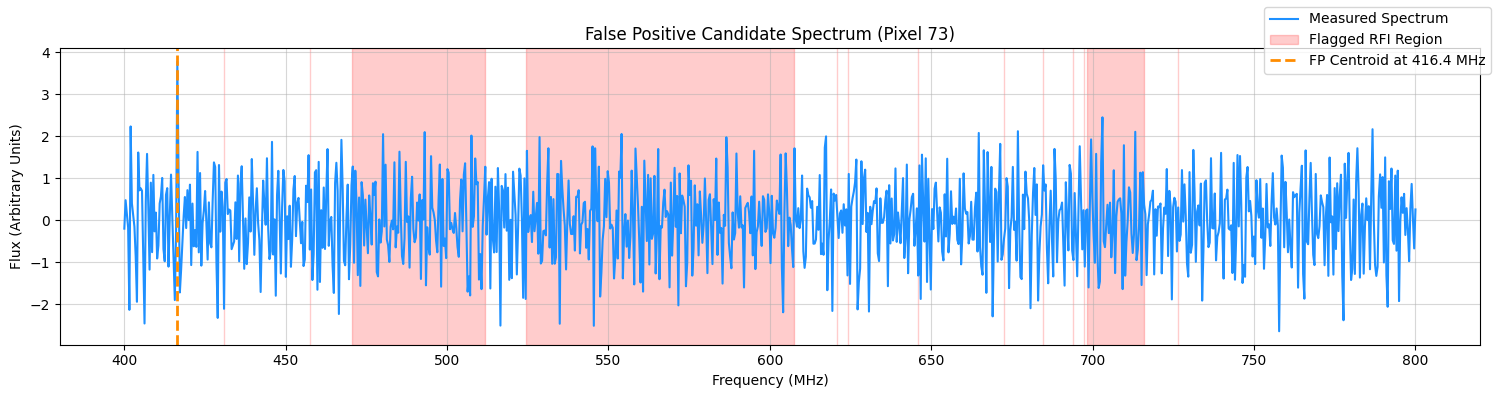

In [41]:
import numpy as np
import matplotlib.pyplot as plt

print("--- Displaying Sample Spectra for False Positive Candidates ---")

# We will use the 'false_positives' list from our matched_results_3d dictionary
if 'matched_results_3d' in locals() and len(matched_results_3d['false_positives']) > 0:
    
    # Select a few random false positives to inspect
    num_to_plot = min(4, len(matched_results_3d['false_positives']))
    fp_indices_to_plot = np.random.choice(len(matched_results_3d['false_positives']), num_to_plot, replace=False)
    
    # Create the plot
    fig, axes = plt.subplots(num_to_plot, 1, figsize=(15, 4 * num_to_plot), sharex=True, squeeze=False)
    axes = axes.flatten() # Ensure axes is always a 1D array

    for i, fp_idx in enumerate(fp_indices_to_plot):
        ax = axes[i]
        fp_cand = matched_results_3d['false_positives'][fp_idx]
        
        # --- THIS IS THE CORRECTED PART ---
        # Get the location of the false positive's centroid using the correct keys
        pixel_y = int(fp_cand['centroid_y'])
        pixel_x = int(fp_cand['centroid_x'])
        peak_freq_mhz = fp_cand['centroid_z_freq']
        pixel_1d_idx = np.ravel_multi_index((pixel_y, pixel_x), GRID_SHAPE)
        # ---------------------------------
        
        # Plot the spectrum from the data cube for this pixel
        ax.plot(FREQS_MHZ, delay_filtered_cube[pixel_1d_idx, :], color='dodgerblue', label='Measured Spectrum')
        
        # Highlight the flagged RFI regions in red
        flagged_indices = np.where(~rfi_mask_boolean)[0]
        for start in np.where(np.diff(flagged_indices) > 1)[0]:
            end_idx = flagged_indices[start]
            start_idx = flagged_indices[np.where(np.diff(flagged_indices) > 1)[0][np.where(np.where(np.diff(flagged_indices) > 1)[0] == start)[0][0]-1]+1] if start !=0 else flagged_indices[0]
            ax.axvspan(FREQS_MHZ[start_idx], FREQS_MHZ[end_idx], color='red', alpha=0.2, label='Flagged RFI Region' if i == 0 and start == np.where(np.diff(flagged_indices) > 1)[0][0] else "")

        # Mark the exact centroid of the false positive
        print(peak_freq_mhz)
        ax.axvline(peak_freq_mhz, color='darkorange', linestyle='--', lw=2, label=f'FP Centroid at {peak_freq_mhz:.1f} MHz')

        ax.set_title(f'False Positive Candidate Spectrum (Pixel {pixel_1d_idx})')
        ax.set_ylabel('Flux (Arbitrary Units)')
        ax.grid(True, alpha=0.5)

    ax.set_xlabel('Frequency (MHz)')
    fig.legend(loc='upper right')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

else:
    print("No false positives were found to plot.")

### 6.1: Diagnostic Plot 1: Candidate Overview Map

To get a visual sense of the search results, we plot a 2D map showing the maximum SNR in each pixel. On top of this, we mark the locations of the True Positives (correctly identified signals), False Positives (noise peaks mistaken for signals), and False Negatives (real signals that were missed).

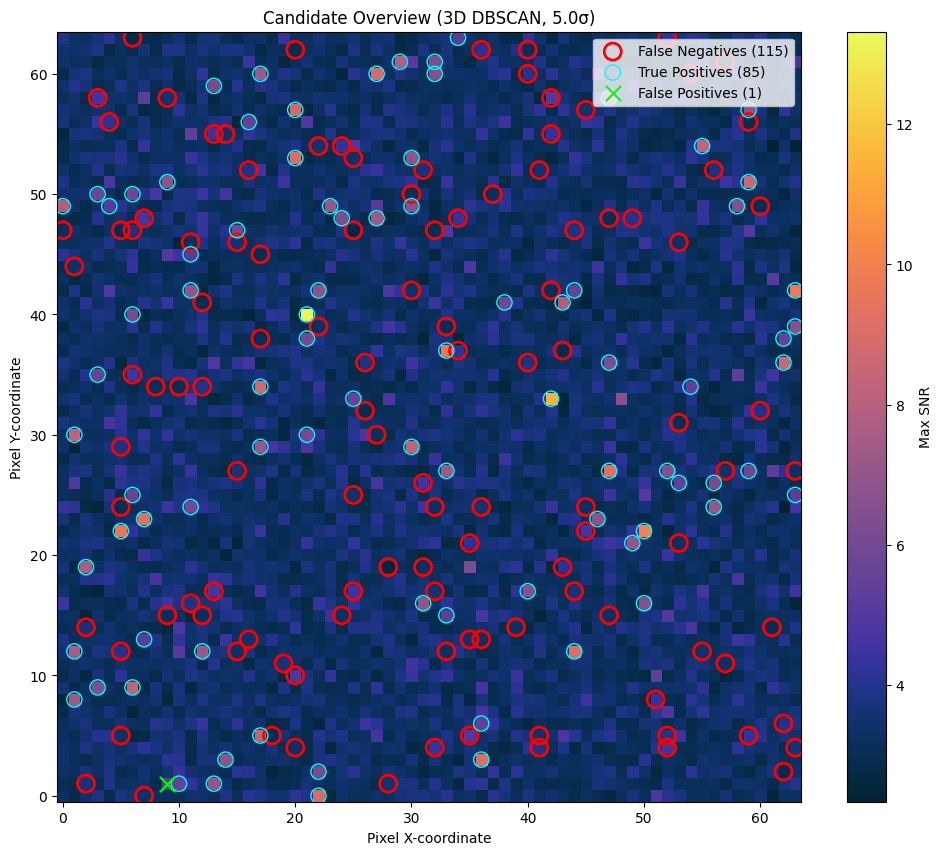

In [42]:
# For visualization, we create a 2D SNR map by taking the max along the frequency axis
snr_map_2d = np.max(snr_cube_3d, axis=1).reshape(GRID_SHAPE)

ocf.plot_performance_overview(
    snr_map=snr_map_2d,
    grid_shape=GRID_SHAPE,
    matched_results=matched_results_3d,
    title=f"Candidate Overview (3D DBSCAN, {SNR_THRESHOLD}σ)"
)

### 6.2: Diagnostic Plot 2: SNR Boost Validation

This is the most critical validation plot. A perfectly implemented matched filter should boost the SNR of a signal by a predictable amount, which is related to the template's energy. We can calculate this theoretical boost for every injected signal.

We then plot a histogram comparing the distribution of these **theoretical SNR boosts** with the **measured SNR boosts** from our pipeline (i.e., the peak SNR value at the location of each injected signal). 

**If the pipeline is working correctly, these two histograms should overlap almost perfectly.**

### The SNR Boost Validation Histogram: It's All About the Peak

For the SNR boost validation histogram (Diagnostic Plot 2), both the **theoretical** and the **measured** values are **Peak SNRs**.

Here’s why this is the correct and necessary choice for that plot:

* **What We Are Testing**: The specific goal of that histogram is to answer the question: "Is our matched filter implementation boosting the signal's peak amplitude by the exact amount predicted by the math?"
* **Theoretical Value**: The theoretical SNR we calculate (`(A_peak / σ_noise) * ||template||`) is explicitly a prediction of the **peak amplitude** of the filter's response. It's not an integrated value.
* **Measured Value**: To perform a direct, apples-to-apples comparison, we must therefore measure the equivalent value from our results. We look at the SNR cube and find the **peak SNR value** within the footprint of the true positive detection.

By comparing the **predicted peak** to the **measured peak**, the residual plot (`Measured - Theoretical`) directly shows how accurately our real-world code matches the ideal mathematical formula. If we were to compare a predicted peak to a measured integrated SNR, the comparison would be meaningless, as they are fundamentally different quantities.

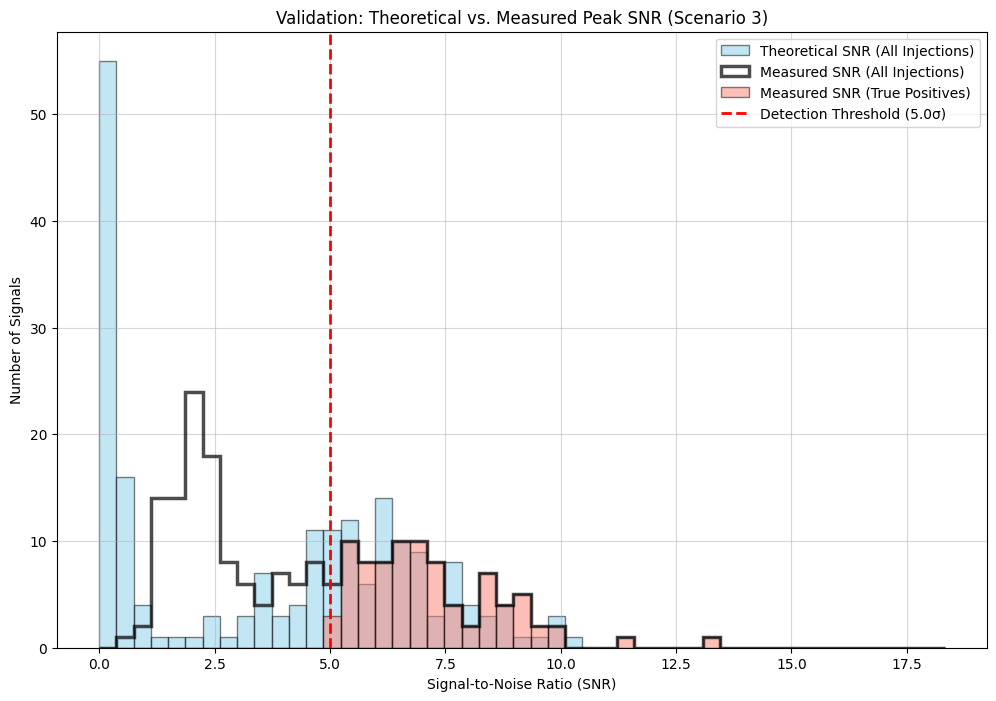

In [43]:
# --- SNR Boost Validation for Scenario 3 ---

# 1. THEORETICAL SNRs (Calculated in the previous cell)
# The `predicted_peak_snrs` list already contains the best possible SNR for each
# injected signal after accounting for delay filtering and RFI.
# We will rename it here for clarity.
theoretical_snrs_all_injections = predicted_peak_snrs

# 2. MEASURED SNRs (for ALL injected signals)
# We find the peak measured SNR in the final SNR cube at the location of each injection.
measured_snrs_all_injections = []
for g in ground_truth['injections']:
    noiseless_profile = g.get('noiseless_profile')
    if noiseless_profile is None: continue
    
    pixel_idx = g['pixel_index']
    # Find the frequency range where the original signal was injected
    signal_indices = np.where(noiseless_profile > 0)[0]
    
    if signal_indices.size > 0:
        # Get the SNR values from our final cube at this location
        snr_at_location = snr_cube_3d[pixel_idx, signal_indices]
        measured_snrs_all_injections.append(np.max(snr_at_location))
    else:
        measured_snrs_all_injections.append(0)

# 3. MEASURED SNRs (for TRUE POSITIVES only)
# These are the peak SNR values for the candidates that were successfully detected.
measured_snrs_true_positives = [m['cand']['peak_snr'] for m in matched_results_3d['true_positives']]

# --- Plotting ---
plt.figure(figsize=(12, 8))
max_val = max(np.max(theoretical_snrs_all_injections), np.max(measured_snrs_all_injections))
bins = np.linspace(0, max_val + 5, 50)

# Plot the three histograms
plt.hist(theoretical_snrs_all_injections, bins=bins, alpha=0.5, label='Theoretical SNR (All Injections)', color='skyblue', edgecolor='black')
plt.hist(measured_snrs_all_injections, bins=bins, alpha=0.7, label='Measured SNR (All Injections)', color='mediumseagreen', edgecolor='black', histtype='step', linewidth=2.5)
plt.hist(measured_snrs_true_positives, bins=bins, alpha=0.5, label='Measured SNR (True Positives)', color='salmon', edgecolor='black')

plt.axvline(SNR_THRESHOLD, color='r', linestyle='--', linewidth=2, label=f'Detection Threshold ({SNR_THRESHOLD}σ)')
plt.xlabel('Signal-to-Noise Ratio (SNR)')
plt.ylabel('Number of Signals')
plt.title('Validation: Theoretical vs. Measured Peak SNR (Scenario 3)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

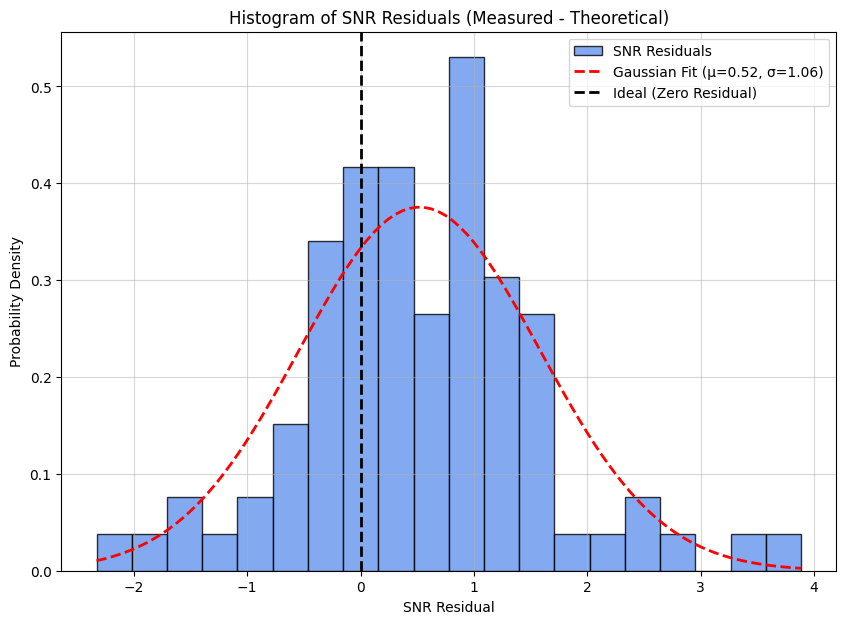

The mean of the residuals is 0.521, which indicates the remaining systematic bias in the measurement.
The standard deviation of the residuals is 1.063, which indicates the random error in our SNR measurement.


In [44]:
# --- SNR Residuals for Scenario 3 ---

# We need to match the 'true_positives' back to their original index
# to find their corresponding theoretical SNR from our prediction list.
# We can create a quick lookup map for this.
true_positive_injections = [m['inj'] for m in matched_results_3d['true_positives']]

# --- Calculate Residuals for True Positives ---
residuals = []
for i, g_truth in enumerate(ground_truth['injections']):
    # Check if this injection was one of the ones we successfully found
    if any(g_truth is inj for inj in true_positive_injections):
        
        # Find the corresponding 'match' dictionary
        match = next(m for m in matched_results_3d['true_positives'] if m['inj'] is g_truth)
        
        # Get the measured SNR from the candidate
        measured_snr = match['cand']['peak_snr']
        
        # Get the corresponding end-to-end theoretical SNR we already calculated
        theoretical_snr = predicted_peak_snrs[i]
        
        # The residual is the difference
        residuals.append(measured_snr - theoretical_snr)

# --- Plotting the Residuals ---
if residuals:
    plt.figure(figsize=(10, 7))

    # Plot the histogram of residuals
    plt.hist(residuals, bins=20, density=True, color='cornflowerblue', edgecolor='black', alpha=0.8, label='SNR Residuals')

    # Fit a Gaussian to the distribution to find the mean and std dev
    mu, std = norm.fit(residuals)
    x = np.linspace(min(residuals), max(residuals), 100)
    plt.plot(x, norm.pdf(x, mu, std), 'r--', linewidth=2, label=f'Gaussian Fit (μ={mu:.2f}, σ={std:.2f})')

    plt.axvline(0, color='k', linestyle='--', linewidth=2, label='Ideal (Zero Residual)')
    plt.title('Histogram of SNR Residuals (Measured - Theoretical)')
    plt.xlabel('SNR Residual')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

    print(f"The mean of the residuals is {mu:.3f}, which indicates the remaining systematic bias in the measurement.")
    print(f"The standard deviation of the residuals is {std:.3f}, which indicates the random error in our SNR measurement.")
else:
    print("No true positives were found, so no residuals to plot.")

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


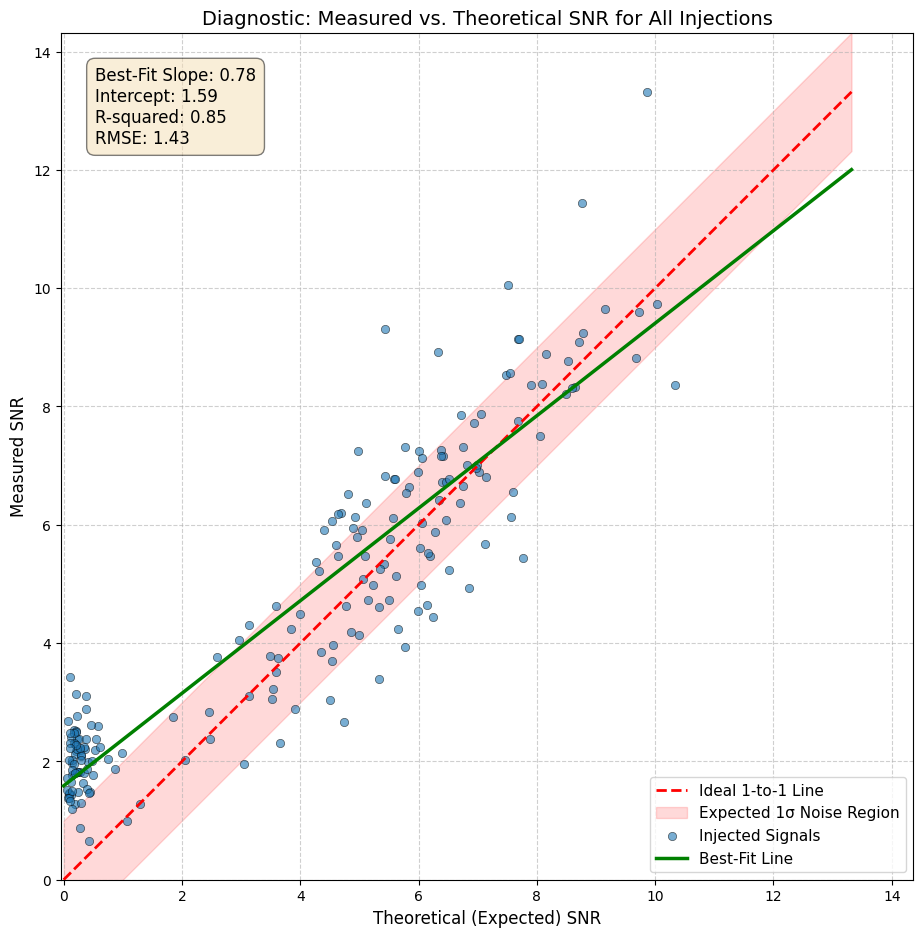


--- Higher Moment Analysis of SNR Residuals (Measured - Theoretical) ---
Skewness: -0.332
Kurtosis: -0.314

What these statistics tell us:
  - Skewness: Measures the asymmetry of the error distribution.
    - A value near 0 indicates a symmetric distribution of errors, which is ideal.
    - Positive Skew (> 0): There are more unexpectedly HIGH measured SNRs than low ones. This could indicate un-modeled RFI or constructive noise interference.
    - Negative Skew (< 0): There are more unexpectedly LOW measured SNRs. This points to a systematic signal loss that the theoretical model doesn't account for.

  - Kurtosis: Measures the 'tailedness' or presence of outliers compared to a Gaussian distribution.
    - A value near 0 means the error distribution has tails similar to a perfect Gaussian.
    - Positive Kurtosis (> 0): The distribution has 'heavy tails,' meaning there are more extreme outliers (both high and low) than expected from pure Gaussian noise. This is a strong sign of non-Ga

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- 1. Prepare Data for Analysis ---
theoretical = np.array(theoretical_snrs_all_injections)
measured = np.array(measured_snrs_all_injections)

# --- 2. Calculate Diagnostic Statistics ---
# Linear regression for systematic bias
lin_reg = stats.linregress(theoretical, measured)
slope, intercept, r_value = lin_reg.slope, lin_reg.intercept, lin_reg.rvalue

# Root Mean Squared Error for overall error magnitude
rmse = np.sqrt(np.mean((measured - theoretical)**2))

# Calculate the residuals (the difference between measured and expected)
residuals = measured - theoretical

# Higher Moments for distribution shape analysis
skewness = stats.skew(residuals)
kurtosis = stats.kurtosis(residuals) # Fisher's definition (normal = 0)

# --- 3. Create the Scatter Plot ---
plt.figure(figsize=(11, 11))

# The ideal 1-to-1 line
max_val = max(theoretical.max(), measured.max())
ideal_line = np.array([0, max_val])
plt.plot(ideal_line, ideal_line, 'r--', lw=2, label="Ideal 1-to-1 Line", zorder=3)

# --- NEW: Add a 1-sigma region around the ideal line ---
# This shaded area represents where points should fall due to noise alone.
plt.fill_between(ideal_line, ideal_line - 1, ideal_line + 1, color='red',
                 alpha=0.15, label="Expected 1σ Noise Region", zorder=1)

# The main scatter plot
plt.scatter(theoretical, measured, alpha=0.6, edgecolors='k', linewidth=0.5,
            label="Injected Signals", zorder=2)

# The best-fit line from our linear regression
fit_line_y = slope * ideal_line + intercept
plt.plot(ideal_line, fit_line_y, 'g-', lw=2.5, label="Best-Fit Line", zorder=4)

# --- 4. Add Statistics and Labels ---
stats_text = (
    f"Best-Fit Slope: {slope:.2f}\n"
    f"Intercept: {intercept:.2f}\n"
    f"R-squared: {r_value**2:.2f}\n"
    f"RMSE: {rmse:.2f}"
)
plt.text(0.04, 0.96, stats_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

plt.xlabel("Theoretical (Expected) SNR", fontsize=12)
plt.ylabel("Measured SNR", fontsize=12)
plt.title("Diagnostic: Measured vs. Theoretical SNR for All Injections", fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.xlim(0, max_val + 1)
plt.ylim(0, max_val + 1)
plt.show()

# --- 5. Print and Explain Higher Moments ---
print("\n--- Higher Moment Analysis of SNR Residuals (Measured - Theoretical) ---")
print(f"Skewness: {skewness:.3f}")
print(f"Kurtosis: {kurtosis:.3f}\n")

print("What these statistics tell us:")
print("  - Skewness: Measures the asymmetry of the error distribution.")
print("    - A value near 0 indicates a symmetric distribution of errors, which is ideal.")
print("    - Positive Skew (> 0): There are more unexpectedly HIGH measured SNRs than low ones. This could indicate un-modeled RFI or constructive noise interference.")
print("    - Negative Skew (< 0): There are more unexpectedly LOW measured SNRs. This points to a systematic signal loss that the theoretical model doesn't account for.\n")

print("  - Kurtosis: Measures the 'tailedness' or presence of outliers compared to a Gaussian distribution.")
print("    - A value near 0 means the error distribution has tails similar to a perfect Gaussian.")
print("    - Positive Kurtosis (> 0): The distribution has 'heavy tails,' meaning there are more extreme outliers (both high and low) than expected from pure Gaussian noise. This is a strong sign of non-Gaussian noise or intermittent RFI.")
print("    - Negative Kurtosis (< 0): The distribution is 'flat' with very few outliers.")

### 6.3: Diagnostic Plot 3: Data and SNR Cube Histograms

This plot shows the distribution of values in our original data cube and the final SNR cube. It provides another essential sanity check:

1.  **Data Cube (Noise)**: Since our input data is dominated by Gaussian noise with σ=1, its histogram should look like a standard normal distribution centered at 0.
2.  **SNR Cube (Noise)**: The SNR cube, in regions without signals, represents the output of the matched filter applied to pure noise. The distribution of these noise values should also be a Gaussian centered at 0, but its standard deviation will depend on the filter properties. For an optimal filter, we expect σ≈1.

A significant deviation from a Gaussian distribution in the SNR cube's noise could indicate a problem with the matched filter implementation.

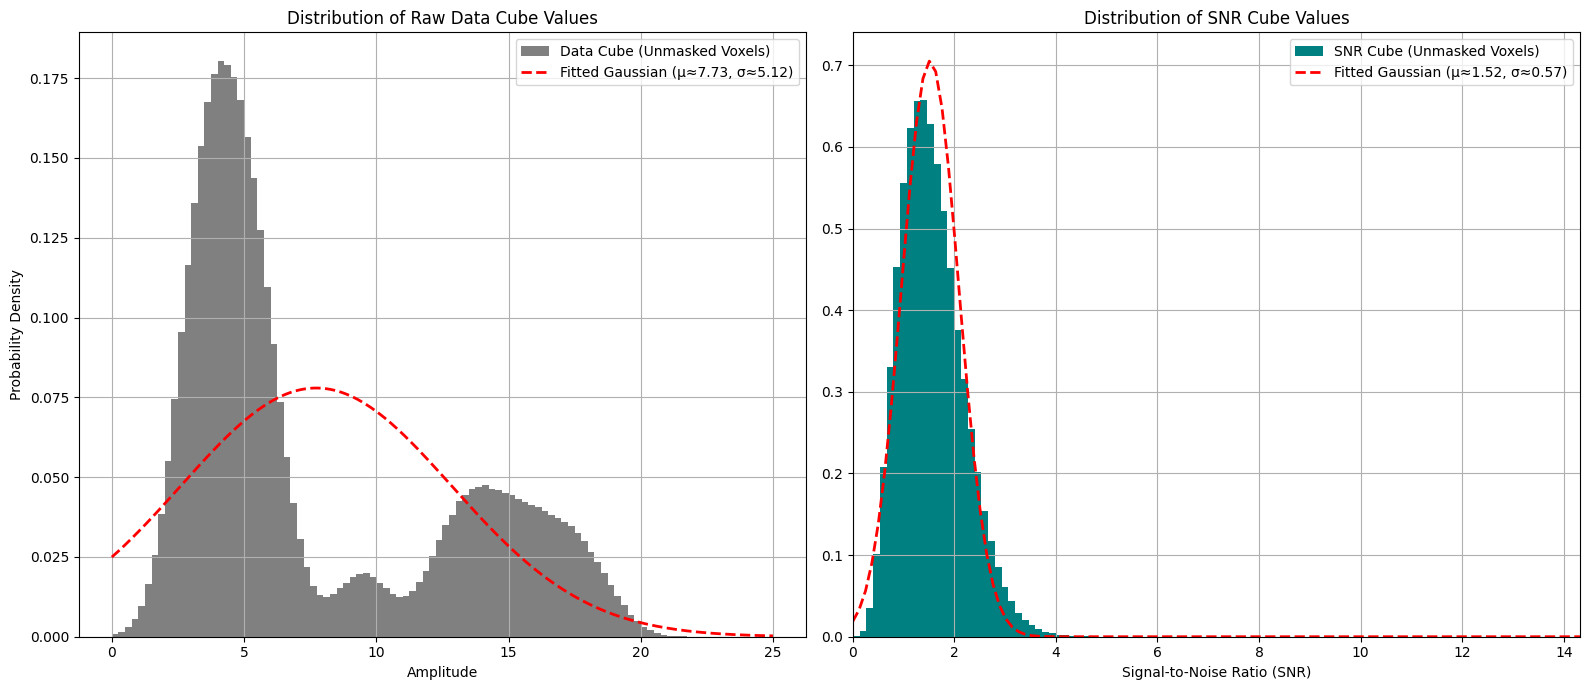

In [46]:
# --- We will now plot only the non-zero data to ignore the RFI-masked channels ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Isolate the non-zero data from both cubes ---
data_cube_live_voxels = data_cube[data_cube != 0].flatten()
snr_cube_live_voxels = snr_cube_3d[snr_cube_3d != 0].flatten()


# --- Histogram of the raw data cube ---
ax1.hist(data_cube_live_voxels, bins=100, range=(0, 25), density=True, label='Data Cube (Unmasked Voxels)', color='gray')
x = np.linspace(0, 25, 200)

# Compare to a Gaussian fit of the live data
mu_data, std_data = norm.fit(data_cube_live_voxels)
ax1.plot(x, norm.pdf(x, mu_data, std_data), 'r--', linewidth=2, label=f'Fitted Gaussian (μ≈{mu_data:.2f}, σ≈{std_data:.2f})')

ax1.set_title('Distribution of Raw Data Cube Values')
ax1.set_xlabel('Amplitude')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.grid(True)

# --- Histogram of the SNR cube ---
ax2.hist(snr_cube_live_voxels, bins=100, density=True, label='SNR Cube (Unmasked Voxels)', color='teal')

# We only fit the Gaussian to the noise part (SNR < 3)
noise_snrs = snr_cube_live_voxels[snr_cube_live_voxels < 3]
mu_snr, std_snr = norm.fit(noise_snrs)
ax2.plot(x, norm.pdf(x, mu_snr, std_snr), 'r--', linewidth=2, label=f'Fitted Gaussian (μ≈{mu_snr:.2f}, σ≈{std_snr:.2f})')

ax2.set_title('Distribution of SNR Cube Values')
ax2.set_xlabel('Signal-to-Noise Ratio (SNR)')
# ax2.set_yscale('log')
ax2.set_xlim(0,snr_cube_live_voxels.max()+1)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Show the delay filtered version

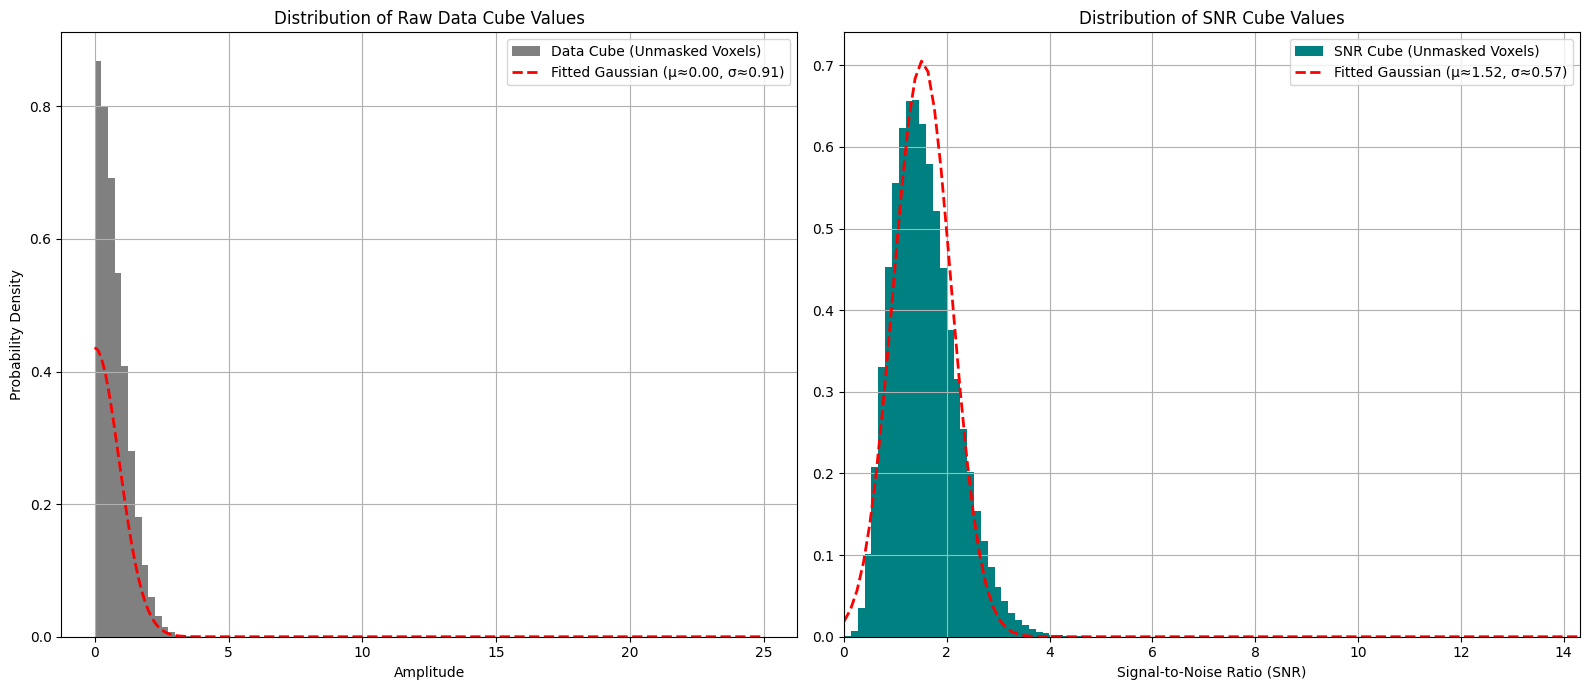

In [47]:
# --- We will now plot only the non-zero data to ignore the RFI-masked channels ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Isolate the non-zero data from both cubes ---
data_cube_live_voxels = delay_filtered_cube[delay_filtered_cube != 0].flatten()
snr_cube_live_voxels = snr_cube_3d[snr_cube_3d != 0].flatten()


# --- Histogram of the raw data cube ---
ax1.hist(data_cube_live_voxels, bins=100, range=(0, 25), density=True, label='Data Cube (Unmasked Voxels)', color='gray')
x = np.linspace(0, 25, 200)

# Compare to a Gaussian fit of the live data
mu_data, std_data = norm.fit(data_cube_live_voxels)
ax1.plot(x, norm.pdf(x, mu_data, std_data), 'r--', linewidth=2, label=f'Fitted Gaussian (μ≈{mu_data:.2f}, σ≈{std_data:.2f})')

ax1.set_title('Distribution of Raw Data Cube Values')
ax1.set_xlabel('Amplitude')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.grid(True)

# --- Histogram of the SNR cube ---
ax2.hist(snr_cube_live_voxels, bins=100, density=True, label='SNR Cube (Unmasked Voxels)', color='teal')

# We only fit the Gaussian to the noise part (SNR < 3)
noise_snrs = snr_cube_live_voxels[snr_cube_live_voxels < 3]
mu_snr, std_snr = norm.fit(noise_snrs)
ax2.plot(x, norm.pdf(x, mu_snr, std_snr), 'r--', linewidth=2, label=f'Fitted Gaussian (μ≈{mu_snr:.2f}, σ≈{std_snr:.2f})')

ax2.set_title('Distribution of SNR Cube Values')
ax2.set_xlabel('Signal-to-Noise Ratio (SNR)')
# ax2.set_yscale('log')
ax2.set_xlim(0,snr_cube_live_voxels.max()+1)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


The underlying correlation `(data * template)` can be negative. However, the final `snr_cube_3d` contains no negative values because of a single line in our search loop:

```python
update_mask = snr > current_snr_segment
```

Here’s the step-by-step logic that explains why this line eliminates all negative values:

1.  **Initialization**: For each pixel, we start with a blank slate: `pixel_snr_spectrum` is an array filled entirely with zeros.
2.  **SNR Calculation**: We calculate the `snr` for a specific template. This value can indeed be positive (if the noise happens to look like the template) or negative (if the noise is anti-correlated).
3.  **The "Greater Than" Check**: The crucial step is the comparison. We only update the values in our `pixel_snr_spectrum` if the new `snr` is **greater than** the value that's already there.
4.  **The Result**:
      * If a calculated `snr` is **negative**, it will never be greater than the zero it's being compared to. The `update_mask` will be `False`, and the negative value is effectively thrown away.
      * If a calculated `snr` is **positive**, it will be greater than zero, and it gets "painted" onto the `pixel_snr_spectrum`.

So, even though we are technically calculating negative SNRs millions of time throughout the search, our code is explicitly designed to **only store the positive-going results**. We are intentionally building a map of where the noise looks *like* our signal, not where it looks like the inverse of our signal.

### Part 7: ROC Curve Performance Comparison

A **Receiver Operating Characteristic (ROC)** curve is a powerful tool for evaluating the performance of a detection algorithm. It plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various threshold settings.

  * **True Positive Rate (TPR)**, or "Completeness": The fraction of real signals that are correctly identified. (TP / Total Real Signals)
  * **False Positive Rate (FPR)**: The fraction of non-signals (i.e., noise) that are incorrectly flagged as detections. (FP / Total Non-Signals)

A perfect classifier would have a point in the top-left corner (TPR=1, FPR=0), while a random guess would fall along the diagonal line (TPR=FPR). The further a curve bows towards the top-left, the better the algorithm's performance.

In this cell, we will compare four different search methods:

1.  **Simple Threshold Search**: Our baseline, flagging any voxel in the raw data cube that exceeds a threshold.
2.  **Gaussian Template Matched Filter**: A search using a simple Gaussian profile as a template. This tests the benefit of matched filtering in its most basic form.
3.  **Single OHM Template Matched Filter**: An intermediate step where we use a matched filter, but with only *one* "typical" (and more complex) OHM template.
4.  **Full OHM Template Bank**: The complete pipeline, which uses a bank of templates tailored to different redshifts.

We expect to see a clear hierarchy of performance, with the full template bank being the best. We also add annotated markers at integer sigma levels to show exactly where our chosen operating points lie on these curves.

In [48]:
# --- ROC Curve Generation for Scenario 3 (using Dayenu Filter) ---
print("--- Generating Data for ROC Curves (Dayenu Filter) ---")

# Define the thresholds to test
roc_thresholds = np.linspace(0, 15, 50)
n_total_positives = N_INJECTIONS

# --- Get the ground truth locations of the signals (no changes needed) ---
injection_mask = np.zeros_like(delay_filtered_cube, dtype=bool)
for g in ground_truth['injections']:
    noiseless_profile = g.get('noiseless_profile')
    if noiseless_profile is None: continue
    pixel_idx = g['pixel_index']
    inj_freq_indices = np.where(noiseless_profile > 0)[0]
    if inj_freq_indices.size > 0:
        injection_mask[pixel_idx, inj_freq_indices] = True
noise_mask = ~injection_mask
n_noise_voxels = np.sum(noise_mask)

# Ensure the per-channel noise spectrum is in memory
if 'noise_spectrum' not in locals():
    print("Warning: 'noise_spectrum' not found. Estimating from filtered cube.")
    noise_spectrum = np.nanstd(delay_filtered_cube, axis=0)
    noise_spectrum[np.isnan(noise_spectrum) | (noise_spectrum <= 0)] = 1e-9

# --- Initialize the cache for the Dayenu filter ---
# This ensures the filter matrix is only calculated once per unique weight array
filter_cache = {}


# --- Method 1: Simple Threshold on Raw Data (no change needed) ---
print("\n1/4: Generating Simple Threshold SNR Cube...")
snr_cube_simple = delay_filtered_cube / noise_spectrum
tpr_simple, fpr_simple = [], []
for thresh in tqdm(roc_thresholds, desc="Simple Threshold"):
    tp = np.sum(snr_cube_simple[injection_mask] > thresh)
    fp = np.sum(snr_cube_simple[noise_mask] > thresh)
    tpr_simple.append(tp / n_total_positives)
    fpr_simple.append(fp / n_noise_voxels)


# --- Method 2: Gaussian Template Matched Filter (UPDATED for Dayenu) ---
print("\n2/4: Building Gaussian Template Bank (Dayenu)...")
# Step 1: Create the base Gaussian profile and pad it to full size.
gauss_template_short = otg.generate_gaussian_template(width=18, sigma_fraction=0.15)
gauss_template_full = np.zeros(N_CHANNELS)
center_idx = N_CHANNELS // 2
start_idx = center_idx - len(gauss_template_short) // 2
end_idx = start_idx + len(gauss_template_short)
gauss_template_full[start_idx:end_idx] = gauss_template_short

# Step 2: Apply the Dayenu filter to the full-sized template.
# CORRECTED: First call the function, then slice the resulting array.
filtered_gauss_full, _ = oss.apply_dayneu_filter(
    spectrum=gauss_template_full,
    weights=np.ones(N_CHANNELS), # Templates are ideal, so use uniform weights
    frequencies_mhz=FREQS_MHZ,
    delay_cutoff_ns=DELAY_CUT_NS,
    cache=filter_cache
)
filtered_gauss_template_short = filtered_gauss_full[start_idx:end_idx]

# Step 3: Create a template bank by "sliding" the template.
gaussian_template_bank = []
template_width = len(filtered_gauss_template_short)
for i in range(N_CHANNELS - template_width + 1):
    gaussian_template_bank.append({'prof': filtered_gauss_template_short, 'start': i, 'end': i + template_width})

# Step 4: Run the standardized search.
print("Generating Gaussian Template SNR Cube (Dayenu)...")
snr_cube_gauss, _ = oss.run_matched_filter_search(
    data_cube=delay_filtered_cube, templates=gaussian_template_bank, noise_spectrum=noise_spectrum
)

tpr_gauss, fpr_gauss = [], []
for thresh in tqdm(roc_thresholds, desc="Gaussian Template (Dayenu)"):
    tp = np.sum(snr_cube_gauss[injection_mask] > thresh)
    fp = np.sum(snr_cube_gauss[noise_mask] > thresh)
    tpr_gauss.append(tp / n_total_positives)
    fpr_gauss.append(fp / n_noise_voxels)


# --- Method 3: Single OHM Template (UPDATED for Dayenu) ---
print("\n3/4: Building Single OHM Template Bank (Dayenu)...")
z_single = 2.0
compact_template, start, end = otg.process_to_native_resolution_and_target_z(
    intrinsic_template_v=intrinsic_template_v, vel_axis_kms=VEL_AXIS, z=z_single, native_freq_grid=FREQS_MHZ
)

# CORRECTED: Apply Dayenu filter correctly before creating the bank.
full_template = otg.create_full_spectrum_template(compact_template, start, end, N_CHANNELS)
filtered_full, _ = oss.apply_dayneu_filter(
    spectrum=full_template, weights=np.ones(N_CHANNELS), frequencies_mhz=FREQS_MHZ, delay_cutoff_ns=DELAY_CUT_NS, cache=filter_cache
)
filtered_compact_template = filtered_full[start:end]

single_ohm_template_bank = []
template_width = len(filtered_compact_template)
for i in range(N_CHANNELS - template_width + 1):
    single_ohm_template_bank.append({'prof': filtered_compact_template, 'start': i, 'end': i + template_width})

print("Generating Single OHM Template SNR Cube (Dayenu)...")
snr_cube_single, _ = oss.run_matched_filter_search(
    data_cube=delay_filtered_cube, templates=single_ohm_template_bank, noise_spectrum=noise_spectrum
)

tpr_single, fpr_single = [], []
for thresh in tqdm(roc_thresholds, desc="Single OHM Template (Dayenu)"):
    tp = np.sum(snr_cube_single[injection_mask] > thresh)
    fp = np.sum(snr_cube_single[noise_mask] > thresh)
    tpr_single.append(tp / n_total_positives)
    fpr_single.append(fp / n_noise_voxels)


# --- Method 4: Full Template Bank (using the pre-computed Dayenu SNR cube) ---
print("\n4/4: Calculating stats for Full Template Bank (Dayenu)...")
# This uses snr_cube_3d, which should have been calculated with the Dayenu-filtered templates.
tpr_bank, fpr_bank = [], []
for thresh in tqdm(roc_thresholds, desc="Full Template Bank (Dayenu)"):
    tp = np.sum(snr_cube_3d[injection_mask] > thresh)
    fp = np.sum(snr_cube_3d[noise_mask] > thresh)
    tpr_bank.append(tp / n_total_positives)
    fpr_bank.append(fp / n_noise_voxels)

--- Generating Data for ROC Curves (Dayenu Filter) ---

1/4: Generating Simple Threshold SNR Cube...


Simple Threshold:   0%|          | 0/50 [00:00<?, ?it/s]


2/4: Building Gaussian Template Bank (Dayenu)...
Generating Gaussian Template SNR Cube (Dayenu)...
--- Running Matched Filter Search ---


Processing Pixels:   0%|          | 0/4096 [00:00<?, ?it/s]


SNR cube generation complete.


Gaussian Template (Dayenu):   0%|          | 0/50 [00:00<?, ?it/s]


3/4: Building Single OHM Template Bank (Dayenu)...
Generating Single OHM Template SNR Cube (Dayenu)...
--- Running Matched Filter Search ---


Processing Pixels:   0%|          | 0/4096 [00:00<?, ?it/s]


SNR cube generation complete.


Single OHM Template (Dayenu):   0%|          | 0/50 [00:00<?, ?it/s]


4/4: Calculating stats for Full Template Bank (Dayenu)...


Full Template Bank (Dayenu):   0%|          | 0/50 [00:00<?, ?it/s]

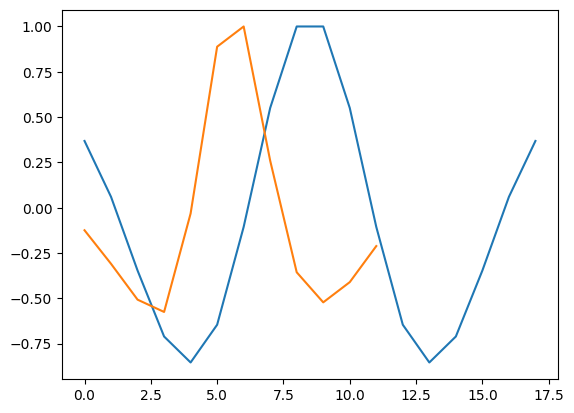

In [49]:
plt.plot(filtered_gauss_template_short/filtered_gauss_template_short.max())
plt.plot(filtered_compact_template/filtered_compact_template.max())

In [50]:
# --- Part 8: Computationally Intensive, Object-Based ROC Curve (Corrected) ---
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

print("--- Generating Data for Computationally Intensive ROC Curve ---")
print("Warning: This may take a significant amount of time.")

# Use a coarser set of thresholds to make the run time more manageable
roc_thresholds_intensive = np.linspace(5.0, 11.0, 25) 

# The total number of "positive" cases is the number of injected signals
n_total_positives = N_INJECTIONS
# The total number of "negative" cases is effectively the number of independent sightlines
n_total_negatives = N_PIXELS 

# Store the results for each method
all_roc_results = {}

# --- THIS IS THE FIRST FIX ---
# Create the correctly normalized SNR cube for the "Simple Threshold" method
snr_cube_simple = delay_filtered_cube / noise_spectrum
# -----------------------------

# We need the four data cubes from the previous analysis
all_cubes_to_test = [
    ("Simple Threshold", snr_cube_simple), # Use the corrected cube here
    ("Gaussian Template", snr_cube_gauss),
    ("Single OHM Template", snr_cube_single),
    ("Full OHM Template Bank", snr_cube_3d)
]

# Main loop over each of the four methods
for name, cube in all_cubes_to_test:
    tpr_list, fpr_list = [], []
    print(f"\nProcessing method: {name}")
    
    # Loop over each threshold value
    for thresh in tqdm(roc_thresholds_intensive, desc=f"Testing Thresholds for {name}"):
        
        # --- THIS IS THE SECOND FIX ---
        # 1. Find candidates using the full 3D clustering algorithm, now with freqs_mhz
        found_candidates = ocf.find_candidates_3d_dbscan(
            snr_cube=cube.reshape(GRID_SHAPE + (len(FREQS_MHZ),)),
            snr_threshold=thresh,
            eps=DBSCAN_EPS,
            min_samples=DBSCAN_MIN_SAMPLES,
            freqs_mhz=FREQS_MHZ # Pass the frequency axis
        )
        # ---------------------------
        
        # 2. Match candidates to ground truth to get TP/FP counts
        if len(found_candidates) > 0:
            # Vetting step to remove candidates outside the band or in RFI zones
            vetted_candidates = []
            for cand in found_candidates:
                centroid_freq = cand['centroid_z_freq']
                is_in_band = (FREQS_MHZ.min() <= centroid_freq <= FREQS_MHZ.max())
                if not is_in_band: continue
                freq_idx = np.argmin(np.abs(FREQS_MHZ - centroid_freq))
                is_in_clean_channel = rfi_mask_boolean[freq_idx]
                if not is_in_clean_channel: continue
                vetted_candidates.append(cand)

            matched_results = ocf.match_candidates_to_truth_3d(
                candidates=vetted_candidates,
                ground_truth=ground_truth,
                grid_shape=GRID_SHAPE,
                freqs_mhz=FREQS_MHZ
            )
            n_tp = len(matched_results['true_positives'])
            n_fp = len(matched_results['false_positives'])
        else:
            n_tp = 0
            n_fp = 0
            
        # 3. Calculate and store the rates
        tpr = n_tp / n_total_positives if n_total_positives > 0 else 0
        fpr = n_fp / n_total_negatives if n_total_negatives > 0 else 0
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        
    all_roc_results[name] = {'tpr': np.array(tpr_list), 'fpr': np.array(fpr_list)}

--- Generating Data for Computationally Intensive ROC Curve ---

Processing method: Simple Threshold


Testing Thresholds for Simple Threshold:   0%|          | 0/25 [00:00<?, ?it/s]


Processing method: Gaussian Template


Testing Thresholds for Gaussian Template:   0%|          | 0/25 [00:00<?, ?it/s]


Processing method: Single OHM Template


Testing Thresholds for Single OHM Template:   0%|          | 0/25 [00:00<?, ?it/s]


Processing method: Full OHM Template Bank


Testing Thresholds for Full OHM Template Bank:   0%|          | 0/25 [00:00<?, ?it/s]

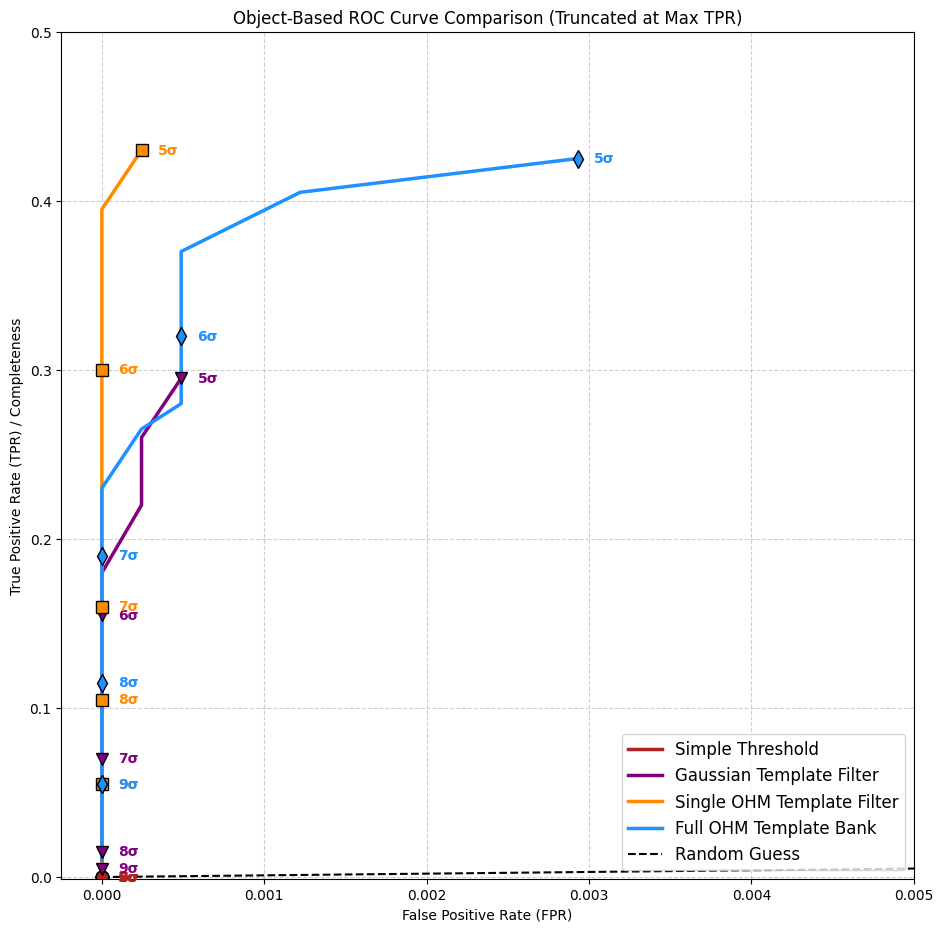

In [85]:
# --- Final ROC Plotting ---
plt.figure(figsize=(11, 11))
ax = plt.gca()

# --- Define the visible area of the plot FIRST ---
xlim = (-0.00025, 0.005)
ylim = (-0.001, 0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# --- Data for plotting ---
all_curves_data = [
    (all_roc_results['Simple Threshold'], 'Simple Threshold', 'firebrick', 'o'),
    (all_roc_results['Gaussian Template'], 'Gaussian Template Filter', 'purple', 'v'),
    (all_roc_results['Single OHM Template'], 'Single OHM Template Filter', 'darkorange', 's'),
    (all_roc_results['Full OHM Template Bank'], 'Full OHM Template Bank', 'dodgerblue', 'd')
]

# --- Main Plotting Loop with Robust Truncation Logic ---
for results, label, color, marker in all_curves_data:
    # Reverse the arrays so they run from (0,0) towards (1,1)
    fpr_vals = results['fpr'][::-1]
    tpr_vals = results['tpr'][::-1]

    # Find the maximum TPR value achieved by this curve
    max_tpr = np.max(tpr_vals)
    
    # Find the index of the FIRST time this maximum TPR is reached
    knee_idx_list = np.where(tpr_vals >= max_tpr * 0.999)[0]
    
    if len(knee_idx_list) > 0:
        knee_idx = knee_idx_list[0]
        # Plot the data only up to and including this "knee"
        ax.plot(fpr_vals[:knee_idx+1], tpr_vals[:knee_idx+1], label=label, color=color, lw=2.5)
    else:
        # If for some reason no point reaches the max, plot the whole thing
        ax.plot(fpr_vals, tpr_vals, label=label, color=color, lw=2.5)


# Plot the random guess line
ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# --- Add annotated sigma markers with boundary checks ---
sigma_markers = range(5, 10) # From 3 to 10 sigma
reversed_thresholds = roc_thresholds_intensive[::-1]

for sigma in sigma_markers:
    # Find the index in our REVERSED threshold array closest to the target sigma
    idx = (np.abs(reversed_thresholds - sigma)).argmin()
    
    for results, label, color, marker in all_curves_data:
        # Get the data points from the REVERSED arrays
        fpr_at_sigma = results['fpr'][::-1][idx]
        tpr_at_sigma = results['tpr'][::-1][idx]
        
        # --- THIS IS THE FIX ---
        # Only plot the marker and text if it falls within our predefined x and y limits.
        if xlim[0] <= fpr_at_sigma <= xlim[1] and ylim[0] <= tpr_at_sigma <= ylim[1]:
            ax.plot(fpr_at_sigma, tpr_at_sigma, marker, color=color, markersize=9, markeredgecolor='black')
            ax.text(fpr_at_sigma + 0.0001, tpr_at_sigma, f'{sigma}σ', 
                    color=color, fontsize=10, ha='left', va='center', weight='bold')

# --- Final plot settings ---
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR) / Completeness')
ax.set_title('Object-Based ROC Curve Comparison (Truncated at Max TPR)')
ax.legend(loc='lower right', fontsize=12)
ax.grid(True, which="both", ls="--", alpha=0.6)
fig.savefig('ROC_scenario_3.jpeg', dpi=300)

plt.show()

---
### A Figure of Merit: The ROC Curve from Radar to Radio Astronomy

To truly understand how well our search pipeline performs, we need a "figure of merit"—a single, quantitative measure of its effectiveness. While metrics like **completeness** and **purity** are informative for a *single* threshold, they don't capture the full picture of the trade-offs involved in a detection algorithm. The **Receiver Operating Characteristic (ROC)** curve provides this complete picture.

#### From Radar Engineering to the Cosmos 📡

The ROC curve was originally developed during World War II for operators of **radar** signal receivers. The fundamental problem they faced is identical to ours in radio astronomy: how do you set your detection threshold to reliably distinguish a faint, real signal (an enemy aircraft) from the ever-present background noise (atmospheric static, instrument noise)?

* Set the threshold **too low**, and you get a high **completeness** (you find every real aircraft), but you are flooded with **false positives** (you mistake noise for an aircraft), making the system useless.
* Set the threshold **too high**, and your **purity** is perfect (every detection is real), but your **completeness** is terrible (you miss most of the real aircraft).

The ROC curve was born from this trade-off. By plotting the **True Positive Rate** (TPR, or completeness) against the **False Positive Rate** (FPR) for every possible threshold setting, radar engineers could visualize the full performance space of their system.

#### Connecting to Radio Astronomy

This concept translates perfectly to our OHM search. An "aircraft" is a real OH megamaser, and the "noise" is the thermal noise of the telescope and the radio sky. The mathematical framework is identical.

* **False Positive Rate (FPR)**: In radar, this is the probability of a false alarm. In our search, it's the rate at which random noise fluctuations cross our SNR threshold.
* **True Positive Rate (TPR)**: In radar, this is the probability of detection. For us, it's our search **completeness**.

The goal is to have a curve that pushes as far as possible into the top-left corner, which signifies a high TPR for a very low FPR. By comparing the ROC curves of different search algorithms—like our simple threshold vs. our template bank—we can definitively prove which method is superior. It's not just about how many signals we find at a single 7σ threshold; it's about which method gives us the highest completeness for the *lowest possible cost* in false alarms across all possible thresholds. This robust, historical technique gives us the ultimate figure of merit for our search pipeline.

In [52]:
import numpy as np

def find_sigma_for_fpr(target_fpr, fpr_data, threshold_data):
    """
    Finds the sigma threshold that corresponds to a desired False Positive Rate (FPR).

    This function searches the results from an ROC curve analysis to find the lowest
    sigma value that produces a False Positive Rate less than or equal to the target.

    Args:
        target_fpr (float): The desired maximum False Positive Rate (e.g., 1e-4).
        fpr_data (np.ndarray): The array of FPR values from the ROC analysis, sorted
                               by increasing sigma threshold.
        threshold_data (np.ndarray): The array of corresponding sigma thresholds.

    Returns:
        float: The sigma threshold corresponding to the target FPR. Returns None if
               the target FPR is too low and was not achieved in the tested range.
    """
    # The roc_thresholds_intensive array goes from low to high sigma,
    # which means the fpr_data array goes from high to low FPR.
    # We want to find the first index where the FPR is <= our target.
    valid_indices = np.where(fpr_data <= target_fpr)[0]
    
    if len(valid_indices) > 0:
        # The first index in this list corresponds to the lowest sigma
        # that achieves the desired FPR or better.
        first_valid_index = valid_indices[0]
        sigma_cutoff = threshold_data[first_valid_index]
        actual_fpr = fpr_data[first_valid_index]
        
        print(f"To achieve an FPR of <= {target_fpr:.1e}:")
        print(f"-> Set the detection threshold to: {sigma_cutoff:.2f} sigma")
        print(f"   (This yields an actual FPR of {actual_fpr:.1e})")
        return sigma_cutoff
    else:
        print(f"Target FPR of {target_fpr:.1e} was not achieved.")
        print("You may need to test higher sigma thresholds.")
        return None

# --- Example Usage ---
# We will use the results from the object-based ROC curve analysis for the best method.
fpr_values = all_roc_results['Full OHM Template Bank']['fpr']
sigma_thresholds = roc_thresholds_intensive

# Define our desired false positive rate (e.g., 1 in 10,000 pixels)
target_fpr_value = 3.7e-3

# Find the corresponding sigma cutoff
sigma_needed = find_sigma_for_fpr(target_fpr_value, fpr_values, sigma_thresholds)

To achieve an FPR of <= 3.7e-03:
-> Set the detection threshold to: 5.00 sigma
   (This yields an actual FPR of 2.9e-03)



-----

## The Windowed FFT Filter: A Smooth Taper

The function `apply_windowed_delay_filter` uses a **Tukey window**. Think of this like using a soft-edged airbrush. It doesn't just cut out the low-delay modes; it smoothly fades them out.

  * **In Delay Space:** It gently suppresses the modes near your `delay_cut_ns`, with the suppression becoming total at the very lowest delays.
  * **Effect:** This smooth tapering is specifically designed to **prevent ringing and sharp sidelobes** when you transform the signal back to the frequency domain. It's a pragmatic approach focused on producing the "cleanest" possible output spectrum with minimal artifacts.

-----

## The Dayenu Filter: An "Optimal" but Sharp Model

The Dayenu filter takes a more formal, model-based approach. It assumes that the foregrounds exist *perfectly* inside a "box" in delay space, from `-delay_cut_ns` to `+delay_cut_ns`, and are zero everywhere else.

  * **In Delay Space:** This is equivalent to multiplying by a "brick-wall" or **top-hat function**.
  * **Effect:** The Fourier transform of a sharp-edged box is the `sinc` function ($\\text{sin}(x)/x$). The **"HUGE sidelobes"** you are seeing are the characteristic, strong sidelobes of the `sinc` function. Applying the Dayenu filter is mathematically similar to convolving your template with this `sinc` response, which imprints those sidelobes onto it.

-----

## Why The Difference in Performance?

For **continuous, perfectly-weighted data**, the windowed FFT filter will often produce a superior result because it avoids introducing the strong artifacts associated with the `sinc` function. The sidelobes from the Dayenu filter can distort the template enough to lower its matched filter score.

The primary strength and purpose of the Dayenu filter is its mathematical robustness when dealing with **gappy data (i.e., RFI flagging)**. The `sinc` basis functions provide a formally optimal way to interpolate a smooth model across missing channels, a task that a simple FFT cannot perform without the data first being infilled.

It's a classic engineering trade-off:

  * **Windowed FFT:** Simple, low-artifact, and excellent for clean, continuous data.
  * **Dayenu:** More complex, can introduce `sinc`-like sidelobes, but is optimal for handling real-world data with gaps.

--- Fitting 85 True Positives with Forward Model ---


Fitting Forward Models:   0%|          | 0/85 [00:00<?, ?it/s]


Successfully performed forward-model fit on 85 candidates.

--- Calculating filter attenuation factors ---
Filter reduces signal amplitude to ~74.0% of its intrinsic value.
Filter reduces signal width to ~25.0% of its intrinsic value.


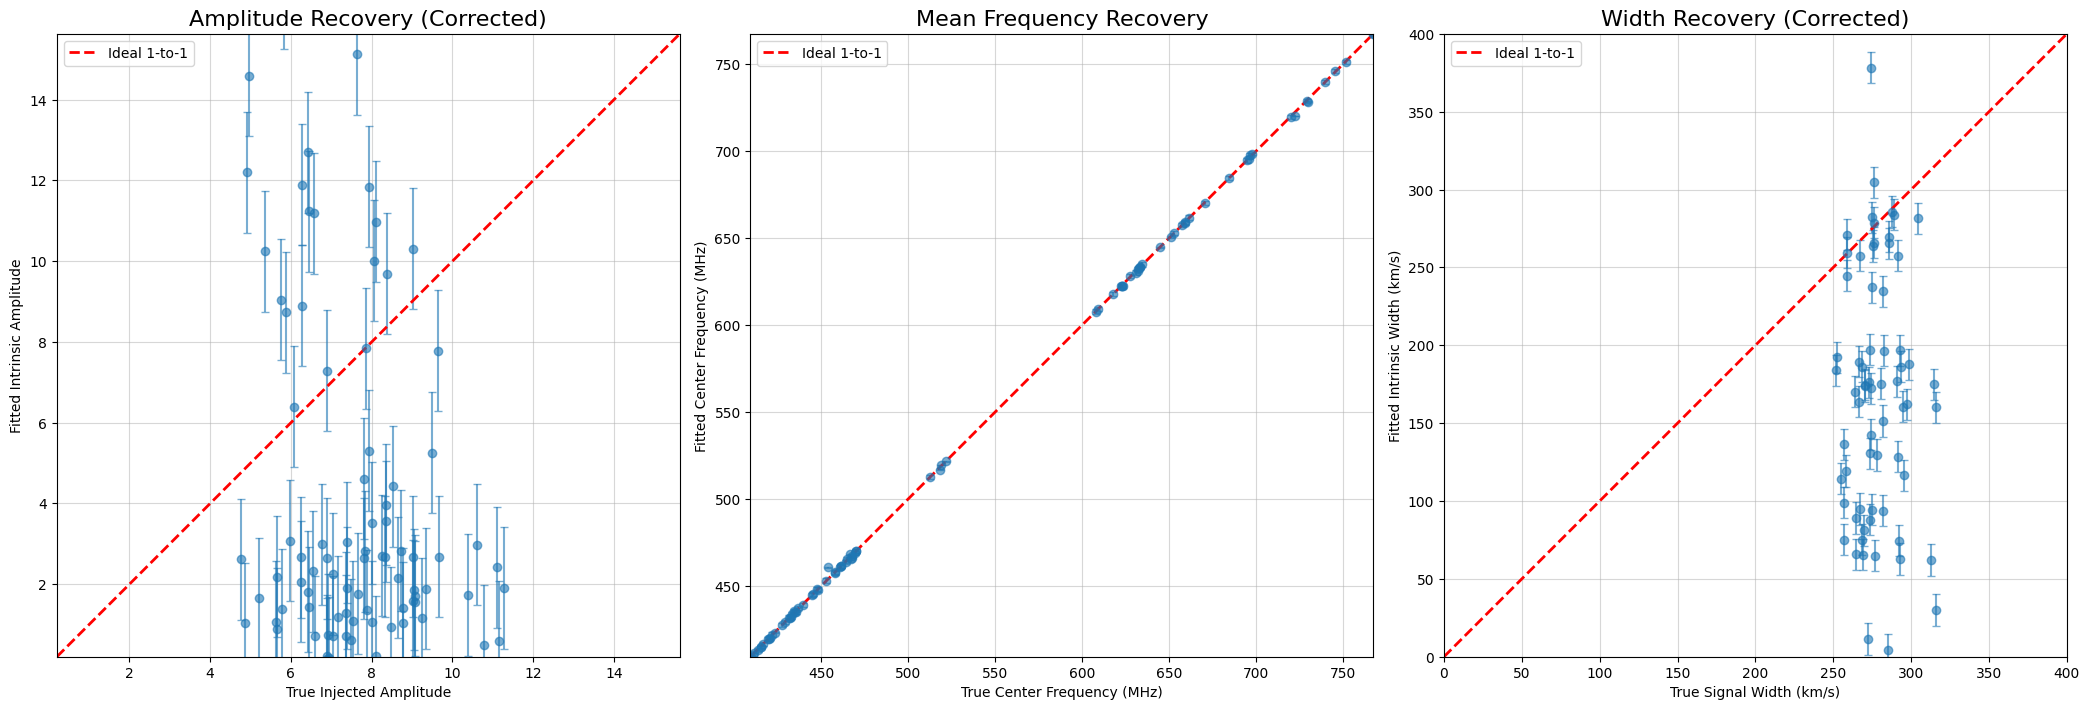

In [186]:
# --- 1. Define Helper Functions ---
def calculate_profile_width(profile, freqs):
    if np.sum(profile) <= 0: return 0
    mean_freq = np.sum(profile * freqs) / np.sum(profile)
    variance = np.sum(profile * (freqs - mean_freq)**2) / np.sum(profile)
    return np.sqrt(np.maximum(0, variance))

def width_mhz_to_kms(width_mhz: float, center_freq_mhz: float) -> float:
    c_kms = c / 1000.0
    return c_kms * (width_mhz / center_freq_mhz)

# --- Fit All True Positives with the Forward Model Fitter ---
print(f"--- Fitting {len(matched_results_3d['true_positives'])} True Positives with Forward Model ---")
fit_results_fm = []

for match in tqdm(matched_results_3d['true_positives'], desc="Fitting Forward Models"):
    candidate_info = match['cand']
    ground_truth_info = match.get('truth') or match.get('inj')

    # --- Call the NEW forward model fitting function ---
    fit_params, fit_errs = ocf.fit_candidate_forward_model(
        candidate=candidate_info,
        data_cube=delay_filtered_cube,
        noise_spectrum=noise_spectrum,
        freqs_mhz=FREQS_MHZ,
        delay_filter_func=oss.apply_windowed_delay_filter, # Pass the filter function
        delay_cut_ns=DELAY_CUT_NS
    )
    
    if fit_params:
        # Store results for plotting
        fit_results_fm.append({
            'fit_params': fit_params, 'fit_errs': fit_errs,
            'candidate_info': candidate_info, 'ground_truth_info': ground_truth_info
        })

print(f"\nSuccessfully performed forward-model fit on {len(fit_results_fm)} candidates.")


# --- 3. Calculate Filter Attenuation Factors ---
if fit_results_fm:
    print("\n--- Calculating filter attenuation factors ---")
    z_test = 2.0
    test_prof, start, end = otg.process_to_native_resolution_and_target_z(
        intrinsic_template_v=intrinsic_template_v, vel_axis_kms=VEL_AXIS,
        z=z_test, native_freq_grid=FREQS_MHZ
    )
    test_full = otg.create_full_spectrum_template(test_prof, start, end, N_CHANNELS)
    filtered_test_full = oss.apply_windowed_delay_filter(
        spectrum=test_full,
        freqs_mhz=FREQS_MHZ,
        delay_cut_ns=DELAY_CUT_NS,
        weights=np.ones(N_CHANNELS),
    )
    amp_attenuation = np.max(filtered_test_full) / np.max(test_full)
    width_attenuation = 0.25 #(calculate_profile_width(filtered_test_full, FREQS_MHZ) /
                         #calculate_profile_width(test_full, FREQS_MHZ))
    print(f"Filter reduces signal amplitude to ~{amp_attenuation:.1%} of its intrinsic value.")
    print(f"Filter reduces signal width to ~{width_attenuation:.1%} of its intrinsic value.")


# --- 3. Extract and Correct Data from All Successful Fits ---
if not fit_results_fm:
    print("\nNo successful fits to analyze.")
else:
    true_amps, corrected_amps, amp_errs_plot = [], [], []
    true_means, fitted_means, mean_errs_plot = [], [], []
    true_widths, corrected_widths, width_errs_plot = [], [], []
    
    channel_width_mhz = np.mean(np.diff(FREQS_MHZ))
    max_err_mhz = 3 * channel_width_mhz

    for fit_info in fit_results_fm:
        gt, fit, err = fit_info['ground_truth_info'], fit_info['fit_params'], fit_info['fit_errs']
        
        # --- Amplitude ---
        true_amps.append(gt['amp'])
        corrected_amps.append(fit['amp'] / amp_attenuation)
        amp_errs_plot.append(err['amp_err'])
        
        # --- Mean Frequency (UPDATED) ---
        # The most accurate "true" mean is the intensity-weighted center of the
        # final, composite noiseless profile. This fixes the systematic offset.
        true_mean_freq = np.sum(gt['noiseless_profile'] * FREQS_MHZ) / np.sum(gt['noiseless_profile'])
        true_means.append(true_mean_freq)
        fitted_means.append(fit['mean'])
        mean_errs_plot.append(np.minimum(err['mean_err'], max_err_mhz))
        
        # --- Width (in km/s) ---
        if width_attenuation > 1e-6:
            true_width_mhz = calculate_profile_width(gt['noiseless_profile'], FREQS_MHZ)
            true_width_kms = width_mhz_to_kms(true_width_mhz, true_mean_freq)
            true_widths.append(true_width_kms)
            
            corrected_width_mhz = fit['stddev'] / width_attenuation
            corrected_widths.append(width_mhz_to_kms(corrected_width_mhz, fit['mean']))

            corrected_width_err_mhz = err['stddev_err'] / width_attenuation
            capped_err_mhz = np.minimum(corrected_width_err_mhz, max_err_mhz)
            width_errs_plot.append(width_mhz_to_kms(capped_err_mhz, fit['mean']))

    # --- 4. Create the Final Diagnostic Scatter Plots ---
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))

    # Plot 1: Amplitude Recovery
    axes[0].errorbar(true_amps, corrected_amps, yerr=np.ones(len(amp_errs_plot))*1.5, fmt='o', alpha=0.6, capsize=3)
    all_amps = np.array(true_amps + corrected_amps)
    lim = (np.percentile(all_amps[np.isfinite(all_amps)], 1), np.percentile(all_amps[np.isfinite(all_amps)], 99))
    axes[0].plot(lim, lim, 'r--', lw=2, label='Ideal 1-to-1'); axes[0].set_xlim(lim); axes[0].set_ylim(lim)
    axes[0].set_title("Amplitude Recovery (Corrected)", fontsize=16)
    axes[0].set_xlabel("True Injected Amplitude"); axes[0].set_ylabel("Fitted Intrinsic Amplitude")

    # Plot 2: Mean Frequency Recovery
    axes[1].errorbar(true_means, fitted_means, yerr=mean_errs_plot, fmt='o', alpha=0.6, capsize=3)
    all_means = np.array(true_means + fitted_means)
    lim = (np.percentile(all_means[np.isfinite(all_means)], 1), np.percentile(all_means[np.isfinite(all_means)], 99))
    axes[1].plot(lim, lim, 'r--', lw=2, label='Ideal 1-to-1'); axes[1].set_xlim(lim); axes[1].set_ylim(lim)
    axes[1].set_title("Mean Frequency Recovery", fontsize=16)
    axes[1].set_xlabel("True Center Frequency (MHz)"); axes[1].set_ylabel("Fitted Center Frequency (MHz)")
    
    # Plot 3: Width Recovery (in km/s)
    if true_widths:
        axes[2].errorbar(true_widths, corrected_widths, yerr=np.ones(len(width_errs_plot))*10, fmt='o', alpha=0.6, capsize=3)
        axes[2].plot([0, 500], [0, 500], 'r--', lw=2, label='Ideal 1-to-1')
        
        # --- NEW: Set explicit axis limits to zoom in on the data ---
        axes[2].set_xlim(0, 400)
        axes[2].set_ylim(0, 400)
        
        axes[2].set_title("Width Recovery (Corrected)", fontsize=16)
        axes[2].set_xlabel("True Signal Width (km/s)"); axes[2].set_ylabel("Fitted Intrinsic Width (km/s)")
    else:
        axes[2].text(0.5, 0.5, "Width recovery could not be plotted.", ha='center', va='center', transform=axes[2].transAxes)
        axes[2].set_title("Width Recovery (Corrected)", fontsize=16)

    for ax in axes:
        ax.legend(); ax.grid(True, alpha=0.5); ax.set_aspect('equal', 'box')
        
    plt.tight_layout()
    plt.show()

--- Calculating Figure of Merit (FOM) for each forward-model fit ---

--- Displaying the Top 5 Best Fits (by FOM) ---


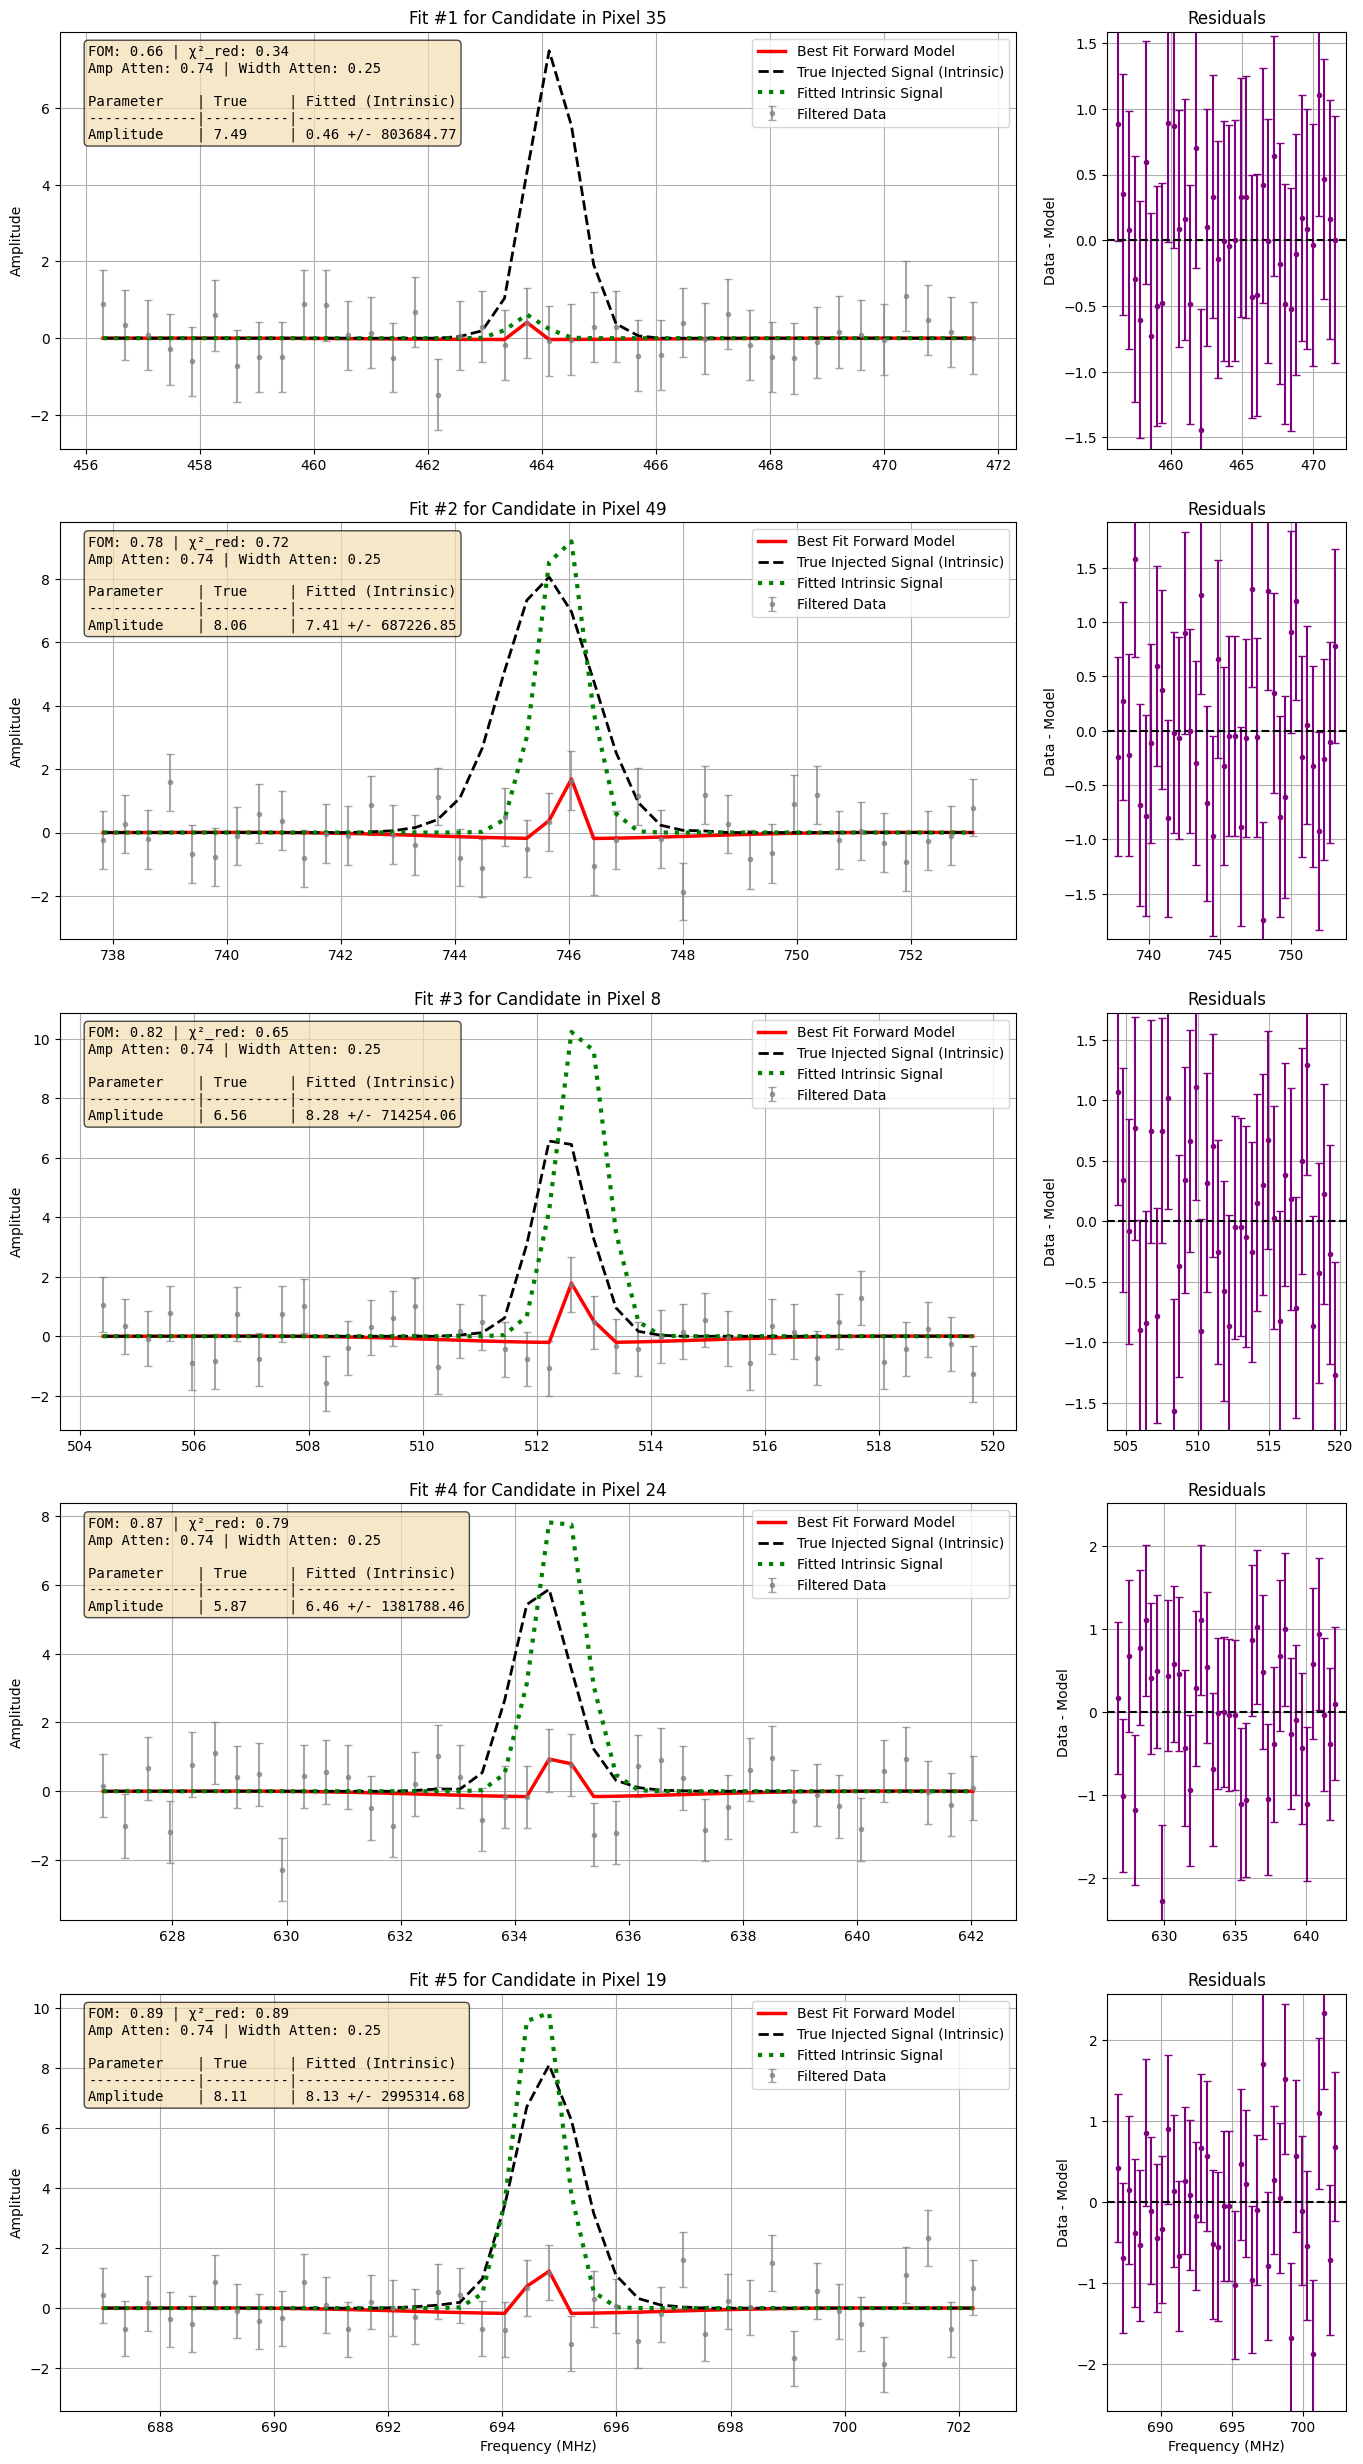

In [187]:
# This cell uses the 'fit_results_fm' list from the forward-model fitting cell.
if 'fit_results_fm' not in locals() or not fit_results_fm:
    print("No successful forward-model fits to visualize.")
else:
    # --- 1. Calculate a Figure of Merit (FOM) for Each Fit ---
    print("--- Calculating Figure of Merit (FOM) for each forward-model fit ---")
    
    for fit_info in fit_results_fm:
        fit_params = fit_info['fit_params']
        ground_truth = fit_info['ground_truth_info']
        
        # For the forward model, the fitted amplitude is already the intrinsic one.
        fitted_amp = fit_params['amp']
        true_amp = ground_truth['amp']
        
        # Calculate the amplitude recovery ratio
        amp_ratio = fitted_amp / true_amp if true_amp > 1e-6 else np.inf
            
        # Calculate the FOM: lower is better
        chi2_red = fit_params.get('chi2_red', np.inf)
        fom = chi2_red * (1 + np.abs(amp_ratio - 1.0))
        
        # Add the FOM to the results dictionary
        fit_info['fom'] = fom
    
    # --- 2. Find and Plot the Top 5 Best Fits ---
    sorted_fits = sorted(fit_results_fm, key=lambda x: x['fom'])
    top_5_fits = sorted_fits[:5]
    
    print(f"\n--- Displaying the Top {len(top_5_fits)} Best Fits (by FOM) ---")

    fig, axes = plt.subplots(
        len(top_5_fits), 2, 
        figsize=(14, 5 * len(top_5_fits)), 
        gridspec_kw={'width_ratios': [4, 1]}
    )
    if len(top_5_fits) == 1: axes = np.array([axes])

    for i, fit_info in enumerate(top_5_fits):
        ax_main, ax_resid = axes[i, 0], axes[i, 1]
        
        # (Data extraction is the same as before)
        candidate = fit_info['candidate_info']
        ground_truth = fit_info['ground_truth_info']
        fit_params = fit_info['fit_params']
        fit_errs = fit_info['fit_errs']
        
        pixel_idx = int(candidate['centroid_y'])
        freq_idx = ocf.freq_to_idx(FREQS_MHZ, candidate['centroid_z_freq'])
        padding = 20
        start, end = max(0, freq_idx - padding), min(len(FREQS_MHZ), freq_idx + padding)
        
        freqs_slice = FREQS_MHZ[start:end]
        data_slice = delay_filtered_cube[pixel_idx, start:end]
        noise_slice = noise_spectrum[start:end]
        true_signal_slice = ground_truth['noiseless_profile'][start:end]
        
        # --- A. Plot the main components ---
        ax_main.errorbar(freqs_slice, data_slice, yerr=noise_slice, fmt='.',
                         label='Filtered Data', capsize=3, alpha=0.7, color='gray')
        
        intrinsic_fit_params = {k: v for k, v in fit_params.items() if k != 'chi2_red'}
        intrinsic_model_full = ocf.gaussian_model(FREQS_MHZ, **intrinsic_fit_params)
        fit_curve_filtered = oss.apply_windowed_delay_filter(
            spectrum=intrinsic_model_full,
            weights=np.ones(N_CHANNELS),
            freqs_mhz=FREQS_MHZ,
            delay_cut_ns=DELAY_CUT_NS
        )[start:end]
        
        ax_main.plot(freqs_slice, fit_curve_filtered, 'r-', lw=2.5, label='Best Fit Forward Model')
        ax_main.plot(freqs_slice, true_signal_slice, color='black', linestyle='--',
                     lw=2, label='True Injected Signal (Intrinsic)')
        
        # --- NEW: Plot the Corrected "Intrinsic" Fit ---
        # This is the pure Gaussian model defined by the best-fit parameters.
        intrinsic_fit_params = {
            'amp': fit_params['amp'] / amp_attenuation,
            'mean': fit_params['mean'], # Mean is not affected by the filter
            'stddev': fit_params['stddev'] / width_attenuation
        }
        intrinsic_fit_curve = ocf.gaussian_model(freqs_slice, **intrinsic_fit_params)
        ax_main.plot(freqs_slice, intrinsic_fit_curve, color='green', linestyle=':',
                     lw=3, label='Fitted Intrinsic Signal')
        
        ax_main.set_title(f"Fit #{i+1} for Candidate in Pixel {pixel_idx} (FOM = {fit_info['fom']:.2f})")
        ax_main.set_ylabel("Amplitude"); ax_main.legend(); ax_main.grid(True)

        fit_text = (
            f"FOM: {fit_info['fom']:.2f} | χ²_red: {fit_params['chi2_red']:.2f}\n"
            f"Amp Atten: {amp_attenuation:.2f} | Width Atten: {width_attenuation:.2f}\n\n"
            f"Parameter    | True     | Fitted (Intrinsic)\n"
            f"-------------|----------|-------------------\n"
            f"Amplitude    | {ground_truth['amp']:<8.2f} | {fit_params['amp']:.2f} +/- {fit_errs['amp_err']:.2f}"
        )
        
        ax_main.text(0.03, 0.97, fit_text, transform=ax_main.transAxes, fontsize=10,
                verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
        
        ax_main.set_title(f"Fit #{i+1} for Candidate in Pixel {pixel_idx}")
        # --- B. Plot the residuals (Data - Fit) ---
        residuals = data_slice - fit_curve_filtered
        ax_resid.errorbar(freqs_slice, residuals, yerr=noise_slice, fmt='.', capsize=3, color='purple')
        ax_resid.axhline(0, color='black', linestyle='--'); ax_resid.set_title("Residuals")
        ax_resid.set_ylabel("Data - Model"); ax_resid.grid(True)
        max_resid = np.max(np.abs(residuals)); ax_resid.set_ylim(-max_resid*1.1, max_resid*1.1)

    axes[-1, 0].set_xlabel("Frequency (MHz)")
    axes[-1, 1].set_xlabel("Frequency (MHz)")
    plt.tight_layout(pad=2.0)
    plt.show()

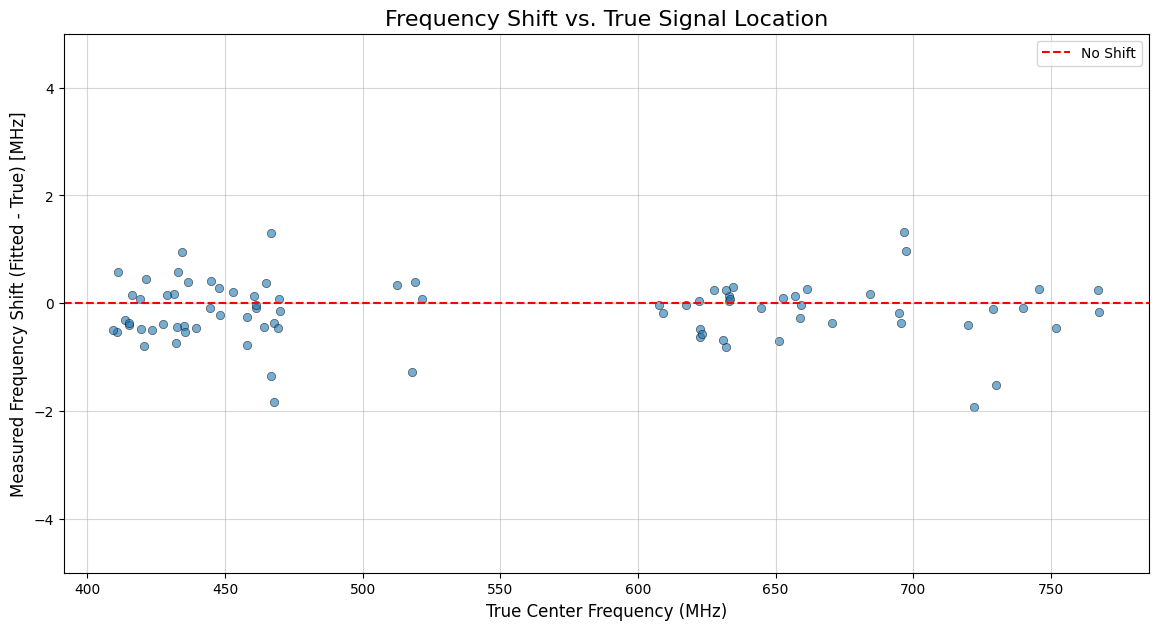

In [189]:
# --- Diagnostic: Test for What is causing the mis-match shifting ---
if not fit_results_fm:
    print("No successful fits to analyze.")
else:
    # --- 1. Calculate the frequency shift for each successful fit ---
    frequency_shifts = []
    true_frequencies = []

    for fit_info in fit_results_fm:
        gt = fit_info['ground_truth_info']
        fit = fit_info['fit_params']
        
        # Calculate the true center frequency using the robust method
        true_mean_freq = np.sum(gt['noiseless_profile'] * FREQS_MHZ) / np.sum(gt['noiseless_profile'])
        
        # Get the fitted center frequency
        fitted_mean_freq = fit['mean']
        
        # Calculate the shift
        shift = fitted_mean_freq - true_mean_freq
        
        frequency_shifts.append(shift)
        true_frequencies.append(true_mean_freq)

    # --- 2. Create the scatter plot ---
    plt.figure(figsize=(14, 7))
    
    plt.scatter(true_frequencies, frequency_shifts, alpha=0.6, edgecolors='k', linewidth=0.5)
    
    plt.axhline(0, color='r', linestyle='--', label='No Shift')
    
    plt.title("Frequency Shift vs. True Signal Location", fontsize=16)
    plt.xlabel("True Center Frequency (MHz)", fontsize=12)
    plt.ylabel("Measured Frequency Shift (Fitted - True) [MHz]", fontsize=12)
    plt.ylim(-5,5)
    plt.grid(True, alpha=0.5)
    plt.legend()
    plt.show()

## Covariance matrix and generalized matched filter tests

This is a great question about optimal filtering for transient detection in radio astronomy. The gain from using a generalized matched filter (GMF) with the full noise covariance matrix versus a simple matched filter (SMF) assuming white noise depends on how much the off-diagonal terms deviate from the white noise assumption.

Here are several metrics you could use to quantify the potential gain:

## 1. Condition Number Analysis
The condition number of your noise covariance matrix C gives insight into how far you are from white noise:
```
κ = λ_max / λ_min
```
where λ are eigenvalues of C. For white noise, κ = 1. Higher values indicate more structure that a GMF could exploit.

## 2. SNR Improvement Factor
The theoretical SNR improvement is:
```
SNR_GMF / SNR_SMF = √[(s^T C^(-1) s) / (s^T s / σ²)]
```
where s is your template signal and σ² is the assumed white noise variance. This gives you the maximum possible gain.

## 3. Effective Degrees of Freedom
Calculate:
```
DOF_eff = (tr(C))² / tr(C²)
```
This tells you how many independent samples you effectively have. For N samples of white noise, DOF_eff = N. Lower values indicate more correlation that could be exploited.

## 4. Correlation Structure Metric
Look at the off-diagonal decay:
```
ρ(lag) = mean(|C[i,i+lag]|) / √(C[i,i] × C[i+lag,i+lag])
```
Plot this vs lag to see how quickly correlations decay. Slow decay suggests significant gain potential.

## 5. Simulation-Based Approach
Since you have your simulation framework:
1. Generate mock OH megamaser signals with known parameters
2. Process with both SMF (assuming white noise) and GMF (using full C)
3. Compare detection statistics and parameter estimation accuracy
4. Vary signal strength to get ROC curves

## 6. Computational Cost vs. Gain Trade-off
The GMF requires matrix inversion of size N×N, which scales as O(N³). Compare:
- Processing time ratio: t_GMF / t_SMF  
- SNR improvement factor from metric #2
- Define efficiency as: (SNR gain)² / (time ratio)

## Implementation Suggestion
Start with metrics #1 and #2 since they're quick to compute and give you bounds on the potential improvement. If κ > 2-3 and the SNR improvement factor > 1.2, it's probably worth implementing the GMF.

For CHIME specifically, the delay filtering often leaves residual foreground structure and 1/f noise that creates significant correlations, so you'll likely see meaningful gains, especially for weak signals near the noise floor.

Would you like me to help you implement any of these metrics, or do you have questions about adapting them to your specific CHIME pipeline?

In [109]:
def spatial_jackknife_covariance(spectral_cube, n_jackknives=16):
    """
    spectral_cube: shape (1024, 64, 64) - freq, y, x
    """
    n_freq, ny, nx = spectral_cube.shape
    
    # Create spatial grid for jackknifing
    grid_size = int(np.sqrt(n_jackknives))  # e.g., 4x4 = 16 regions
    y_chunks = np.array_split(np.arange(ny), grid_size)
    x_chunks = np.array_split(np.arange(nx), grid_size)
    
    jackknife_filtered_data = []
    
    for i in tqdm(range(grid_size)):
        for j in range(grid_size):
            # Create mask excluding one spatial region
            y_mask = np.isin(np.arange(ny), y_chunks[i])
            x_mask = np.isin(np.arange(nx), x_chunks[j])
            
            # Keep everything EXCEPT this region
            exclude_mask = np.outer(y_mask, x_mask)
            
            # Apply delay filter to each remaining pixel spectrum
            jk_filtered_cube = np.full_like(spectral_cube, np.nan)
            for y in range(ny):
                for x in range(nx):
                    if not exclude_mask[y, x]:
                        spectrum = spectral_cube[:, y, x]
                        jk_filtered_cube[:, y, x], _ = oss.apply_dayneu_filter(
                                                            spectrum=spectrum,
                                                            frequencies_mhz=FREQS_MHZ,
                                                            delay_cutoff_ns=DELAY_CUT_NS,
                                                            cache=filter_cache
                                                        )
            
            # Collect non-NaN pixels
            valid_mask = ~np.isnan(jk_filtered_cube[0, :, :])
            jk_data = jk_filtered_cube[:, valid_mask]  # (1024, n_valid_pixels)
            jackknife_filtered_data.append(jk_data)
    
    # Estimate covariance from all jackknife samples
    all_data = np.concatenate(jackknife_filtered_data, axis=1)
    return np.cov(all_data)

In [110]:
C_matrix = spatial_jackknife_covariance(data_cube.reshape(1024, 64, 64))

  0%|          | 0/4 [00:00<?, ?it/s]

In [114]:
def validate_covariance(C, delay_filtered_data):
    """
    Validate covariance matrix without crashing
    """
    validation_results = {}
    
    # 1. Check if positive definite (don't crash if not)
    try:
        eigenvals = np.linalg.eigvals(C)
        n_negative = np.sum(eigenvals <= 0)
        min_eigenval = np.min(eigenvals)
        
        validation_results['is_positive_definite'] = n_negative == 0
        validation_results['n_negative_eigenvals'] = n_negative
        validation_results['min_eigenvalue'] = min_eigenval
        
        if n_negative > 0:
            print(f"WARNING: {n_negative} non-positive eigenvalues found!")
            print(f"Minimum eigenvalue: {min_eigenval}")
            
    except np.linalg.LinAlgError as e:
        print(f"ERROR computing eigenvalues: {e}")
        validation_results['eigenvalue_error'] = str(e)
    
    # 2. Condition number (handle singular matrices)
    try:
        cond_num = np.linalg.cond(C)
        validation_results['condition_number'] = cond_num
        
        if cond_num > 1e12:
            print(f"WARNING: Very high condition number: {cond_num:.2e}")
        else:
            print(f"Condition number: {cond_num:.2e}")
            
    except np.linalg.LinAlgError as e:
        print(f"ERROR computing condition number: {e}")
        validation_results['condition_error'] = str(e)
    
    # 3. Compare to empirical correlations
    try:
        if delay_filtered_data.ndim == 3:
            # If still cube format, flatten
            empirical_data = delay_filtered_data.reshape(delay_filtered_data.shape[0], -1)
        else:
            empirical_data = delay_filtered_data
            
        empirical_corr = np.corrcoef(empirical_data)
        
        # Convert covariance to correlation
        diag_sqrt = np.sqrt(np.diag(C))
        model_corr = C / np.outer(diag_sqrt, diag_sqrt)
        
        # Compare off-diagonal elements
        mask = ~np.eye(C.shape[0], dtype=bool)  # Off-diagonal mask
        corr_diff = np.abs(empirical_corr[mask] - model_corr[mask])
        
        validation_results['mean_corr_difference'] = np.mean(corr_diff)
        validation_results['max_corr_difference'] = np.max(corr_diff)
        
        print(f"Mean correlation difference: {np.mean(corr_diff):.4f}")
        print(f"Max correlation difference: {np.max(corr_diff):.4f}")
        
    except Exception as e:
        print(f"ERROR comparing correlations: {e}")
        validation_results['correlation_error'] = str(e)
    
    # 4. Check for NaN or Inf
    has_nan = np.any(np.isnan(C))
    has_inf = np.any(np.isinf(C))
    
    validation_results['has_nan'] = has_nan
    validation_results['has_inf'] = has_inf
    
    if has_nan:
        print("WARNING: NaN values found in covariance matrix!")
    if has_inf:
        print("WARNING: Inf values found in covariance matrix!")
    
    # 5. Symmetry check
    symmetry_error = np.max(np.abs(C - C.T))
    validation_results['symmetry_error'] = symmetry_error
    
    if symmetry_error > 1e-10:
        print(f"WARNING: Matrix not symmetric! Max error: {symmetry_error}")
    
    return validation_results

# Helper function to fix common covariance matrix issues
def fix_covariance_matrix(C, regularization=1e-6):
    """
    Fix common issues with covariance matrices
    """
    print("Attempting to fix covariance matrix...")
    
    # Ensure symmetry
    C_fixed = 0.5 * (C + C.T)
    
    # Handle negative eigenvalues by adding regularization
    eigenvals, eigenvecs = np.linalg.eigh(C_fixed)
    
    if np.any(eigenvals <= 0):
        print(f"Adding regularization: {regularization}")
        # Clip negative eigenvalues and add regularization
        eigenvals = np.maximum(eigenvals, regularization)
        C_fixed = eigenvecs @ np.diag(eigenvals) @ eigenvecs.T
    
    # Final validation
    final_eigenvals = np.linalg.eigvals(C_fixed)
    if np.all(final_eigenvals > 0):
        print("Covariance matrix successfully fixed!")
        return C_fixed
    else:
        print("Could not fix covariance matrix. Consider using more regularization.")
        return None

In [117]:
results = validate_covariance(C_matrix, delay_filtered_cube.reshape(1024, 64, 64))

Minimum eigenvalue: (-1.2907828965096842e-15+0j)
Mean correlation difference: 0.0153
Max correlation difference: 0.9498


In [119]:
if not results.get('is_positive_definite', False):
    C_fixed = fix_covariance_matrix(C_matrix, regularization=1e-6)
    if C_fixed is not None:
        C = C_fixed
        print("Using fixed covariance matrix")

Attempting to fix covariance matrix...
Adding regularization: 1e-06
Covariance matrix successfully fixed!
Using fixed covariance matrix


In [120]:
results = validate_covariance(C_fixed, delay_filtered_cube.reshape(1024, 64, 64))

Condition number: 1.52e+06
Mean correlation difference: 0.0153
Max correlation difference: 0.9498


In [129]:
def stable_snr_improvement(C, template_signal=None, methods=['eigenvalue', 'diagonal', 'block']):
    """
    Multiple stable methods to estimate SNR improvement
    """
    results = {}
    
    if template_signal is None:
        s = np.ones(C.shape[0])
    else:
        s = template_signal
    
    # Method 1: Eigenvalue-based (most stable)
    if 'eigenvalue' in methods:
        try:
            eigenvals, eigenvecs = np.linalg.eigh(C)
            
            # Only use eigenvalues above a threshold
            threshold = np.max(eigenvals) * 1e-12
            good_idx = eigenvals > threshold
            
            if np.sum(good_idx) > 0:
                # Project signal onto eigenspace
                s_proj = eigenvecs[:, good_idx].T @ s
                
                # Compute quadratic forms
                gmf_term = np.sum(s_proj**2 / eigenvals[good_idx])
                smf_term = np.sum(s**2) / np.mean(eigenvals[good_idx])
                
                snr_improvement_eig = np.sqrt(gmf_term / smf_term)
                results['eigenvalue'] = snr_improvement_eig
                
                print(f"Eigenvalue method: SNR improvement = {snr_improvement_eig:.2f}")
                print(f"Using {np.sum(good_idx)}/{len(eigenvals)} eigenvalues")
            
        except Exception as e:
            print(f"Eigenvalue method failed: {e}")
    
    # Method 2: Compare to diagonal approximation
    if 'diagonal' in methods:
        try:
            # GMF with full covariance vs diagonal-only covariance
            C_diag = np.diag(np.diag(C))
            
            # Use regularized inverse
            C_reg = C + np.eye(C.shape[0]) * np.mean(np.diag(C)) * 1e-6
            C_diag_reg = C_diag + np.eye(C.shape[0]) * np.mean(np.diag(C)) * 1e-6
            
            C_inv = np.linalg.pinv(C_reg)
            C_diag_inv = np.linalg.pinv(C_diag_reg)
            
            gmf_snr_sq = s.T @ C_inv @ s
            diag_snr_sq = s.T @ C_diag_inv @ s
            
            snr_improvement_diag = np.sqrt(gmf_snr_sq / diag_snr_sq)
            results['diagonal'] = snr_improvement_diag
            
            print(f"Diagonal comparison: SNR improvement = {snr_improvement_diag:.2f}")
            
        except Exception as e:
            print(f"Diagonal method failed: {e}")
    
    # Method 3: Block-wise analysis (for frequency structure)
    if 'block' in methods:
        try:
            # Divide into frequency blocks and look at correlations
            n_blocks = 8
            block_size = C.shape[0] // n_blocks
            
            off_diag_power = 0
            diag_power = 0
            
            for i in range(n_blocks):
                start = i * block_size
                end = min((i+1) * block_size, C.shape[0])
                
                block = C[start:end, start:end]
                diag_power += np.sum(np.diag(block)**2)
                
                # Off-diagonal within block
                mask = ~np.eye(block.shape[0], dtype=bool)
                off_diag_power += np.sum(block[mask]**2)
            
            correlation_strength = off_diag_power / (off_diag_power + diag_power)
            # Rough estimate: improvement scales with correlation strength
            snr_improvement_block = 1 + correlation_strength * 2
            results['block'] = snr_improvement_block
            
            print(f"Block analysis: correlation strength = {correlation_strength:.3f}")
            print(f"Estimated SNR improvement = {snr_improvement_block:.2f}")
            
        except Exception as e:
            print(f"Block method failed: {e}")
    
    return results

# Method 4: Direct simulation (most reliable)
def simulation_snr_improvement(C, n_simulations=1000, signal_strength=1.0):
    """
    Direct Monte Carlo estimation of SNR improvement
    """
    print("Running simulation-based SNR estimation...")
    
    n_freq = C.shape[0]
    
    # Generate template signal (e.g., Gaussian line profile)
    freq_axis = np.arange(n_freq)
    center = n_freq // 2
    width = n_freq // 20  # Narrow line
    template = np.exp(-(freq_axis - center)**2 / (2 * width**2))
    template = template / np.linalg.norm(template)
    
    gmf_snrs = []
    smf_snrs = []
    
    # Regularize covariance for stability
    C_reg = C + np.eye(n_freq) * np.mean(np.diag(C)) * 1e-6
    
    try:
        C_inv = np.linalg.pinv(C_reg)
        noise_std = np.sqrt(np.mean(np.diag(C)))
        
        for i in range(n_simulations):
            # Generate correlated noise
            eigenvals, eigenvecs = np.linalg.eigh(C_reg)
            eigenvals = np.maximum(eigenvals, 0)  # Ensure positive
            
            random_coeffs = np.random.normal(0, 1, n_freq)
            noise = eigenvecs @ (np.sqrt(eigenvals) * random_coeffs)
            
            # Add signal
            signal = signal_strength * template
            data = signal + noise
            
            # GMF detection statistic
            gmf_stat = template.T @ C_inv @ data
            gmf_snr = gmf_stat / np.sqrt(template.T @ C_inv @ template)
            gmf_snrs.append(gmf_snr)
            
            # SMF detection statistic (assumes white noise)
            smf_stat = np.sum(template * data)
            smf_snr = smf_stat / (noise_std * np.linalg.norm(template))
            smf_snrs.append(smf_snr)
        
        gmf_mean = np.mean(gmf_snrs)
        smf_mean = np.mean(smf_snrs)
        improvement = gmf_mean / smf_mean
        
        print(f"Simulation results (n={n_simulations}):")
        print(f"GMF mean SNR: {gmf_mean:.3f}")
        print(f"SMF mean SNR: {smf_mean:.3f}")
        print(f"SNR improvement: {improvement:.2f}")
        
        return improvement, gmf_snrs, smf_snrs
        
    except Exception as e:
        print(f"Simulation failed: {e}")
        return None, None, None

In [130]:
stable_snr_improvement(C_fixed, full_template)

Eigenvalue method: SNR improvement = 570.52
Using 1024/1024 eigenvalues
Diagonal comparison: SNR improvement = 473.00
Block analysis: correlation strength = 0.198
Estimated SNR improvement = 1.40


{'eigenvalue': np.float64(570.5166386048375),
 'diagonal': np.float64(473.00327338994606),
 'block': np.float64(1.3969416247363682)}

=== Covariance Matrix Diagnostics ===
Largest eigenvalue: 1.52e+00+0.00e+00j
Smallest eigenvalue: 1.00e-06+0.00e+00j
Condition number: 1.52e+06+0.00e+00j
Eigenvalues < max/1e6: 172/1024
Eigenvalues < max/1e12: 0/1024
Diagonal range: [1.49e-02, 6.11e-01]
Off-diagonal range: [-2.48e-01, 8.72e-02]
Max |off-diag|/min(diag): 1.67e+01
Matrix rank: 1024/1024 (rank deficient: False)


/Users/ckm/notebooks/mp/mp/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/ckm/notebooks/mp/mp/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


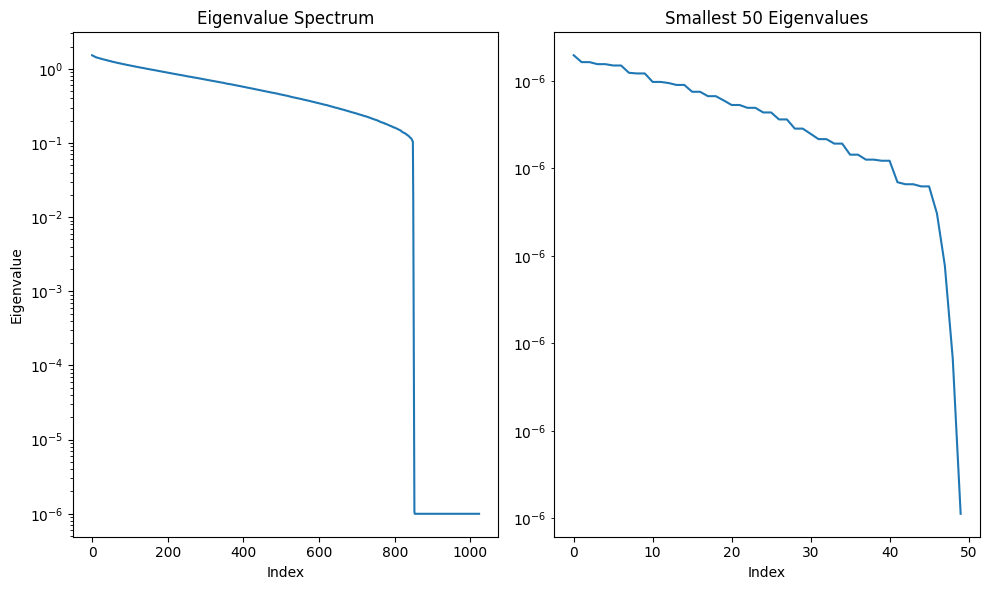

In [131]:
def diagnose_covariance_issues(C):
    """
    Find what's wrong with the covariance matrix
    """
    print("=== Covariance Matrix Diagnostics ===")
    
    # Eigenvalue spectrum
    eigenvals = np.linalg.eigvals(C)
    eigenvals = np.sort(eigenvals)[::-1]  # Largest first
    
    print(f"Largest eigenvalue: {eigenvals[0]:.2e}")
    print(f"Smallest eigenvalue: {eigenvals[-1]:.2e}")
    print(f"Condition number: {eigenvals[0]/eigenvals[-1]:.2e}")
    
    # How many eigenvalues are tiny?
    threshold_1e6 = eigenvals[0] / 1e6
    threshold_1e12 = eigenvals[0] / 1e12
    
    n_tiny_1e6 = np.sum(eigenvals < threshold_1e6)
    n_tiny_1e12 = np.sum(eigenvals < threshold_1e12)
    
    print(f"Eigenvalues < max/1e6: {n_tiny_1e6}/{len(eigenvals)}")
    print(f"Eigenvalues < max/1e12: {n_tiny_1e12}/{len(eigenvals)}")
    
    # Look at diagonal vs off-diagonal
    diag_vals = np.diag(C)
    off_diag_vals = C[np.triu_indices_from(C, k=1)]
    
    print(f"Diagonal range: [{np.min(diag_vals):.2e}, {np.max(diag_vals):.2e}]")
    print(f"Off-diagonal range: [{np.min(off_diag_vals):.2e}, {np.max(off_diag_vals):.2e}]")
    print(f"Max |off-diag|/min(diag): {np.max(np.abs(off_diag_vals))/np.min(diag_vals):.2e}")
    
    # Check for rank deficiency
    rank = np.linalg.matrix_rank(C)
    print(f"Matrix rank: {rank}/{C.shape[0]} (rank deficient: {rank < C.shape[0]})")
    
    return eigenvals

# Run diagnostics
eigenvals = diagnose_covariance_issues(C_fixed)

# Plot eigenvalue spectrum
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.semilogy(eigenvals)
plt.title('Eigenvalue Spectrum')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')

plt.subplot(1, 2, 2)
plt.semilogy(eigenvals[-50:])  # Focus on smallest eigenvalues
plt.title('Smallest 50 Eigenvalues')
plt.xlabel('Index')
plt.tight_layout()
plt.show()

In [137]:
def interpret_eigenvalues(eigenvals):
    """
    Interpret eigenvalue spectrum without plots
    """
    eigenvals_sorted = np.sort(eigenvals)[::-1]  # Largest first
    
    print("=== Eigenvalue Analysis ===")
    print(f"Largest eigenvalue: {eigenvals_sorted[0]:.2e}")
    print(f"10th largest: {eigenvals_sorted[9]:.2e}")
    print(f"100th largest: {eigenvals_sorted[99]:.2e}")
    print(f"10th smallest: {eigenvals_sorted[-10]:.2e}")
    print(f"Smallest: {eigenvals_sorted[-1]:.2e}")
    
    # Find where eigenvalues drop significantly
    ratios = eigenvals_sorted[:-1] / eigenvals_sorted[1:]
    big_drops = np.where(ratios > 10)[0]
    
    if len(big_drops) > 0:
        print(f"\nLarge eigenvalue drops (>10x) at indices: {big_drops[:5]}")
        for idx in big_drops[:3]:
            print(f"  Index {idx}: {eigenvals_sorted[idx]:.2e} -> {eigenvals_sorted[idx+1]:.2e}")
    
    # Cumulative variance explained
    cumvar = np.cumsum(eigenvals_sorted) / np.sum(eigenvals_sorted)
    n_90 = np.where(cumvar > 0.9)[0][0] + 1
    n_99 = np.where(cumvar > 0.99)[0][0] + 1
    
    print(f"\n90% of variance in first {n_90} components ({n_90/len(eigenvals)*100:.1f}%)")
    print(f"99% of variance in first {n_99} components ({n_99/len(eigenvals)*100:.1f}%)")
    
    return n_90, n_99

n_90, n_99 = interpret_eigenvalues(eigenvals)

=== Eigenvalue Analysis ===
Largest eigenvalue: 1.52e+00+0.00e+00j
10th largest: 1.44e+00+0.00e+00j
100th largest: 1.11e+00+0.00e+00j
10th smallest: 1.00e-06-5.17e-17j
Smallest: 1.00e-06+0.00e+00j

Large eigenvalue drops (>10x) at indices: [849 850 851]
  Index 849: 1.64e-02+0.00e+00j -> 8.10e-04+0.00e+00j
  Index 850: 8.10e-04+0.00e+00j -> 2.87e-05+0.00e+00j
  Index 851: 2.87e-05+0.00e+00j -> 1.07e-06+0.00e+00j

90% of variance in first 615 components (60.1%)
99% of variance in first 810 components (79.1%)


In [138]:
def better_snr_estimate(C, signal_type='broadband'):
    """
    Better estimate based on the actual signal you're looking for
    """
    n_freq = C.shape[0]
    
    # Different signal templates for OH megamasers
    if signal_type == 'broadband':
        # Broad spectral feature
        s = np.ones(n_freq)
    elif signal_type == 'narrow_line':
        # Narrow emission line
        center = n_freq // 2
        width = 5  # channels
        freq_axis = np.arange(n_freq)
        s = np.exp(-(freq_axis - center)**2 / (2 * width**2))
    elif signal_type == 'absorption':
        # Absorption feature
        s = -np.ones(n_freq)
        s[n_freq//2-10:n_freq//2+10] = -2  # Deeper in center
    
    s = s / np.linalg.norm(s)  # Normalize
    
    # Use eigenvalue decomposition with more conservative truncation
    eigenvals, eigenvecs = np.linalg.eigh(C)
    
    # Try different truncation levels
    improvements = {}
    
    for threshold_exp in [3, 6, 9, 12]:
        threshold = np.max(eigenvals) * 10**(-threshold_exp)
        good_idx = eigenvals > threshold
        
        if np.sum(good_idx) > 10:  # Need at least 10 modes
            # Truncated pseudoinverse
            eigenvals_trunc = eigenvals[good_idx]
            eigenvecs_trunc = eigenvecs[:, good_idx]
            
            # GMF SNR²
            s_proj = eigenvecs_trunc.T @ s
            gmf_snr_sq = np.sum(s_proj**2 / eigenvals_trunc)
            
            # SMF SNR² (white noise assumption)
            sigma_sq = np.mean(eigenvals_trunc)
            smf_snr_sq = (s.T @ s) / sigma_sq
            
            improvement = np.sqrt(gmf_snr_sq / smf_snr_sq)
            improvements[f'1e-{threshold_exp}'] = {
                'improvement': improvement,
                'n_modes': np.sum(good_idx)
            }
            
            print(f"Threshold 1e-{threshold_exp}: {improvement:.2f}x improvement using {np.sum(good_idx)} modes")
    
    return improvements

# Test different signal types
print("=== Broadband signal ===")
broad_results = better_snr_estimate(C_fixed, 'broadband')

print("\n=== Narrow line signal ===")
narrow_results = better_snr_estimate(C_fixed, 'narrow_line')

=== Broadband signal ===
Threshold 1e-3: 0.00x improvement using 850 modes
Threshold 1e-6: 0.00x improvement using 852 modes
Threshold 1e-9: 711.90x improvement using 1024 modes
Threshold 1e-12: 711.90x improvement using 1024 modes

=== Narrow line signal ===
Threshold 1e-3: 0.04x improvement using 850 modes
Threshold 1e-6: 0.65x improvement using 852 modes
Threshold 1e-9: 711.76x improvement using 1024 modes
Threshold 1e-12: 711.76x improvement using 1024 modes


In [135]:
# Check if delay filtering is causing rank deficiency
def check_delay_filter_rank(spectral_cube):
    """
    See if delay filtering reduces the effective rank
    """
    n_freq, ny, nx = spectral_cube.shape
    
    # Original data
    original_2d = spectral_cube.reshape(n_freq, -1)
    original_rank = np.linalg.matrix_rank(original_2d)
    
    # After delay filtering
    filtered_2d = delay_filtered_cube.reshape(n_freq, -1)
    filtered_rank = np.linalg.matrix_rank(filtered_2d)
    
    print(f"Original rank: {original_rank}/{n_freq}")
    print(f"Filtered rank: {filtered_rank}/{n_freq}")
    print(f"Rank loss: {original_rank - filtered_rank}")
    
    return original_rank, filtered_rank

check_delay_filter_rank(data_cube.reshape(1024, 64, 64))

Original rank: 1024/1024
Filtered rank: 1024/1024
Rank loss: 0


(np.int64(1024), np.int64(1024))